# scRNASeq, CITE-Seq, scBCR-Seq pipeline analysis using scanpy
This scRNA-Seq pipeline is adapted from the pipeline here https://github.com/theislab/single-cell-tutorial. Focusing more on technical details of each step. <br/>

## Prepare pipeline environment
To run this pipline, we recommend to use the docker contianer (https://hub.docker.com/r/leanderd/single-cell-analysis) built by the scanpy developer. That page describes how to run the pipeline using docker. If you are using HPC, then it's recommended to run this pipeline using singularity. You can download the docker image using singularity with the command: <br/> 
> **singularity pull docker://leanderd/single-cell-analysis**. <br/>

Singularity image file is not writable, you can transfer it to a sandbox and then you will be able to install packages inside it without administrator role. The commands are:
> singularity build --sandbox sc_pipeline/ single-cell-analysis.sif <br/>
> singularity run -w sc_pipeline jupyter-lab --no-browser --port 8887

In the end, you can open jupyter-lab by copying and pasting the url shown in terminal.

# Project Summary
This project use MACS to enrich IgA+ B cells from 2 patients with IgAN and also include 2 age/sex matched control samples. Each patient/control pair was separately hash tagged, then combined for totalseq+scRNAseq+BCRseq. Each IgAN/control pair have done two replicates, so we have 4 datasets after the run.

# 0. Load the packages

In [2]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
sc.set_figure_params(dpi=100, figsize=(8,8))
plt.style.use('ggplot')
import muon as mu
from muon import prot as pt
from gprofiler import GProfiler
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
import anndata2ri
import scirpy as ir
from cycler import cycler
import anndata

from functools import reduce
import logging
import gseapy as gp
import glob
import os
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sys.path.insert(1, os.path.join(sys.path[0], '..'))

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-24 14:31:51.169802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 14:31:51.780623: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpc/grid/lsfhpcprod/10.1/linux3.10-glibc2.17-x86_64/lib:/.singularity.d/libs
2023-05-24 14:31:51.780669: I tensorflow/compiler/xla/stream_executor/cuda

RRuntimeError: Error in dyn.load(file, DLLpath = DLLpath, ...) : 
  unable to load shared object '/usr/local/lib/R/library/methods/libs/methods.so':
  libR.so: cannot open shared object file: No such file or directory


In [1]:
import importlib
import scanpy_utils.scanpy_utils as sctool
importlib.reload(sctool)

ModuleNotFoundError: No module named 'scanpy_utils'

In [253]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

sc.set_figure_params(dpi=90)
plt.rcParams['figure.figsize']=(6,6) #rescale figures
sc.settings.verbosity = 3
sc.logging.print_versions()
plt.style.use('ggplot')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
-----
anndata     0.8.0
scanpy      1.9.3
-----
Levenshtein                                 0.20.9
PIL                                         9.4.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
adjustText                                  0.8
airr                                        1.4.1
anndata2ri                                  1.1
anyio                                       NA
arrow                                       1.2.3
asciitree                                   NA
asttokens                                   NA
astunparse                                  1.6.3
attr                                        22.2.0
babel                                       2.12.1
backcall                                    0.2.0
bioinfokit                                  2.1.0
certifi                                     2022.12.07
cffi                 

In [254]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

# scRNASeq part
# 1. Read in the data
For 10X genomics data, it has 3 files for each sample, 10X genomics has two version of files. </br>

For version 2, please make sure the files are unzipped and file names end with **_matrix.mtx, _barcodes.tsv.gz, _genes.tsv**. </br>
For version 3, please make sure the files are gzipped and file names end with **_matrix.mtx.gz, _barcodes.tsv.gz, _features.tsv.gz**. </br>

There two ways of putting files in the folder and you need to define a parameter called **file_tree**: <br/>
1. Put all the files from different samples in the same folder, in this case just make sure the files end with the ones mentioned above.
2. Each sample's files are put in a spearate folder, in this case you need to make sure the file names are exactly **matrix.mtx, barcodes.tsv, genes.tsv** or **matrix.mtx.gz, barcodes.tsv.gz, genes.tsv.gz** </br>

If file is in h5 format, please put all h5 files in one folder and use sctool.read_1-x_h5_files to read files

In [255]:
work_dir = '/media/hpc/grid/wip_drm_targetsciences/projects/p062_MIGIS_IGAN/data/'
h5_fns = glob.glob(f'{work_dir}/raw_h5/*.h5')
cc_genes_file = '/media/home/lis262/Code/Scripts/single-cell-tutorial/Macosko_cell_cycle_genes.txt'

In [268]:
# ! make sure
adata = sctool.read_10x_h5_files(h5_fns)

reading /media/hpc/grid/wip_drm_targetsciences/projects/p062_MIGIS_IGAN/data//raw_h5/A1_b.h5
 (0:00:00)
reading /media/hpc/grid/wip_drm_targetsciences/projects/p062_MIGIS_IGAN/data//raw_h5/A2_b.h5
 (0:00:00)
reading /media/hpc/grid/wip_drm_targetsciences/projects/p062_MIGIS_IGAN/data//raw_h5/A2_a.h5
 (0:00:00)
reading /media/hpc/grid/wip_drm_targetsciences/projects/p062_MIGIS_IGAN/data//raw_h5/A1_a.h5
 (0:00:00)


In [269]:
print(adata.obs['sample'].value_counts())

A1_a    9260
A1_b    8464
A2_a    8062
A2_b    7734
Name: sample, dtype: int64


In [270]:
gex_adata = adata[:,adata.var.query('feature_types == "Gene Expression"').index]
sc.pp.calculate_qc_metrics(gex_adata,inplace=True)

In [ ]:
# doublet detection
# sce.pp.scrublet(gex_adata, batch_key='sample')
# doublet_cells = []
# for sample in gex_adata.obs['sample'].unique():
#     sub_adata = gex_adata[gex_adata.obs['sample']==sample,:].copy()
#     sce.pp.scrublet(sub_adata)
#     overlap_cells = set(sub_adata.obs.query('predicted_doublet == @True').index).intersection(miss_class_cells)
#     doublet_cells.append(overlap_cells)
#     print(sample, len(overlap_cells))

# 2. Preprocessing
## 2.1 QC
Plot distribution of gene_number, read_count, mitochondria percentage.
Sample quality plots of n_counts and mt_frac. Typical plots are: <br/>
* violin plots to show the n_counts, mt_frac, scatter plot 
* scatter plots of n_genes VS n_counts colored by mt_frac
* histogram showing distribution of n_genes and n_counts <br/>

If you want to change figuer size run: **plt.rcParams['figure.figsize']=(7,5)**.

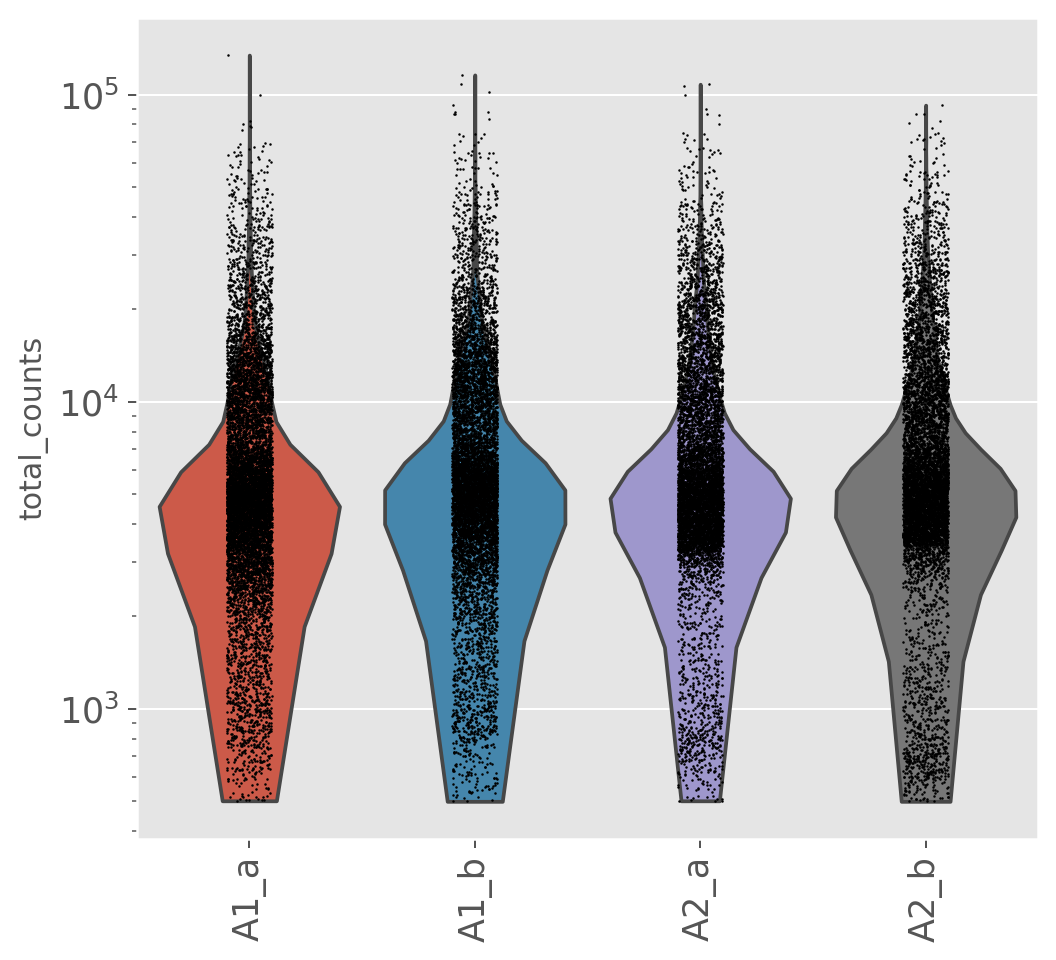

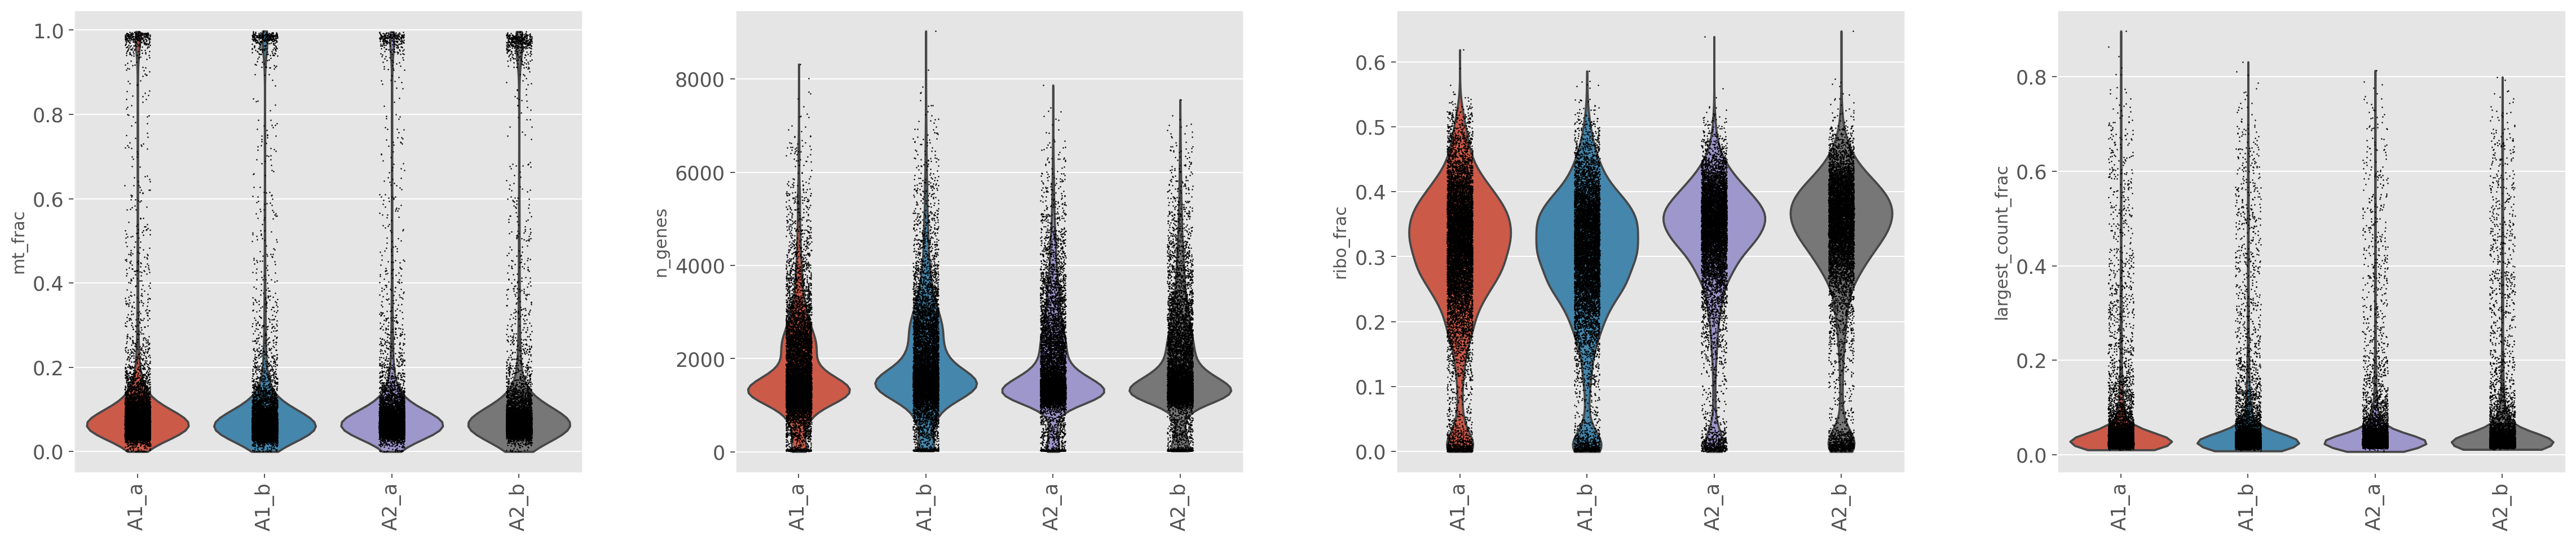

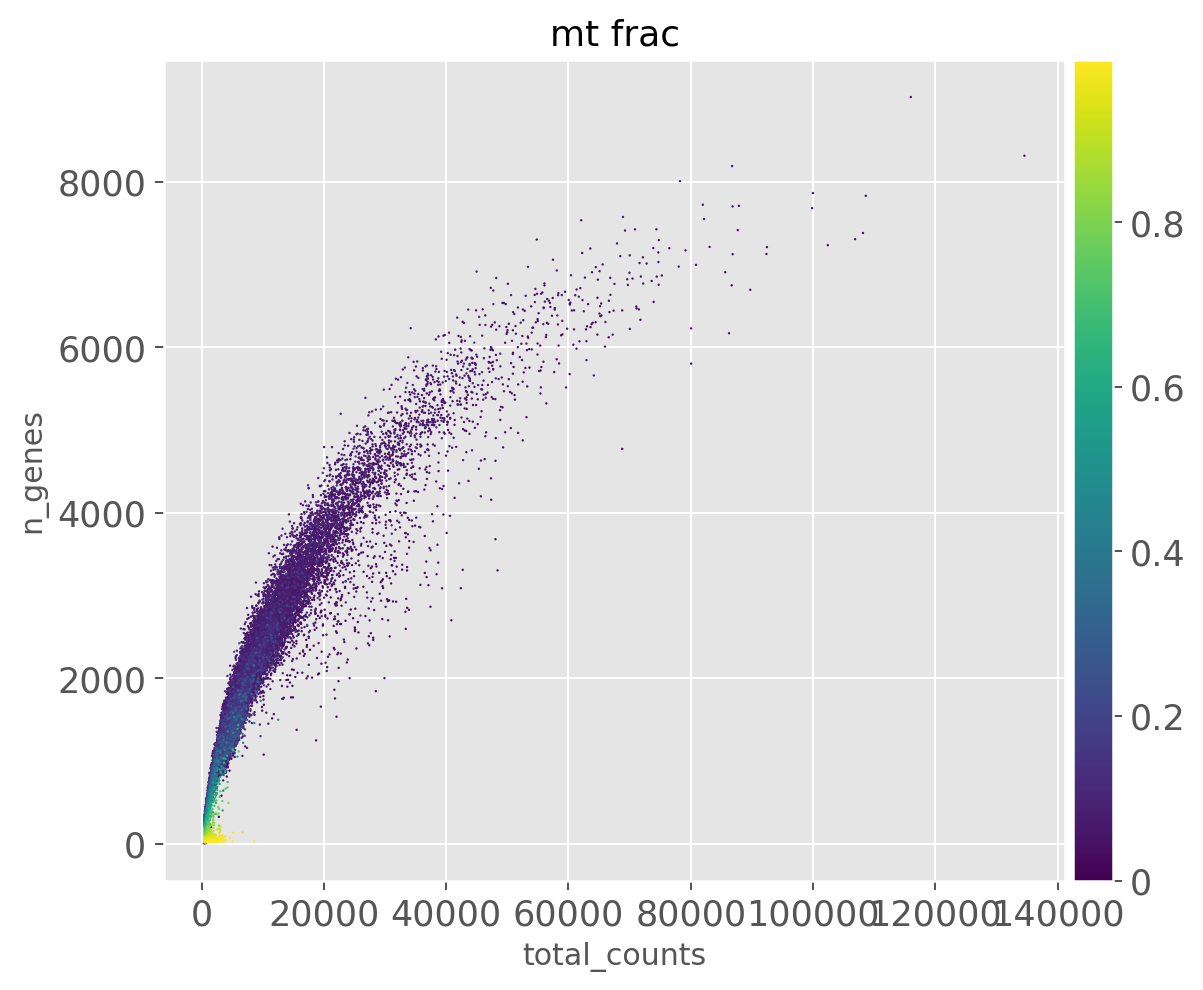

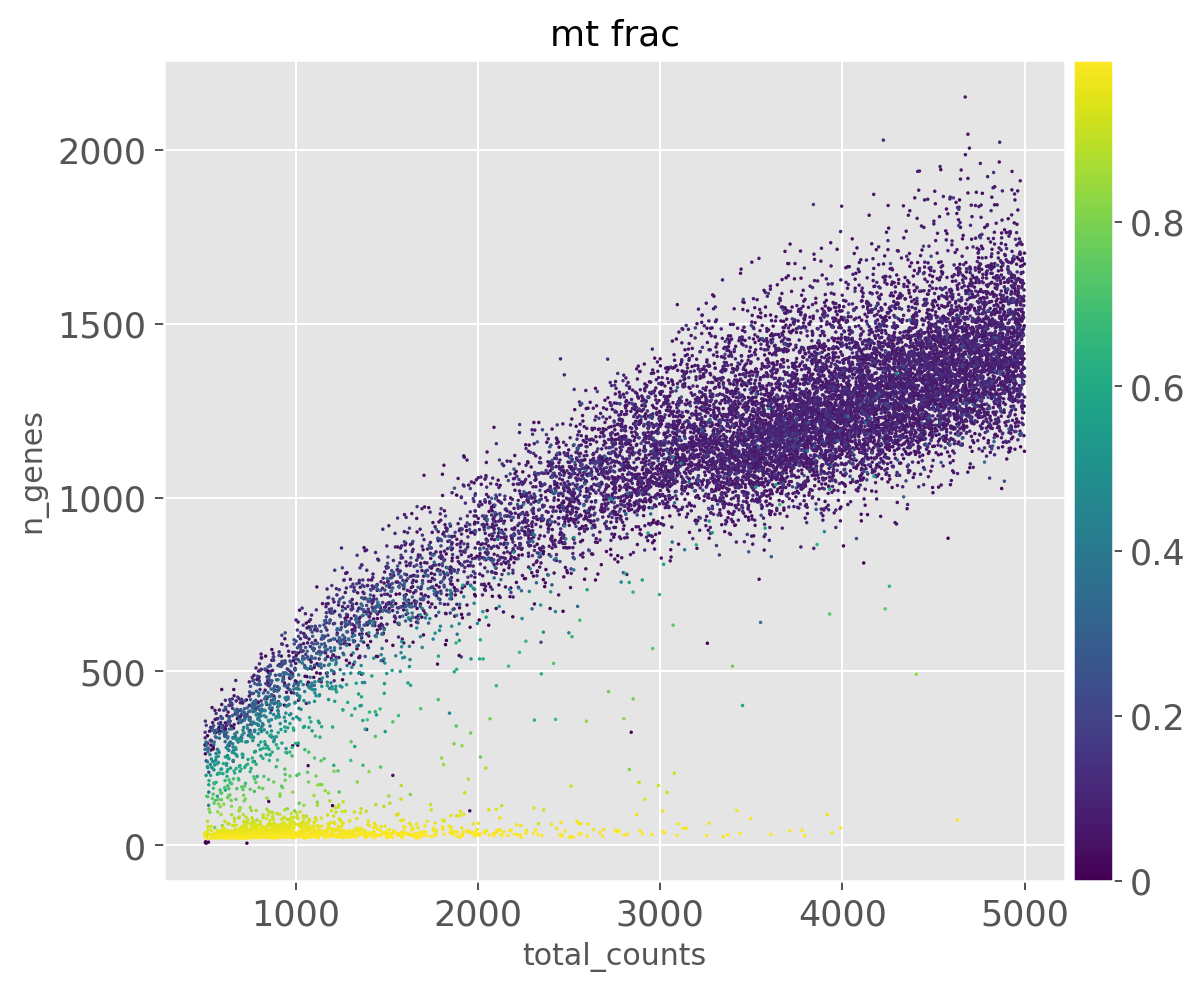

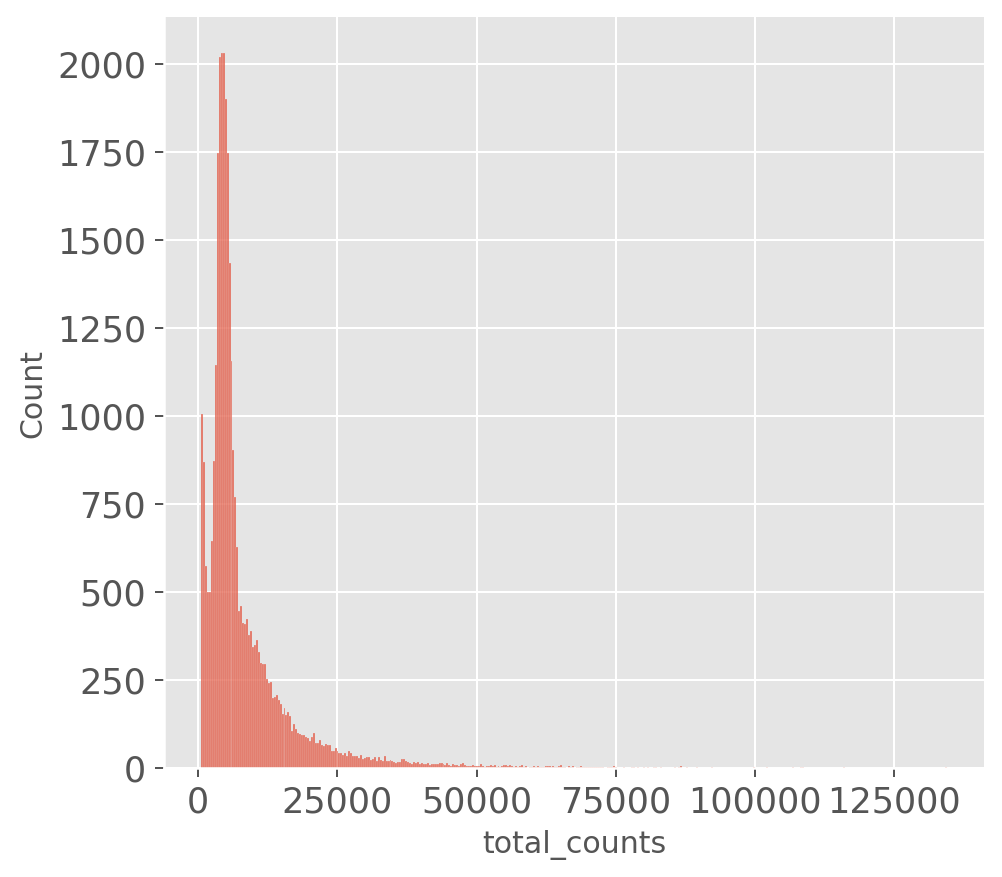

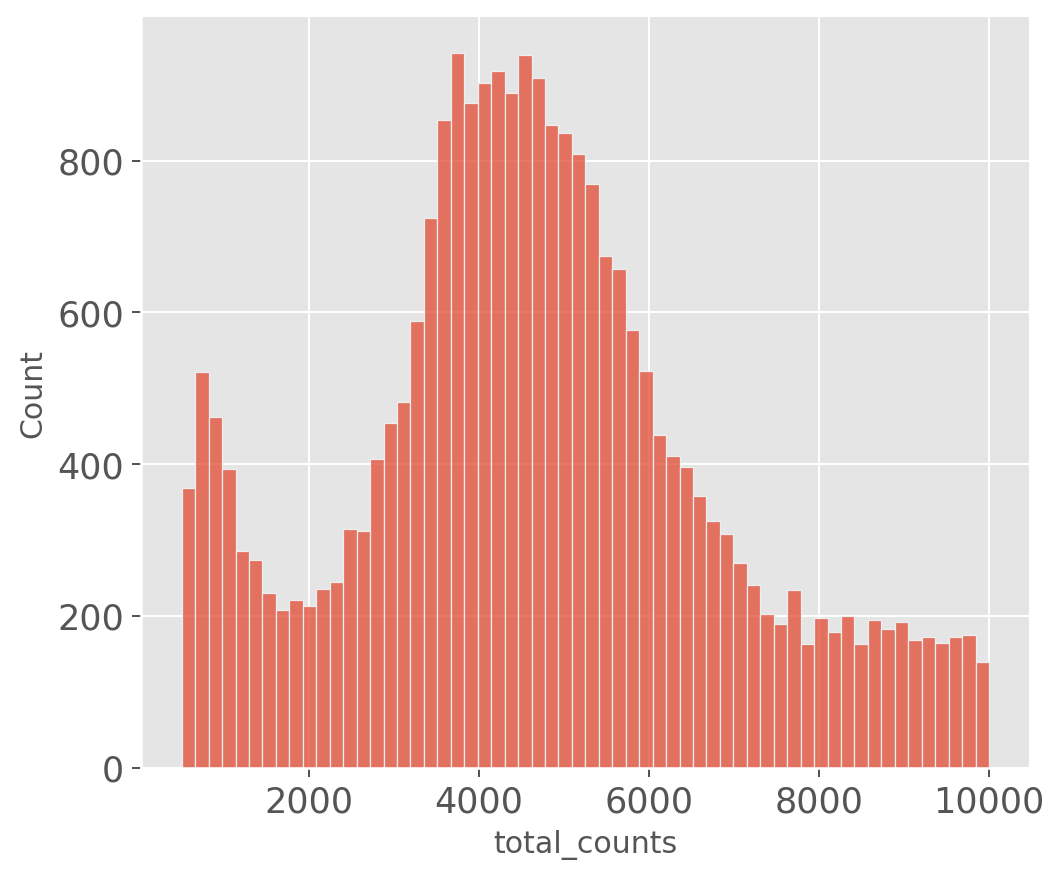

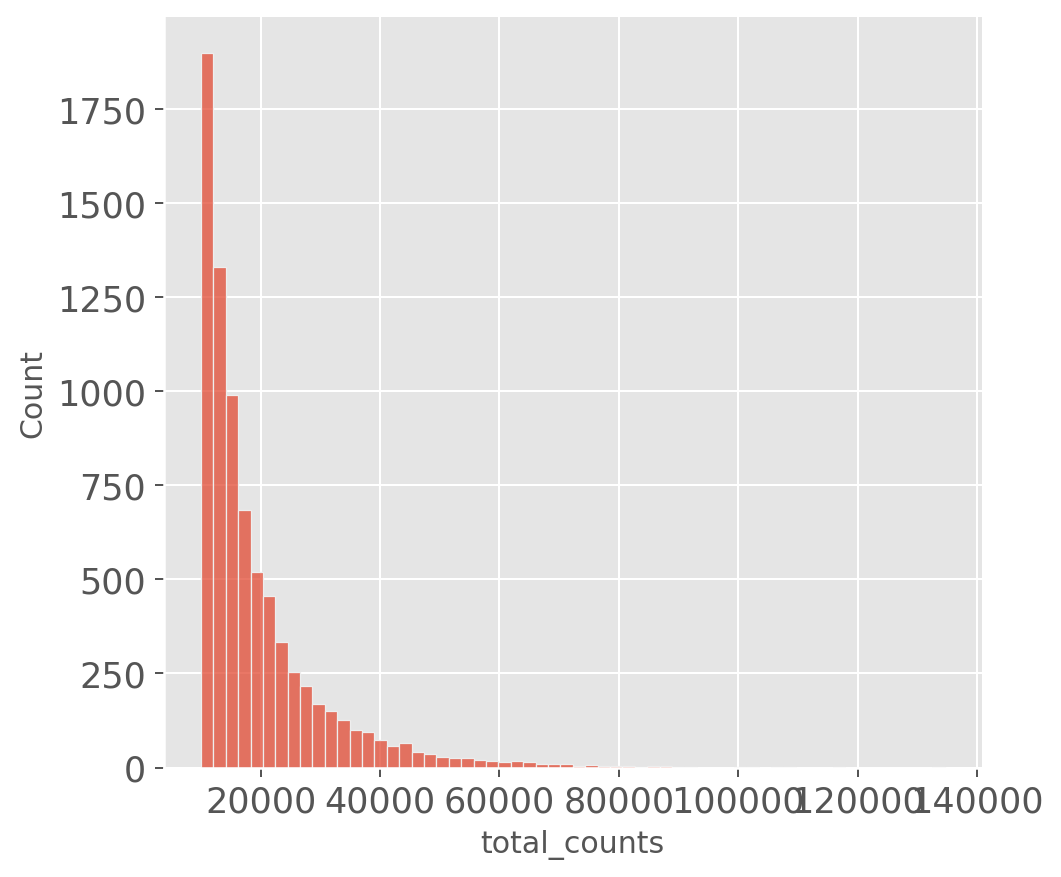

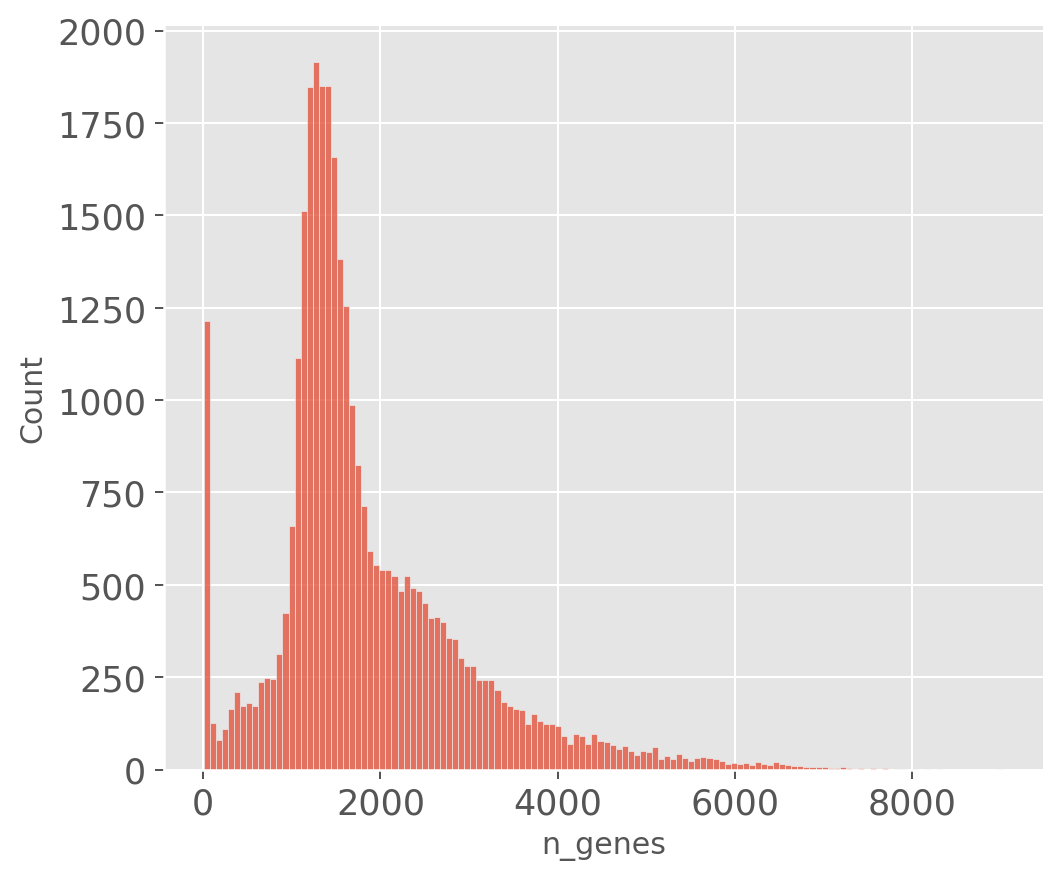

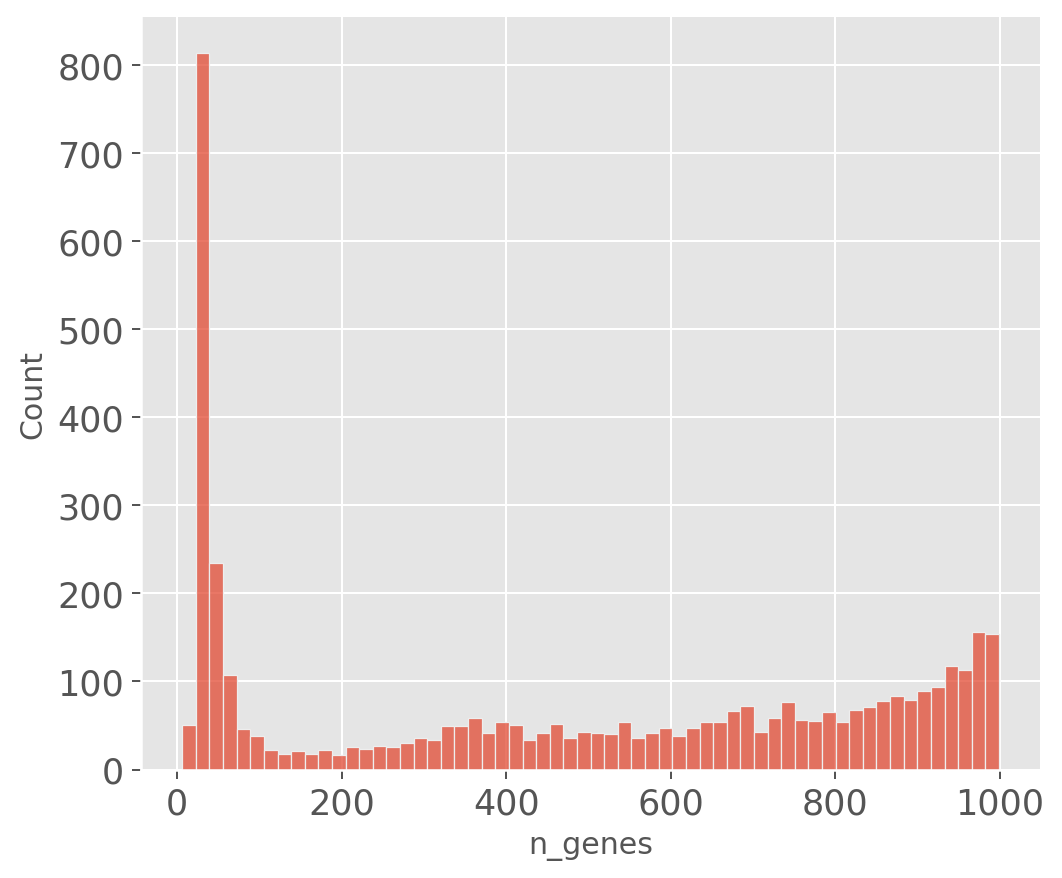

In [280]:
sctool.qc_plots(gex_adata)

In [ ]:
sc.pl.highest_expr_genes(gex_adata)

From the above QC plots, you can determine the threshold for filtering n_genes, n_counts, mt_fraction

In [ ]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(gex_adata.n_obs))

sc.pp.filter_cells(gex_adata, min_counts = 1200)
print('Number of cells after min count filter: {:d}'.format(gex_adata.n_obs))

sc.pp.filter_cells(gex_adata, max_counts = 4e4)
print('Number of cells after max count filter: {:d}'.format(gex_adata.n_obs))

gex_adata = gex_adata[gex_adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(gex_adata.n_obs))

sc.pp.filter_cells(gex_adata, min_genes = 400)
print('Number of cells after gene filter: {:d}'.format(gex_adata.n_obs))

In [ ]:
#Filter genes:
print('Total number of genes: {:d}'.format(gex_adata.n_vars))

# Min 10 cells - filters out 0 count genes
sc.pp.filter_genes(gex_adata, min_cells=10)
print('Number of genes after cell filter: {:d}'.format(gex_adata.n_vars))

## 2.2 Normalization
This step creates a copy of adata and run clustering to generate a pre-clusters which will be used for downstream normalization using scran package. The main goal of using scran is to calculate size factor for each cell and then normalize the raw count.

In [ ]:
#Perform a clustering for scran normalization in clusters
adata_pp = gex_adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e4)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

In [ ]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = gex_adata.X.T
#Delete adata_pp
del adata_pp

In [ ]:
#=================================================================
# implement the R code using rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

scran = importr('scran')
scran.SingleCellExperiment()
# scran.r('''
#     size_factors = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters=input_groups, min.mean=0.1))
# ''')
# size_factors = robjects.r['size_factors']

x = scipy.csc_matrix([[0,2],[3,0]])
r_data_mat = matrix.sparseMatrix(i=x.indices,p=x.indptr+1,x=data_mat.data)

from rpy2.robjects import pandas2ri
matrix = importr('Matrix')
r_data_mat = matrix.sparseMatrix(i=data_mat.indices,p=data_mat.indptr,x=data_mat.data)

from rpy2.robjects.packages import importr
base = importr('base')
stats = importr('stats')
rnorm = stats.rnorm

Calculating size factors using scrun is memory intensive for f, and also takes a lot of time. Eg: if your data has 60k cells, it would take about a little over 70 GB memory.

In [ ]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters=input_groups, min.mean=0.1))

In [ ]:
# Visualize the estimated size factors
gex_adata.obs['size_factors'] = size_factors

sc.pl.scatter(gex_adata, 'size_factors', 'n_counts')
sc.pl.scatter(gex_adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [ ]:
# Keep the count data in a counts layer
gex_adata.layers["counts"] = gex_adata.X.copy()

In [ ]:
#Normalize adata 
gex_adata.X = gex_adata.X.multiply(sp.sparse.csr_matrix(1/gex_adata.obs['size_factors'].values[:,None]))
sc.pp.log1p(gex_adata)

In [ ]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
gex_adata.raw = gex_adata

## 2.3 Highly Variable Genes
Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these. <br/>
Highly variable gene information is stored automatically in the adata.var['highly_variable'] field.

Note: raw code of scanpy may get error if the bin edges are duplicated. The error message is ** Bin edges must be unique, You can drop duplicate edges by setting the 'duplicates' kwarg**. To makesure the error would not occur for all cases, you can change the source code in line 244 of the file https://github.com/scverse/scanpy/blob/master/scanpy/preprocessing/_highly_variable_genes.py#L295-L564.  add a parameter duplicates='drop'

In [ ]:
sc.pp.highly_variable_genes(gex_adata, flavor='seurat', n_top_genes=4000,n_bins=50)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(gex_adata.var['highly_variable'])))

In [ ]:
sc.pl.highly_variable_genes(gex_adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

## 2.4 Batch correction
Origianl pipeline uses combat, usually correct based on sample. 
There are some other popular batch correction method like BBKNN tutorial or ingest here for integrating datasets.https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html. Note ComBat batch correction can produce negative expression values. One can either set all negative values to 0 or force zeros pre-batch-correction to remain zero post-batch-correction. <br/>

Based on the benchmark of batch effect removal methods [here](https://www.nature.com/articles/s41592-021-01336-8). Scanorama was one of the top recommended algorithms. Harmany was metioned to perform well for easy cases. So here we test scanorama and harmany and pick the best of the two in this pipeline.

In [ ]:
n_pc = 16
sc.tl.pca(gex_adata, n_comps=n_pc, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(gex_adata, n_pcs=n_pc)

In [ ]:
sce.pp.scanorama_integrate(gex_adata, 'sample')
sce.pp.harmony_integrate(gex_adata, 'sample', max_iter_harmony = 15)

## 2.5 UMAP visualize to choose batch effect methods and compute neighbors
This step aims to test which batch effect removal method works better. Currently we applied two methods: scanorama and harmony.

In [ ]:
# Calculate the UMAP using scanorama
sc.pp.neighbors(gex_adata, use_rep = 'X_scanorama', key_added='scanorama')
sc.tl.umap(gex_adata, neighbors_key='scanorama')
sc.pl.umap(gex_adata, color='n_counts')

In [ ]:
# Calculate the UMAP using harmany
sc.pp.neighbors(gex_adata, use_rep = 'X_pca_harmony',key_added='hmny')
sc.tl.umap(gex_adata, neighbors_key='hmny')
sc.pl.umap(gex_adata, color='n_counts')

Based on the UMAP plot, scanorama, has generates many tiny clusters which looks like norise when removing batch effect. While harmony performs better with more continuouse clusters

## 2.6 Cell cycle scoring
Annotate cell state in cell cycle. States are S, G2.M, 

In [ ]:
#Score cell cycle and visualize the effect:
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_ens = gex_adata.var_names[np.in1d(gex_adata.var_names, s_genes)]
g2m_genes_ens = gex_adata.var_names[np.in1d(gex_adata.var_names, g2m_genes)]
sc.tl.score_genes_cell_cycle(gex_adata, s_genes=s_genes_ens, g2m_genes=g2m_genes_ens)

The dataset now contains:
- a 'counts' layer with count data
- log-normalized data in adata.X
- batch corrected data in adata.obsm['X_scanorama'] or adata.obsm['']
- highly variable gene annotations in adata.var['highly_variable']

The HVG labels will be used to subselect genes for clustering and trajectory analysis.

# 3. Cluster and annotation
## 3.1 Clustering
First calculate PCA, then use the PCA to get K nearest neighbor, and then use louvian method to do clustering.
You can set random_state to make sure the results is reproducible.

In [ ]:
sc.tl.leiden(gex_adata, key_added='leiden_r0.5', resolution=0.5, neighbors_key='hmny')
sc.tl.leiden(gex_adata, key_added='leiden_r1', resolution=1.0, neighbors_key='hmny')

In [ ]:
gex_adata.obs['leiden_r0.5'].value_counts()

In [ ]:
# Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(gex_adata, color=['leiden_r0.5'], palette=sc.pl.palettes.default_102, legend_loc='on data')
sc.pl.umap(gex_adata, color=['leiden_r1'], palette=sc.pl.palettes.default_102, legend_loc='on data')
sc.pl.umap(gex_adata, color=['sample'])
sc.pl.umap(gex_adata, color=['log_counts', 'mt_frac', 'n_counts'])

## 3.2 Marker genes & cluster annotation
This differential expression test is performed by a Welch t-test with overestimated variance to be conservative. This is the default in scanpy. The test is automatically performed on the .raw data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

In [ ]:
# Calculate marker genes
sc.tl.rank_genes_groups(gex_adata, groupby='leiden_r0.5', key_added='rank_genes_r0.5')
sc.tl.rank_genes_groups(gex_adata, groupby='leiden_r1', key_added='rank_genes_r1')

In [ ]:
#Plot marker genes, need to change groups based on how many clusters you get
sc.pl.rank_genes_groups(gex_adata, key='rank_genes_r0.5', groups=['12','13'], fontsize=12)
# sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['3','4'], fontsize=12)
# sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['6','7','8'], fontsize=12)

### 3.2.1 Annotate using SCSA
Tools is available here https://github.com/bioinfo-ibms-pumc/SCSA.

In [ ]:
# list all tissues
!python /opt/SCSA/SCSA.py -d /opt/SCSA/whole.db -i test -l

In [ ]:
init_celltype = sctool.scsa_cell_anno(gex_adata, rank_key='rank_genes_r0.5', clust_col='leiden_r0.5', species='Human',tissue='Blood', tmp_dir='/tmp')

Before run SCSA you can run the following command to check what tissue is available in SCSA:
python /opt/SCSA/SCSA.py -d /opt/SCSA/whole.db -i test -l

### 3.2.2 Manual curation of the initial annotation
This step requires users to check the details of the inital cell type annotation and then refine the annotation.

In [ ]:
# manual curation of the predicted cell types
init_celltype['0'] = 'B cell'
init_celltype['1'] = 'B cell'
init_celltype['2'] = 'B cell' # 'Monocyte' # Granulocyte-monocyte progenitor
init_celltype['3'] = 'DC' # CD1C-CD141- dendritic cell
init_celltype['4'] = 'DC'  # CD1C-CD141- dendritic cell|CD141+CLEC9A+ dendritic cell
init_celltype['5'] = 'NK' 
init_celltype['6'] = 'B cell' # 'Ighv3'
init_celltype['7'] = 'B cell' # 'Ighv3'
init_celltype['8'] = 'T cell'
init_celltype['9'] = 'B cell'
init_celltype['10'] = 'Plasma'
init_celltype['11'] = 'DC'
init_celltype['12'] = 'DC'
init_celltype['13'] = 'T cell'
gex_adata.obs['cell_type'] = gex_adata.obs['leiden_r0.5'].map(lambda x: init_celltype[x])
gex_adata.obs['cell_type'].value_counts()

In [ ]:
sc.pl.umap(gex_adata, color=['cell_type'], palette=sc.pl.palettes.default_102, legend_loc='on data')
sc.pl.umap(gex_adata, color=['sample'], palette=sc.pl.palettes.default_102)

In [ ]:
sc.pl.umap(gex_adata, color=['CD3D','CD14','FCGR3A','CD79A','CD79B','CD19','MS4A1'], palette=sc.pl.palettes.default_102)

In [ ]:
sc.tl.rank_genes_groups(gex_adata, groupby='cell_type', key_added='rank_genes_cell_type')

In [ ]:
sc.pl.rank_genes_groups_heatmap(gex_adata, n_genes=10, min_logfoldchange=1.0, key='rank_genes_cell_type')

In [ ]:
sc.set_figure_params(scanpy=True, dpi=90)
sc.pl.rank_genes_groups_dotplot(gex_adata,n_genes=5, key='rank_genes_r0.5')

In [ ]:
ax = gex_adata.obs['cell_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [ ]:
gex_adata.obs.groupby(['cell_type','sample']).size().unstack().plot(kind='bar',stacked=True, figsize=(6,4))

In [ ]:
gex_adata.write(f'{work_dir}/inter_h5ad/gex_adata.h5ad')

In [ ]:
# gex_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/gex_adata.h5ad')
# gex_adata.uns['log1p']["base"] = None

#### Define the threshold for the imputation
Single cells are very spares, so usually people would consdier genes expressed if they have non zero values in certain amount of cells. Some people chose 5% of all cells as cut-offs. Here we check distribution of gene average expressions to determine what percentage to use for our data sets. We also use expression of house keeping genes as reference (house keeping genes can be found here https://www.genomics-online.com/resources/16/5049/housekeeping-genes/).

In [ ]:
def get_mean_expr(gex_adata, pct=0.1, genes=[]):
    '''
    this function get mean expression for each gene.
    * gex_adat: input ann data.
    '''
    hk_adata = gex_adata.copy()
    hk_adata.X = hk_adata.layers['counts'].copy()
    sc.pp.normalize_total(hk_adata, target_sum=1e4)
    sc.pp.log1p(hk_adata)
    sc.pp.filter_genes(hk_adata, min_cells=hk_adata.shape[0] * pct)
    if genes != []:
        genes = list(set(genes).intersection(hk_adata.var.index))
        hk_adata = hk_adata[:,genes]
    mean_vals = hk_adata.X.A.mean(0)
    return mean_vals, hk_adata.var.index

In [ ]:
pct0, _ = get_mean_expr(gex_adata, pct=0)
pct10, expr_10genes = get_mean_expr(gex_adata, pct=0.1)
pct5, _ = get_mean_expr(gex_adata, pct=0.05)
hk_genes = ['ACTB','GAPDH','PGK1', 'PPIA','RPL13A','RPLP0', 'ARBP', 'B2M', 'YWHAZ', 'SDHA', 'TFRC', 'GUSB', 'HMBS','HPRT1','TBP']
hk, _ = get_mean_expr(gex_adata, pct=0, genes=hk_genes)

In [ ]:
# filter 10 percent
fig, ax = plt.subplots(dpi=100)
_ = sb.distplot(pct0, kde=True, bins=100, hist=True, ax=ax,hist_kws=dict(alpha=0))
_ = sb.distplot(pct5, kde=True, bins=100, hist=True, ax=ax,hist_kws=dict(alpha=0))
_ = sb.distplot(pct10, kde=True, bins=100, hist=True, ax=ax,hist_kws=dict(alpha=0))
_ = sb.distplot(hk, kde=True, bins=100, hist=True, ax=ax,hist_kws=dict(alpha=0))
ax.set_xlim([-1,6])
ax.legend(['all: 58320 genes','pct5: 8051 genes','pct10: 5671 genes','housekeeping: 14 genes'],loc='upper left')
ax.set_title('Distribution of average gene expression')
ax.set_xlabel('expression')

# Antobody part
## 1. QC
### 1.1 Plot n_counts, n_proteins

In [263]:
ab_adata = adata[:,adata.var.query('feature_types == "Antibody Capture"').index]
ab_adata.obs['n_counts'] = ab_adata.X.sum(1)
ab_adata.obs['log_counts'] = np.log(ab_adata.obs['n_counts'])
ab_adata.obs['n_proteins'] = (ab_adata.X > 0).sum(1)
ab_adata.obs = pd.merge(ab_adata.obs, pd.DataFrame(gex_adata.obs['cell_type']), how='left', left_index=True, right_index=True)
ab_adata.layers['counts'] = ab_adata.X.copy()

In [ ]:
sc.pl.violin(ab_adata, 'n_counts', groupby='sample', size=1, log=True,cut=0,rotation=90, figsize=(2,2))
sc.pl.violin(ab_adata, 'n_proteins', groupby='sample',rotation=90)

In [ ]:
_ = plt.scatter(ab_adata.obs['n_counts'], ab_adata.obs['n_proteins'], color='purple', s=0.3)
plt.xlabel('n_counts')
plt.ylabel('n_proteins')

### 1.2 Filter cells
Since we have filtered some cells in the scRNAseq part, so here we will filter based on that data

In [266]:
sc.pp.filter_cells(ab_adata, min_genes=50)
print('Number of cells after min genes filter: {:d}'.format(ab_adata.n_obs))

filtered out 23 cells that have less than 50 genes expressed
Number of cells after min genes filter: 33497


In [ ]:
# # update gex_adata
# gex_adata = gex_adata[ab_adata.obs.index,:]
# gex_adata.obs['cell_type'].value_counts()

## 2 Demultiplex control and IgAN sample
They used hash tag to multiplex IgAN/control samples in a single run. So we need to use HTO sequence to demultiplex the samples. Based on their experience, manual demultiplexing performs much better than automatic methods.
First need to normalize CITE-Seq data, the method is CLR (centered log ratio).  log(HTO count / genometric_mean(all feature counts))

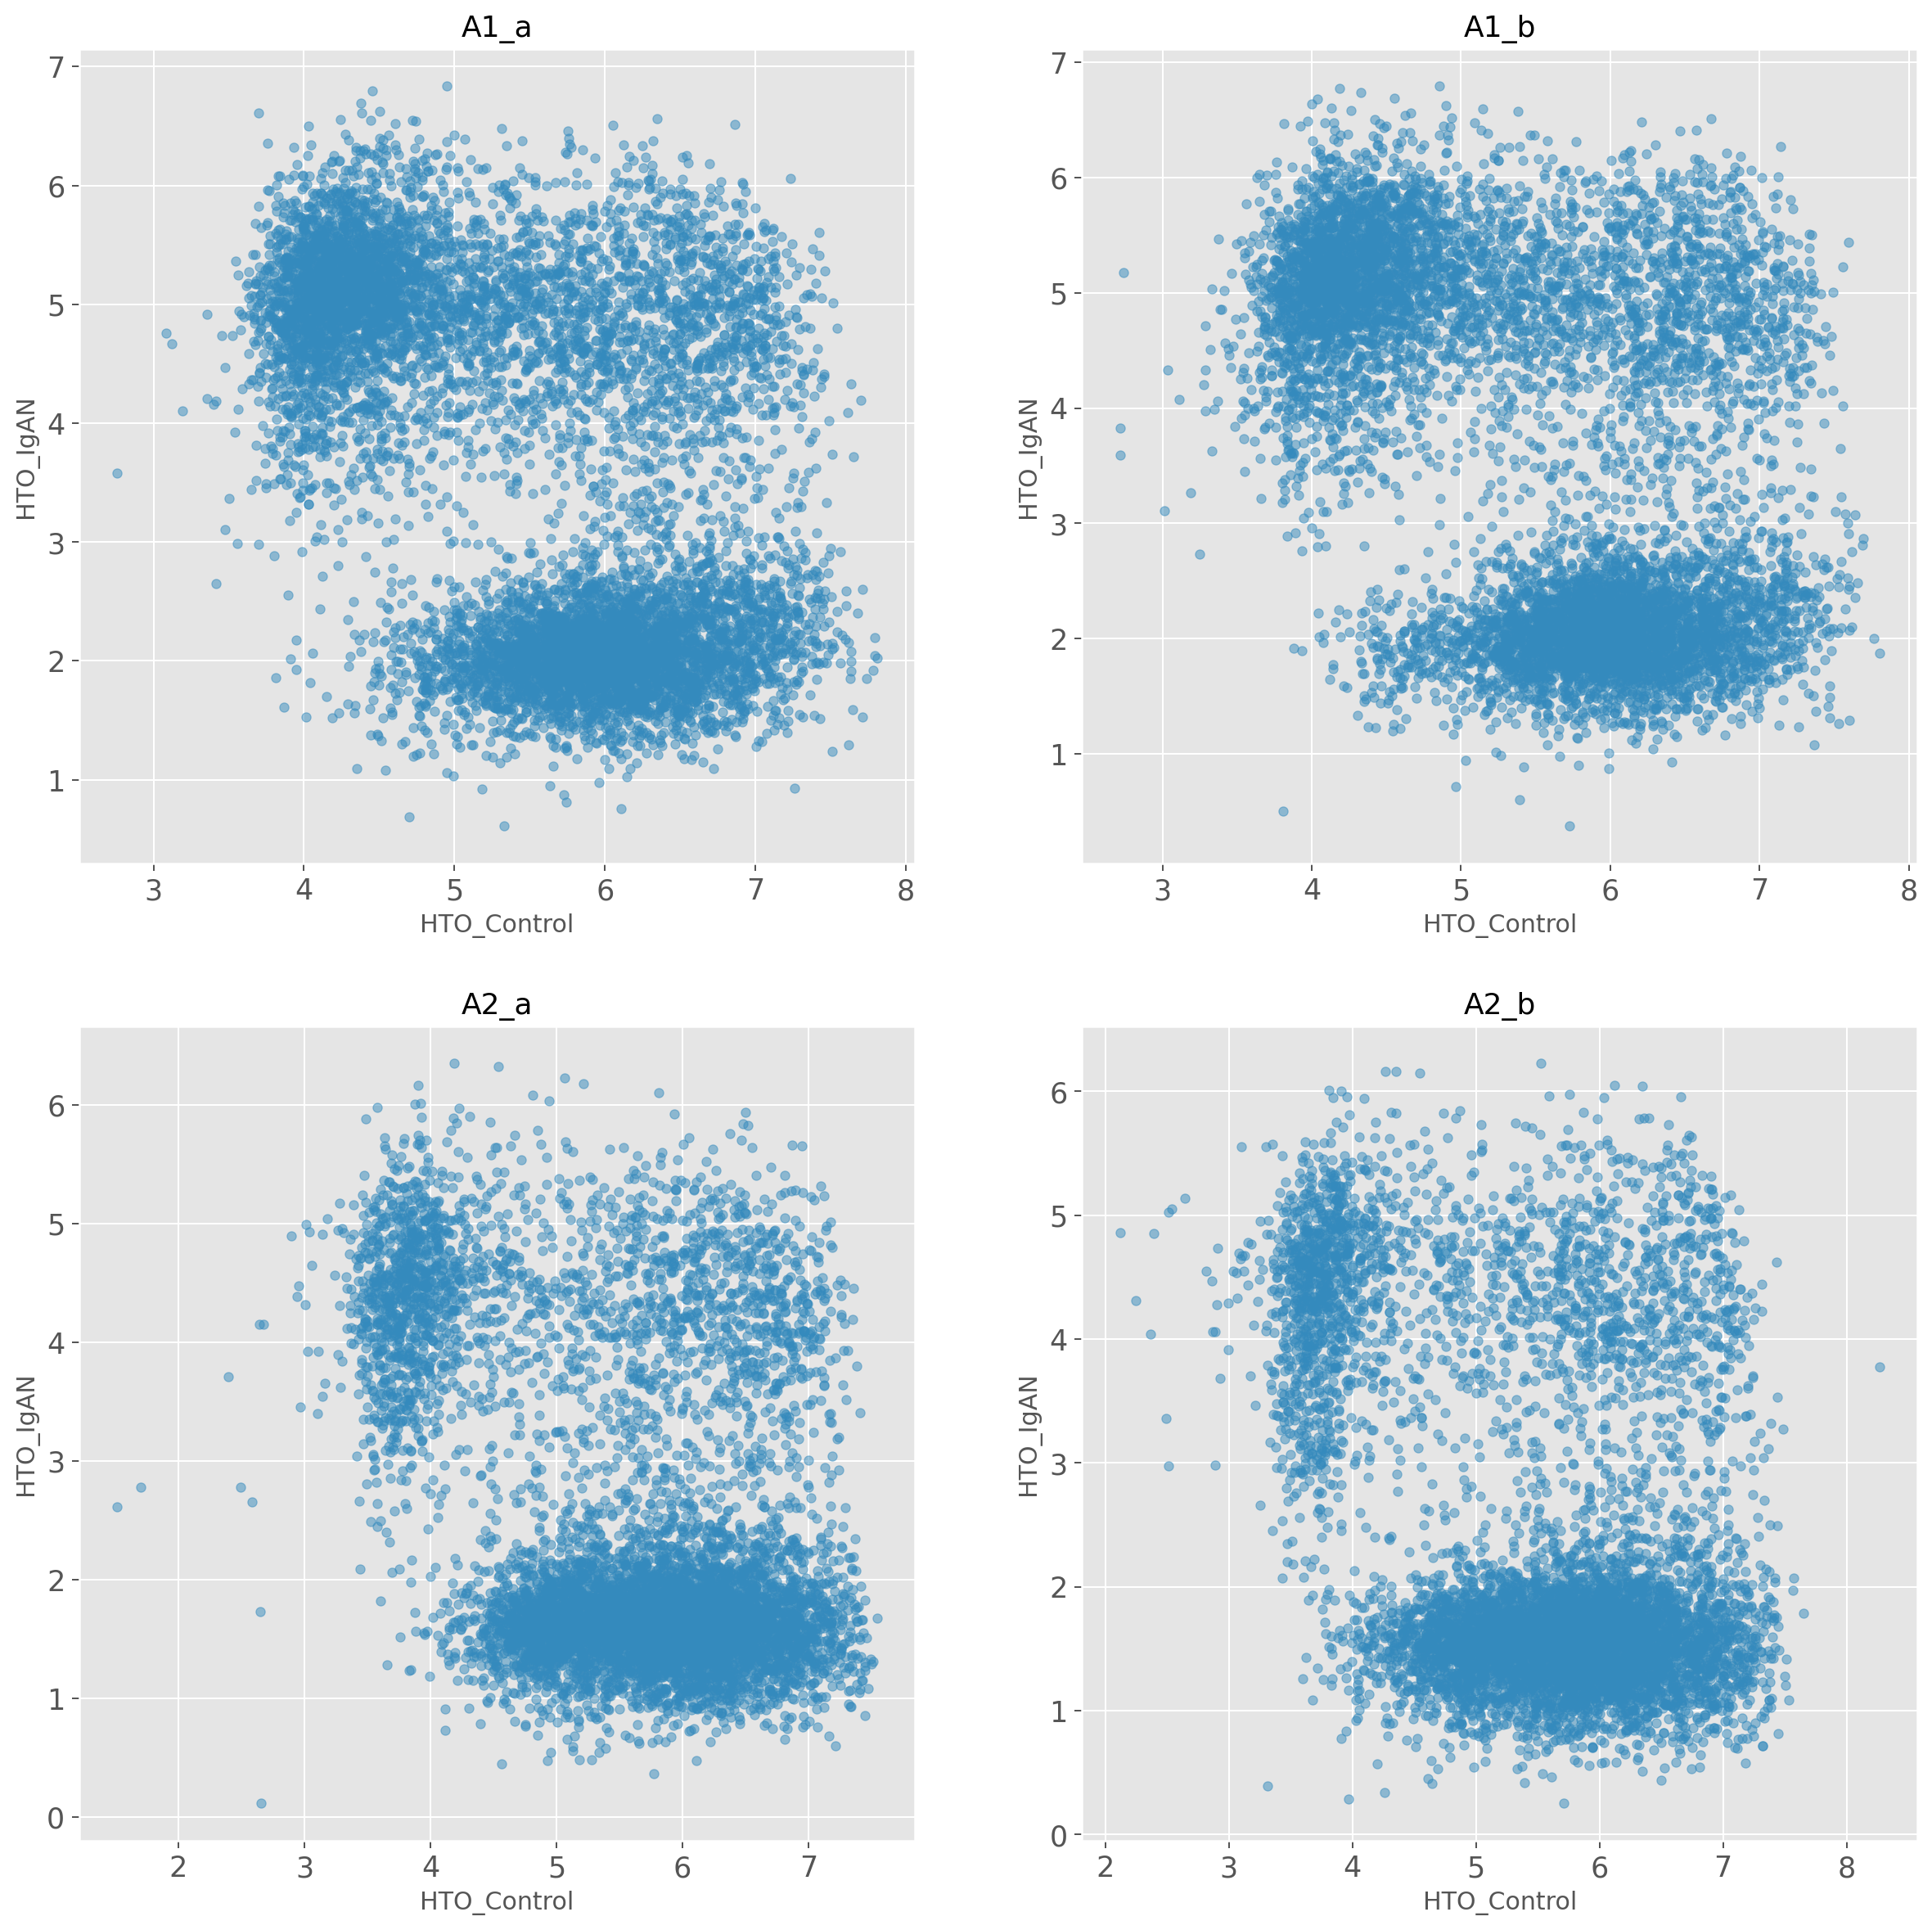

In [267]:
# scatter plot show normalized count of sample hash tags
fig, axs = plt.subplots(2, 2, figsize=(16,16),sharex=False,sharey=False)
ab_adata_list = []
hto_list = []
sps = sorted(ab_adata.obs['sample'].unique())
for i,sp in enumerate(sps):
    row = i // 2
    col = i % 2
    ad = ab_adata[ab_adata.obs['sample']==sp]
    pt.pp.clr(ad, inplace=True, axis=1)
    ab_adata_list.append(ad)
    hto_df = ad[:,['HTO_IgAN', 'HTO_Control']].to_df()
    hto_df['sample'] = sp
    hto_list.append(hto_df)
    hto_df.plot.scatter('HTO_Control', 'HTO_IgAN' ,title=sp,alpha=0.5,ax=axs[row, col])

In [ ]:
# # highlight cells are the cells corrected by BCR sequence.
# # scatter plot show normalized count of sample hash tags
# fig, axs = plt.subplots(2, 2, figsize=(16,16),sharex=False,sharey=False)
# ab_adata_list = []
# hto_list = []
# sps = sorted(ab_adata.obs['sample'].unique())
# for i,sp in enumerate(sps):
#     row = i // 2
#     col = i % 2
#     ad = ab_adata[ab_adata.obs['sample']==sp]
#     pt.pp.clr(ad, inplace=True, axis=1)
#     ab_adata_list.append(ad)
#     hto_df = ad[:,['HTO_IgAN', 'HTO_Control']].to_df()
#     hto_df['sample'] = sp
#     hto_list.append(hto_df)    
#     hto_df.plot.scatter('HTO_Control', 'HTO_IgAN' ,title=sp,alpha=0.5,ax=axs[row, col])
#     # plot miss
#     inter_index = set(hto_df.index).intersection(miss_class_cells)
#     miss_df = hto_df.loc[inter_index,:]
#     miss_df.plot.scatter('HTO_Control', 'HTO_IgAN' ,title=sp,alpha=0.5,ax=axs[row, col], color='r')
#     # plot miss doublet
#     inter_index = set(hto_df.index).intersection(miss_doublet)
#     miss_df = hto_df.loc[inter_index,:]
#     miss_df.plot.scatter('HTO_Control', 'HTO_IgAN' ,title=sp,alpha=0.5,ax=axs[row, col], color='b')

Based on the plots, we manually determine the threshold for each sample <br/>
A1_a: <br/>
&nbsp;&nbsp;&nbsp;&nbsp;control: HTO_Control > 5 and HTO_IgAN < 3 <br/>
&nbsp;&nbsp;&nbsp;&nbsp;IgAN:    HTO_Control < 5 and HTO_IgAN > 3 <br/>
A1_b: <br/>
&nbsp;&nbsp;&nbsp;&nbsp;control: HTO_Control > 5 and HTO_IgAN < 3 <br/>
&nbsp;&nbsp;&nbsp;&nbsp;IgAN:    HTO_Control < 5 and HTO_IgAN > 3 <br/>
A2_a: <br/>
&nbsp;&nbsp;&nbsp;&nbsp;control: HTO_Control > 4.2 and HTO_IgAN < 3 <br/>
&nbsp;&nbsp;&nbsp;&nbsp;IgAN:    HTO_Control < 4.2 and HTO_IgAN > 3 <br/>
A2_b: <br/>
&nbsp;&nbsp;&nbsp;&nbsp;control: HTO_Control > 4.2 and HTO_IgAN < 2.5 <br/>
&nbsp;&nbsp;&nbsp;&nbsp;IgAN:    HTO_Control < 4.2 and HTO_IgAN > 2.5 <br/>

In [ ]:
# add sample annotation based on the threshold
def demulti(row):
    '''
    demultiplex samples using manual defined thresholds
    '''
    if row['sample'] == 'A1_a': 
        if row['HTO_Control'] > 5 and row['HTO_IgAN'] < 3:
            return 'control'
        elif row['HTO_Control'] < 5 and row['HTO_IgAN'] > 3:
            return 'IgAN'
        else:
            return 'doublet'
    if row['sample'] == 'A1_b': 
        if row['HTO_Control'] > 5 and row['HTO_IgAN'] < 3:
            return 'control'
        elif row['HTO_Control'] < 5 and row['HTO_IgAN'] > 3:
            return 'IgAN'
        else:
            return 'doublet'
    if row['sample'] == 'A2_a': 
        if row['HTO_Control'] > 4.2 and row['HTO_IgAN'] < 3:
            return 'control'
        elif row['HTO_Control'] < 4.2 and row['HTO_IgAN'] > 3:
            return 'IgAN'
        else:
            return 'doublet'
    if row['sample'] == 'A2_b': 
        if row['HTO_Control'] > 4.2 and row['HTO_IgAN'] < 2.5:
            return 'control'
        elif row['HTO_Control'] < 4.2 and row['HTO_IgAN'] > 2.5:
            return 'IgAN'
        else:
            return 'doublet'

In [ ]:
hto_df = pd.concat(hto_list)
hto_df['condition'] = hto_df.apply(lambda x: demulti(x), axis=1)

ab_adata.obs = pd.merge(ab_adata.obs, hto_df[['condition','HTO_IgAN','HTO_Control']], how='left', left_index=True, right_index=True)
ab_adata.obs['condition'].value_counts()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
hto_df.groupby(['sample','condition']).size().unstack().plot(kind='bar',stacked=True, ax=axes[0])
hto_df.groupby(['sample','condition']).size().unstack().apply(lambda x: x/sum(x), axis=1).plot(kind='bar',stacked=True, ax=axes[1])

In [ ]:
ab_adata.obs['condition'].value_counts()

In [ ]:
ab_adata = ab_adata[ab_adata.obs['condition'] != 'doublet']
ab_adata = ab_adata[:, [g for g in ab_adata.var.index if g not in ['HTO_IgAN','HTO_Control']]]

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
ab_adata.obs.groupby(['sample','condition']).size().unstack().plot(kind='bar',stacked=True, ax=axes[0])
ab_adata.obs.groupby(['sample','condition']).size().unstack().apply(lambda x: x/sum(x), axis=1).plot(kind='bar',stacked=True, ax=axes[1])

The above figure shows in A2 most cells are from control samples.

In [ ]:
ab_adata.obs.groupby(['sample','condition']).size().unstack().apply(lambda x: x/sum(x), axis=1).round(2)

### select proteins that are expressed in at least 10% of the cells

In [ ]:
def get_pr_mean_expr(ab_adata, pct=0.1, genes=[]):
    '''
    this function get mean expression for each gene.
    * ab_adata: input ann data.
    '''
    hk_adata = ab_adata.copy()
    sc.pp.filter_genes(hk_adata, min_cells=hk_adata.shape[0] * pct)
    if genes != []:
        genes = list(set(genes).intersection(hk_adata.var.index))
        hk_adata = hk_adata[:,genes]
    mean_vals = hk_adata.X.A.mean(0)
    return mean_vals, hk_adata.var.index

In [ ]:
ab_pct10, ab_pct10_pr = get_pr_mean_expr(ab_adata, pct=0.1)


# pct0, _ = get_mean_expr(gex_adata, pct=0)
# pct10, expr_10genes = get_mean_expr(gex_adata, pct=0.1)
# pct5, _ = get_mean_expr(gex_adata, pct=0.05)
# hk_genes = ['ACTB','GAPDH','PGK1', 'PPIA','RPL13A','RPLP0', 'ARBP', 'B2M', 'YWHAZ', 'SDHA', 'TFRC', 'GUSB', 'HMBS','HPRT1','TBP']
# hk, _ = get_mean_expr(gex_adata, pct=0, genes=hk_genes)

## 3 PCA

In [ ]:
sc.tl.pca(ab_adata)
sc.pp.neighbors(ab_adata)
sc.tl.umap(ab_adata, random_state=1)

In [ ]:
sc.pl.pca_variance_ratio(ab_adata)

In [ ]:
sc.pl.pca(ab_adata, color='condition')

In [ ]:
sc.pl.umap(ab_adata, color=['sample','condition'])

In [ ]:
ab_adata.write(f'{work_dir}/inter_h5ad/ab_adata.h5ad')

In [ ]:
# ab_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/ab_adata.h5ad')

# Multiomic Integration
## 1. Intersect gene names

In [ ]:
gex_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/gex_adata.h5ad')
gex_adata.uns['log1p'] = {'base':None}
ab_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/ab_adata.h5ad')
mdata = mu.MuData({'rna': gex_adata, 'prot': ab_adata})
mu.pp.intersect_obs(mdata)

In [ ]:
# Calculate the UMAP using harmany
sc.pp.neighbors(mdata['rna'], use_rep = 'X_pca_harmony')

In [ ]:
mu.tl.leiden(mdata, resolution=[1.5, .1], random_state=1)

In [ ]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=['leiden','CD3','CD14-1','CD16','CD79b (Ig&#946;)','CD19-1','CD20','Ig light chain &#954;','Ig light chain &#955;','prot:condition','prot:sample'])

In [ ]:
# protein expression on protein umap
mu.pl.embedding(mdata, basis="prot:X_umap", color=['rna:cell_type','CD3','CD14-1','CD16','CD19-1','CD20','CD79b (Ig&#946;)','prot:condition'])

In [ ]:
# gene expression project on protein umap
mu.pl.embedding(mdata, basis="prot:X_umap", color=['rna:cell_type','CD3D','CD14','FCGR3A','CD79A','CD79B','CD19','MS4A1','prot:condition'])

In [ ]:
ab_adata.var["highly_variable"] = True
mdata.update()

In [ ]:
mu.tl.mofa(mdata, outfile=f"{work_dir}/mofa.hdf5", n_factors=30)

In [ ]:
mu.pl.mofa(mdata, color=['CD3','CD14-1','CD16','CD19-1','CD20','CD79b (Ig&#946;)'])

In [ ]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata, random_state=1)

In [ ]:
# cmap = plt.get_cmap('rainbow')
# m_colors = cmap(np.linspace(0, 1, len(gex_adata.obs.cell_type.cat.categories)))
# mdata.uns["rna:celltype_colors"] = list(map(matplotlib.colors.to_hex, m_colors))

In [ ]:
mu.pl.umap(mdata, color=['rna:cell_type'], frameon=False,
           title="UMAP(MOFA) embedding with RNA celltype annotation")

In [ ]:
mu.pl.umap(mdata, color=['CD3','CD14-1','CD16','CD19-1','CD20','CD79b (Ig&#946;)'], frameon=False, cmap='viridis')

In [ ]:
mdata.write(f'{work_dir}/mdata.h5mu')

In [ ]:
# read in previously saved mdata
mdata = mu.read_h5mu(f'{work_dir}/inter_h5ad/mdata.h5mu')

## 2. Interpreting the model

In [ ]:
# from matplotlib import rcParams
# rcParams['figure.dpi'] = 100

In [ ]:
import mofax as mofa
model = mofa.mofa_model(f"{work_dir}/inter_h5ad/mofa.hdf5")

In [ ]:
mofa.plot_weights(model, factors=range(3), n_features=10, sharex=False)

In [ ]:
model.metadata["rna:cell_type"] = model.metadata["rna:cell_type"].astype('category').cat.reorder_categories(mdata['rna'].obs.cell_type.cat.categories)
mofa.plot_factors_violin(model, color='rna:cell_type', factors=range(3), dots=True, violins=False, palette='rainbow')

In [ ]:
mofa.plot_weights_heatmap(model, n_features=5, 
                         factors=range(0, 10), 
                         xticklabels_size=6, w_abs=True, 
                         cmap="viridis", cluster_factors=False)

In [ ]:
model.close()

# Check BCR sequence
We also have sequenced BCR for the cells. This dataset could tell us which cells express B cvell IgA receptor and we can use this information to correct cell type annotation for B cells that are annotated as other cell types

## 1. read the data

In [17]:
mdata = mu.read_h5mu(f'{work_dir}/inter_h5ad/mdata.h5mu')
gex_adata = mdata['rna']
gex_adata.uns['log1p']["base"] = None

In [18]:
bcd_condi_dict =  mdata.obs['prot:condition'].to_dict() # {cell barcode: IgAN/control}
gex_adata.obs['condition'] = gex_adata.obs.index.map(lambda x: bcd_condi_dict[x])

In [19]:
gex_adata.obs['condition'].value_counts()

control    17262
IgAN        7045
Name: condition, dtype: int64

In [20]:
contig_anno_fns = sorted(glob.glob(f'{work_dir}/bcr/*_filtered_contig_annotations.csv'))
bcr_list = []
for contig in contig_anno_fns:
    sample = '_'.join(contig.split('/')[-1].split('_')[:2])
    bcr_tmp = ir.io.read_10x_vdj(contig)
    bcr_tmp.obs.index = bcr_tmp.obs.index.map(lambda x: x.split('-')[0] + '-' + sample)
    bcr_list.append(bcr_tmp)
bcr = sc.concat(bcr_list)
gex_adata.obs = pd.merge(gex_adata.obs, bcr.obs, how='left', left_index=True, right_index=True)
ir.tl.chain_qc(gex_adata)

In [ ]:
# add column to annotate if the cell is IgA+ or IgA-
iga_genes = ['IGHA1', 'IGHA2']
gex_adata.obs['IgA'] = gex_adata.obs.apply(lambda row: 'IgA+' if ( (row['IR_VDJ_1_c_call'] in iga_genes) or (row['IR_VDJ_2_c_call'] in iga_genes)) else 'IgA-' , axis=1)
sc.pl.umap(gex_adata, color=['IgA','condition'])

In [ ]:
bcr_adata = gex_adata[gex_adata.obs['receptor_type']=='BCR',:]
sc.pl.umap(bcr_adata, color=['IgA','condition'])

In [ ]:
sc.pl.umap(bcr_adata[bcr_adata.obs.query('IgA == "IgA+"').index,:], color=['condition'])

In [23]:
gex_adata.obs[['sample', 'condition']].value_counts()

sample  condition
A2_a    control      5327
A2_b    control      4786
A1_a    control      3768
A1_b    control      3381
A1_a    IgAN         2695
A1_b    IgAN         2564
A2_b    IgAN          931
A2_a    IgAN          855
dtype: int64

In [24]:
gex_adata.obs['IgA'].value_counts()

IgA-    15037
IgA+     9270
Name: IgA, dtype: int64

Next we correct annotation of non-B cells with IgA to B cells, in the chain_pairing column, if the value is 'no IR', it means BCR was not detected in the cells.

In [25]:
print('number of corrected B cells annotation using BCR seq', )
miss_class_cells = gex_adata.obs.query('chain_pairing != "no IR" and cell_type != "B cell"').index
print(miss_class_cells.shape[0])
print(gex_adata.obs.query('chain_pairing != "no IR" and cell_type != "B cell"')['cell_type'].value_counts())

number of corrected B cells annotation using BCR seq
1063
Plasma    564
DC        326
T cell    148
NK         25
B cell      0
Name: cell_type, dtype: int64


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
miss_adata = gex_adata[miss_class_cells,:]
miss_adata.obs.groupby(['cell_type','sample']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0])
miss_adata.obs.groupby(['cell_type','leiden_r0.5']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1])

In [27]:
gex_adata.obs['chain_pairing'].value_counts()

single pair        11210
no IR               9730
orphan VJ           1347
ambiguous            827
extra VJ             481
two full chains      392
extra VDJ            173
orphan VDJ           147
Name: chain_pairing, dtype: int64

In [28]:
# keep the initial cell type in column "init_cell_type", BCR-Seq corected cell types is in column "cell_type"
gex_adata.obs['init_cell_type'] = gex_adata.obs['cell_type']
gex_adata.obs['cell_type'] = gex_adata.obs.apply(lambda x: 'B cell' if (x['chain_pairing']!="no IR" and x['cell_type']!='B cell') else x['cell_type'], axis=1)

In [29]:
gex_adata.obs[['sample','condition','IgA']].value_counts().sort_index()

sample  condition  IgA 
A1_a    IgAN       IgA+    2052
                   IgA-     643
        control    IgA+     411
                   IgA-    3357
A1_b    IgAN       IgA+    1977
                   IgA-     587
        control    IgA+     371
                   IgA-    3010
A2_a    IgAN       IgA+     217
                   IgA-     638
        control    IgA+    2033
                   IgA-    3294
A2_b    IgAN       IgA+     261
                   IgA-     670
        control    IgA+    1948
                   IgA-    2838
dtype: int64

In [54]:
# add annotation for cells categories ['B cell and BCR', 'other cell and BCR', 'B cell and no BCR']
def add_bcell_cate(row):
    if row['init_cell_type'] == 'B cell' and row['receptor_type'] == 'BCR':
        return 'B cell and BCR'
    if row['init_cell_type'] != 'B cell' and row['receptor_type'] == 'BCR':
        return 'other cell and BCR'
    if row['init_cell_type'] == 'B cell' and row['receptor_type'] != 'BCR':
        return 'B cell and no BCR'
    if row['init_cell_type'] != 'B cell' and row['receptor_type'] != 'BCR':
        return 'other cell and no BCR'
gex_adata.obs['b_cell_bcr'] = gex_adata.obs.apply(lambda row: add_bcell_cate(row), axis=1)

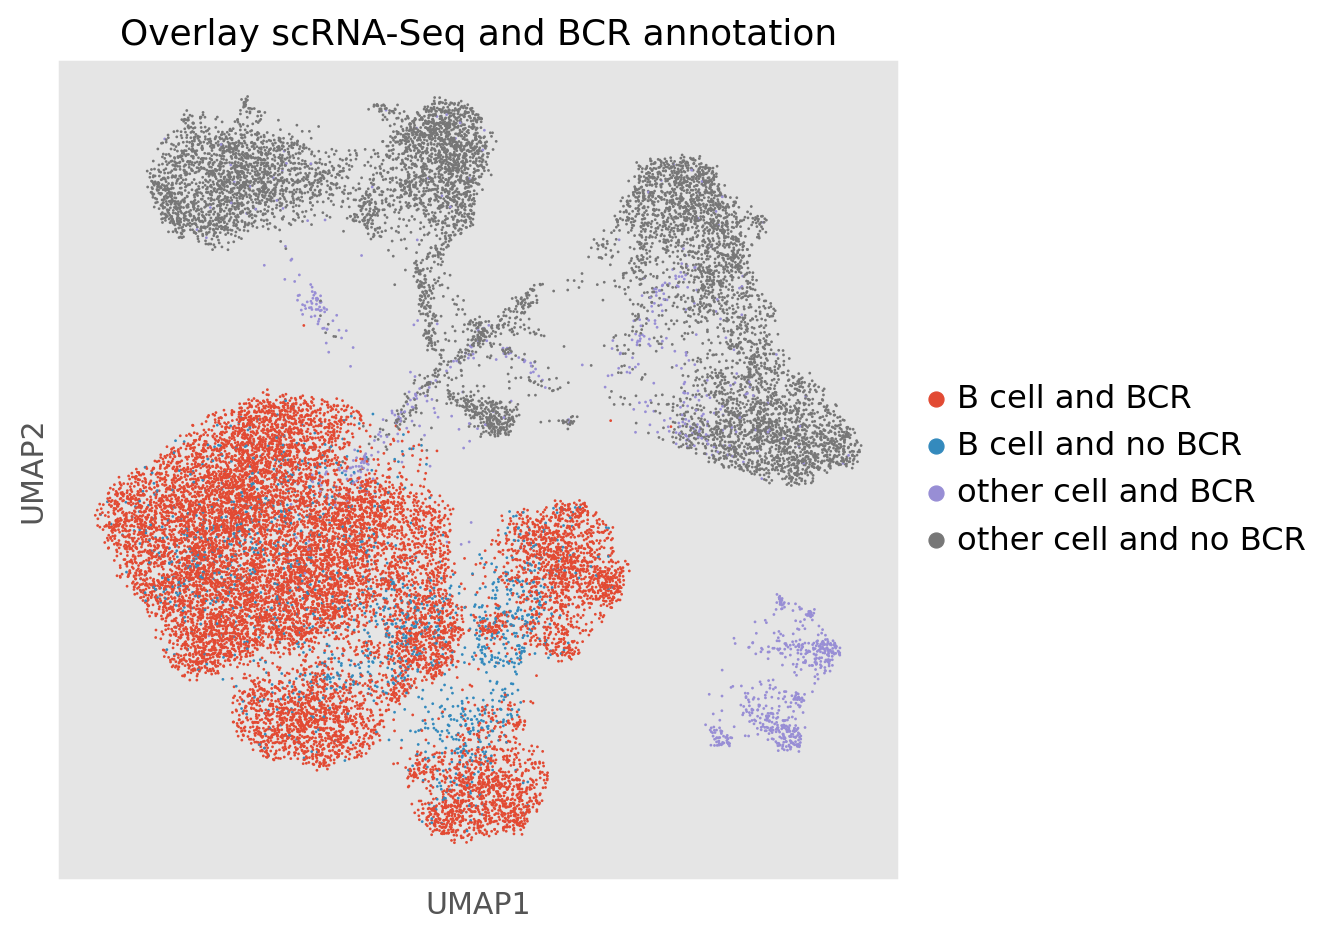

In [56]:
sc.pl.umap(gex_adata, color='b_cell_bcr', title='Overlay scRNA-Seq and BCR annotation')

In [139]:
gex_adata.obs['b_cell_bcr'].value_counts().sort_index()

B cell and BCR           13514
B cell and no BCR         1626
other cell and BCR        1063
other cell and no BCR     8104
Name: b_cell_bcr, dtype: int64

Text(0, 0.5, '')

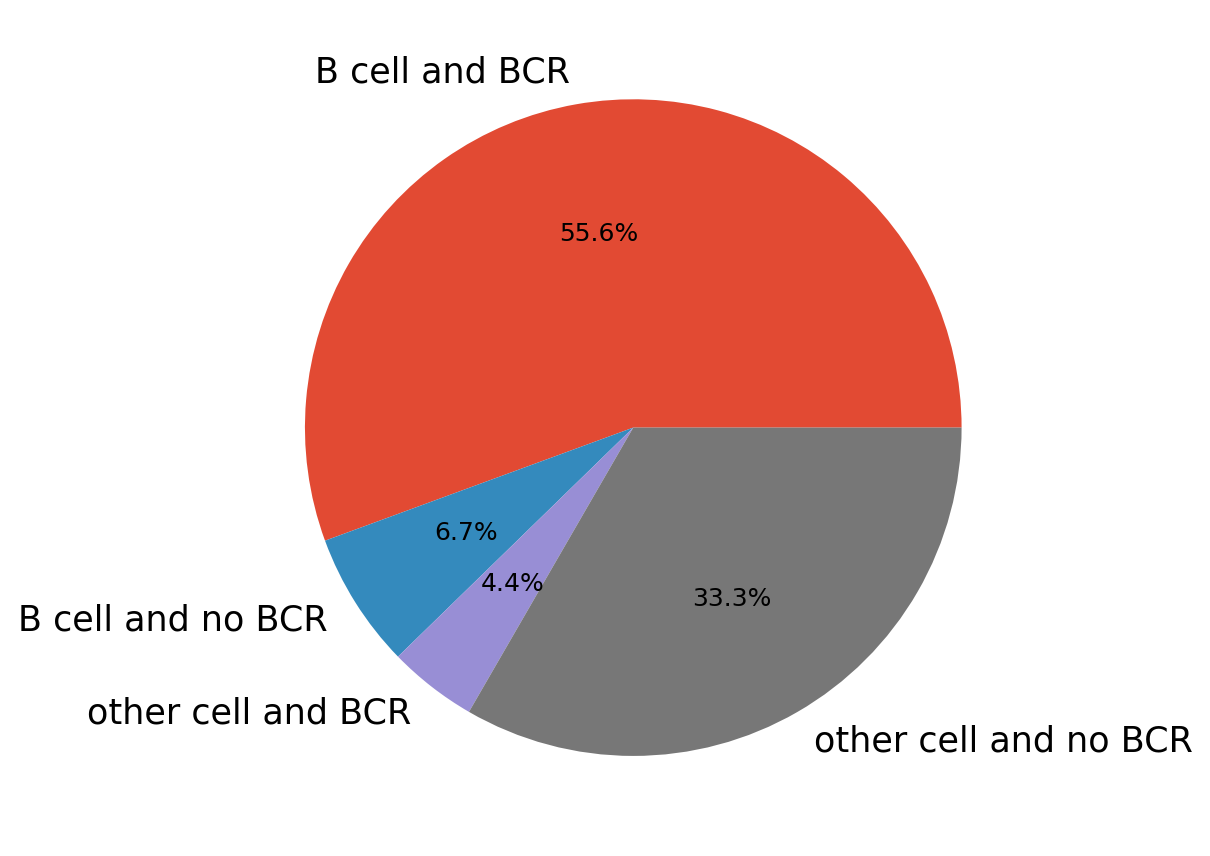

In [140]:
ax = gex_adata.obs['b_cell_bcr'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%')
ax.set_ylabel('')

#### QC of BCR-Seq corrected cell types

In [ ]:
# sub_adata = adata[:,adata.var.query('feature_types == "Gene Expression"').index].copy()
# sce.pp.scrublet(sub_adata, batch_key='sample')

# # detect doublet
# sub_adata = adata[:,adata.var.query('feature_types == "Gene Expression"').index].copy()
# sce.pp.scrublet(sub_adata, batch_key='sample')
# gex_adata.obs = pd.merge(gex_adata.obs, sub_adata.obs[['predicted_doublet']], left_index=True, right_index=True, how='left')
# gex_adata.obs['init_cell_type'].value_counts()

# # add column predicted_doublet
# b_adata.obs = pd.merge(b_adata.obs, sub_adata.obs[['predicted_doublet']], left_index=True, right_index=True, how='left')
# b_adata.obs['predicted_doublet'] = b_adata.obs['predicted_doublet'].map(lambda x: 'doublet' if x else 'singlet')
# print('stats of doublet cells')
# b_adata.obs['predicted_doublet'].value_counts()
# # check doublet stats of corrected cells 
# miss_doublet = b_adata[miss_class_cells,:].obs.query('predicted_doublet == "doublet"')['init_cell_type'].index
# b_adata[miss_class_cells,:].obs.query('predicted_doublet == "doublet"')['init_cell_type'].value_counts()

# # check marker gene expression, between expression and 
# cell = 'Plasma'
# marker_genes = ['TNFRSF17','MS4A1']
# cell_adata = gex_adata[gex_adata.obs['init_cell_type']==cell,:].copy()
# cell_adata.obs['bcr_correct'] = cell_adata.obs.apply(lambda row:'True' if row['init_cell_type'] != row['cell_type'] else 'False', axis=1)

# # show marker gene expression
# axes = sc.pl.violin(cell_adata, keys=marker_genes, groupby='bcr_correct', show=False)
# try:
#     for ax in axes:
#         ax.set_title(cell)
# except:
#     axes.set_title(cell)
# # show 
# gex_adata.obs['bcr_correct'] = gex_adata.obs.apply(lambda row: 'Yes' if row['init_cell_type'] != row['cell_type'] else 'No', axis=1)
# gex_adata.obs['bcr_correct'] = gex_adata.obs.apply(lambda row: 'B cell' if row['init_cell_type'] == 'B cell' else row['bcr_correct'], axis=1)

# # other_cell_adata = gex_adata[gex_adata.obs['init_cell_type'].isin(['DC','T cell','NK']),:]
# sc.pl.umap(gex_adata, color=['bcr_correct'])

##### CITE-Seq data

In [ ]:
ab_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/ab_adata.h5ad')
b_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/b_adata_rm_Ig_vari.h5ad')

mdata = mu.MuData({'rna': b_adata, 'prot': ab_adata})
mu.pp.intersect_obs(mdata)

In [ ]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=['IgM','IgD','CD11c'])

## 2. group abundance

In [ ]:
ax = ir.pl.group_abundance(gex_adata, groupby="receptor_subtype", target_col="cell_type")
ax = ir.pl.group_abundance(bcr_adata, groupby="receptor_subtype", target_col="cell_type")
ax = ir.pl.group_abundance(gex_adata, groupby="chain_pairing", target_col="cell_type")
ax = ir.pl.group_abundance(bcr_adata, groupby="chain_pairing", target_col="cell_type")

In [ ]:
ax = ir.pl.group_abundance(gex_adata, groupby="receptor_subtype", target_col="condition")
ax = ir.pl.group_abundance(bcr_adata, groupby="receptor_subtype", target_col="condition")
ax = ir.pl.group_abundance(gex_adata, groupby="chain_pairing", target_col="condition")
ax = ir.pl.group_abundance(bcr_adata, groupby="chain_pairing", target_col="condition")

In [ ]:
print("Fraction of cells with more than one pair of BCRs: {:.2f}".format(
        np.sum(bcr_adata.obs["chain_pairing"].isin(
                ["extra VJ", "extra VDJ", "two full chains"]
            )
        )
        / bcr_adata.n_obs
    )
)

In [ ]:
bcr_adata = bcr_adata[bcr_adata.obs["chain_pairing"] != "multichain", :].copy()
bcr_adata = bcr_adata[~bcr_adata.obs["chain_pairing"].isin(["orphan VDJ", "orphan VJ"]), :].copy()

## 3. Clonotype defination
### 3.1 Calculate based on the nt sequence

In [ ]:
ir.pp.ir_dist(b_iga_adata)
ir.tl.define_clonotypes(b_iga_adata, receptor_arms="all", dual_ir="primary_only")

In [ ]:
ir.tl.clonotype_network(b_iga_adata, min_cells=2)

In [ ]:
b_iga_adata.obs.head()

In [ ]:
ir.pl.clonotype_network(b_iga_adata, color="condition", base_size=20, label_fontsize=9, panel_size=(7, 7))

In [ ]:
bcr_adata.obs.head()

### 3.2 Calculate based on the aa sequence

In [ ]:
ir.pp.ir_dist(bcr_adata, metric="alignment", sequence="aa", cutoff=15)

In [ ]:
ir.tl.define_clonotype_clusters(bcr_adata, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any")
ir.tl.clonotype_network(bcr_adata, min_cells=3, sequence="aa", metric="alignment")

In [ ]:
ir.pl.clonotype_network(bcr_adata, color="cell_type", label_fontsize=9, panel_size=(7, 7), base_size=20)

In [ ]:
ir.pl.clonotype_network(bcr_adata, color="condition", label_fontsize=9, panel_size=(7, 7), base_size=20)

In [ ]:
ir.pl.clonotype_network(bcr_adata, color="sample", label_fontsize=9, panel_size=(7, 7), base_size=20)

In [ ]:
bcr_adata.obs['sample'].value_counts()

In [ ]:
bcr_adata.obs.loc[bcr_adata.obs["cc_aa_alignment"] == "877", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        # "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        # "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

In [ ]:
bcr_adata.obs.loc[bcr_adata.obs["cc_aa_alignment"] == "2706", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        # "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        # "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

### 3.3 Including the V-gene in clonotype definition

In [ ]:
ir.tl.define_clonotype_clusters(bcr_adata, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any", same_v_gene=True,
    key_added="cc_aa_alignment_same_v")

In [ ]:
# find clonotypes with more than one `clonotype_same_v`
ct_different_v = bcr_adata.obs.groupby("cc_aa_alignment").apply(
    lambda x: x["cc_aa_alignment_same_v"].nunique() > 1)
ct_different_v = ct_different_v[ct_different_v].index.values.tolist()
print(ct_different_v)

In [ ]:
bcr_adata.obs.loc[bcr_adata.obs["cc_aa_alignment"].isin(ct_different_v),
    [   "cc_aa_alignment",
        "cc_aa_alignment_same_v",
        "IR_VJ_1_v_call",
        "IR_VDJ_1_v_call"]].sort_values("cc_aa_alignment").drop_duplicates().reset_index(drop=True)

### 3.4 Clonal expansion

In [ ]:
ir.tl.clonal_expansion(bcr_adata)

In [ ]:
sc.pl.umap(bcr_adata, color=["clonal_expansion", "clone_id_size"])

In [ ]:
ir.pl.clonal_expansion(bcr_adata, groupby="cell_type", clip_at=4, normalize=False)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
mdata.write(f'{work_dir}/inter_h5ad/rna_prot_bcr.h5mu')

# DE analysis
## 1. RNA level: DE for IgA+ B cells between IgAN and control

In [11]:
import gseapy
mdata = mu.read_h5mu(f'{work_dir}/inter_h5ad/rna_prot_bcr.h5mu')
gex_adata = mdata['rna']
gex_adata.uns['log1p']["base"] = None

In [71]:
# extract iga_positive B cells
iga_adata = gex_adata[gex_adata.obs.query('IgA == "IgA+" and cell_type == "B cell"').index,:].copy()

In [ ]:
print('IgA+ B cell distribution')
fig, axes = plt.subplots(1,2, figsize=(16,6))
iga_adata.obs.groupby(['leiden_r0.5','sample']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0])
iga_adata.obs.groupby(['leiden_r0.5','condition']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1])

In [ ]:
print('IgA+ B cell distribution')
fig, axes = plt.subplots(1,2, figsize=(16,6))
iga_adata.obs.query('condition == "IgAN"').groupby(['leiden_r0.5','sample']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0])
iga_adata.obs.query('condition == "control"').groupby(['leiden_r0.5','sample']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1])

#### 1.1 DE analysis using wilcoxon test

In [ ]:
iga_adata.obs['condition'].value_counts()

In [ ]:
iga_adata.obs[['leiden_r0.5','condition']].value_counts().unstack()

In [ ]:
key = "IgAN_vs_Ctrl_wilcoxon"
sc.tl.rank_genes_groups(iga_adata, 'condition', reference='control', method='wilcoxon', pts=True, key_added = key)

In [ ]:
result = iga_adata.uns[key]
groups = result['names'].dtype.names
de_df = pd.DataFrame({group + '_' + key: result[key][group] for group in groups for key in ['names', 'logfoldchanges','scores','pvals','pvals_adj']})
pts_df = result['pts']
pts_df.columns = ['pts_' + c for c in pts_df.columns]

In [ ]:
de_path = f'{work_dir}/DE'
os.makedirs(de_path, exist_ok=True)
de_fn = f'{de_path}/IgA+_B_cell_IgAN_vs_ctrl_wilcoxon.tsv'
de_df.to_csv(de_fn,sep='\t', index=False)

In [ ]:
# stats
up_sig_df = de_df.query('IgAN_logfoldchanges > 1 and IgAN_pvals_adj < 0.05')
dn_sig_df = de_df.query('IgAN_logfoldchanges < -1 and IgAN_pvals_adj < 0.05')
print('up genes',up_sig_df.shape[0])
print('dn genes',dn_sig_df.shape[0])

#### 1.2 GO term analysis

In [ ]:
up_glist = sc.get.rank_genes_groups_df(iga_adata, group='IgAN', key=key,pval_cutoff=0.05, log2fc_min=1)['names'].squeeze().str.strip().tolist()
dn_glist = sc.get.rank_genes_groups_df(iga_adata, group='IgAN', key=key,pval_cutoff=0.05, log2fc_max=-1)['names'].squeeze().str.strip().tolist()

In [ ]:
up_enr = gseapy.enrichr(gene_list=up_glist, organism='Human', gene_sets='GO_Biological_Process_2021', cutoff = 0.5)
dn_enr = gseapy.enrichr(gene_list=dn_glist, organism='Human', gene_sets='GO_Biological_Process_2021', cutoff = 0.5)

In [ ]:
# gseapy.dotplot(up_enr.res2d, figsize=(4,5), title="Up GO_Biological_Process_2021", cmap = plt.cm.autumn_r)
# gseapy.dotplot(dn_enr.res2d, figsize=(4,5), title="Down GO_Biological_Process_2021", cmap = plt.cm.autumn_r)

In [ ]:
print('up genes')
gseapy.barplot(up_enr.res2d,title='GO_Biological_Process_2021')
print('down genes')
gseapy.barplot(dn_enr.res2d,title='GO_Biological_Process_2021')

#### 1.3 Gene Set enrichment analysis

In [ ]:
gene_rank = sc.get.rank_genes_groups_df(iga_adata, group='IgAN', key=key)[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

In [ ]:
# calculate_qc_metrics will calculate number of cells per gene
sc.pp.calculate_qc_metrics(iga_adata, percent_top=None, log1p=False, inplace=True)
# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(iga_adata.var_names[iga_adata.var.n_cells_by_counts>30])]

In [ ]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
res = gseapy.prerank(rnk=gene_rank, gene_sets='KEGG_2021_Human')
terms = res.res2d.Term
gsea_fn = f'{de_path}/IgA+_B_cell_IgAN_vs_Ctrl_wilcoxon_gsea.tsv'
res.res2d.to_csv(gsea_fn, sep='\t', index=False)

In [ ]:
gene_set_names = gseapy.get_library_name(organism='Human')
res = gseapy.prerank(rnk=gene_rank, gene_sets='Reactome_2022')
terms = res.res2d.Term
gsea_fn = f'{de_path}/IgA+_B_cell_IgAN_vs_Ctrl_wilcoxon_gsea_reactome.tsv'
res.res2d.to_csv(gsea_fn, sep='\t', index=False)

## 2. DE for IgA+ B cells between IgAN and control at Protein level

In [ ]:
ab_adata = mdata['prot']
ab_adata = ab_adata[mdata.obs.query('`rna:IgA` == "IgA+" and `rna:cell_type` == "B cell"').index,:].copy()

### 2.1 DE analysis using wilcoxon test

In [ ]:
key = "IgAN_vs_Ctrl_wilcoxon"
sc.tl.rank_genes_groups(ab_adata, 'condition', reference='control', method='wilcoxon', pts=True, key_added = key)

In [ ]:
result = ab_adata.uns[key]
groups = result['names'].dtype.names
de_df = pd.DataFrame({group + '_' + key: result[key][group] for group in groups for key in ['names', 'logfoldchanges','scores','pvals','pvals_adj']})
pts_df = result['pts']
pts_df.columns = ['pts_' + c for c in pts_df.columns]

In [ ]:
de_path = f'{work_dir}/DE'
os.makedirs(de_path, exist_ok=True)
de_fn = f'{de_path}/IgA+_B_cell_IgAN_vs_ctrl_prot_wilcoxon.tsv'
de_df.to_csv(de_fn,sep='\t', index=False)

In [ ]:
# stats
up_sig_df = de_df.query('IgAN_logfoldchanges > 0.58 and IgAN_pvals_adj < 0.05')
dn_sig_df = de_df.query('IgAN_logfoldchanges < -0.58 and IgAN_pvals_adj < 0.05')
print('up genes',up_sig_df.shape[0])
print('dn genes',dn_sig_df.shape[0])

In [ ]:
plot_genes = ['CD62L','CD36-1','IgD','CD41']

In [ ]:
sc.pl.rank_genes_groups_violin(ab_adata, groups='IgAN', gene_names=plot_genes, key=key, show=False)

# miloR

In [107]:
import milopy
import milopy.core as milo
b_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/b_adata_rm_Ig_vari.h5ad')
b_adata.uns['log1p']["base"] = None
b_adata.obs['cond_sp'] = b_adata.obs.apply(lambda x: x['condition'] + '_' + x['sample'].split('_')[0] ,axis=1)
b_iga_adata_milo = b_adata[b_adata.obs.query('IgA == "IgA+"').index,:].copy()

In [130]:
## Build KNN graph
sc.pp.neighbors(b_iga_adata_milo, n_neighbors=10, use_rep='X_pca_harmony')
## Assign cells to neighbourhoods
milo.make_nhoods(b_iga_adata_milo)
## Count cells from each sample in each nhood
milo.count_nhoods(b_iga_adata_milo, sample_col="cond_sp")
## Test for differential abundance between conditions
milo.DA_nhoods(b_iga_adata_milo, design="~ condition")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [142]:
## Check results
milo_results = b_iga_adata_milo.uns["nhood_adata"].obs
milo_results['logFC'] = - milo_results['logFC']
milo_results = pd.merge(milo_results, b_iga_adata_milo.obs[['condition','sample','cond_sp','Bcell_leiden_r0.5']], how='left', left_on='index_cell',right_index=True)

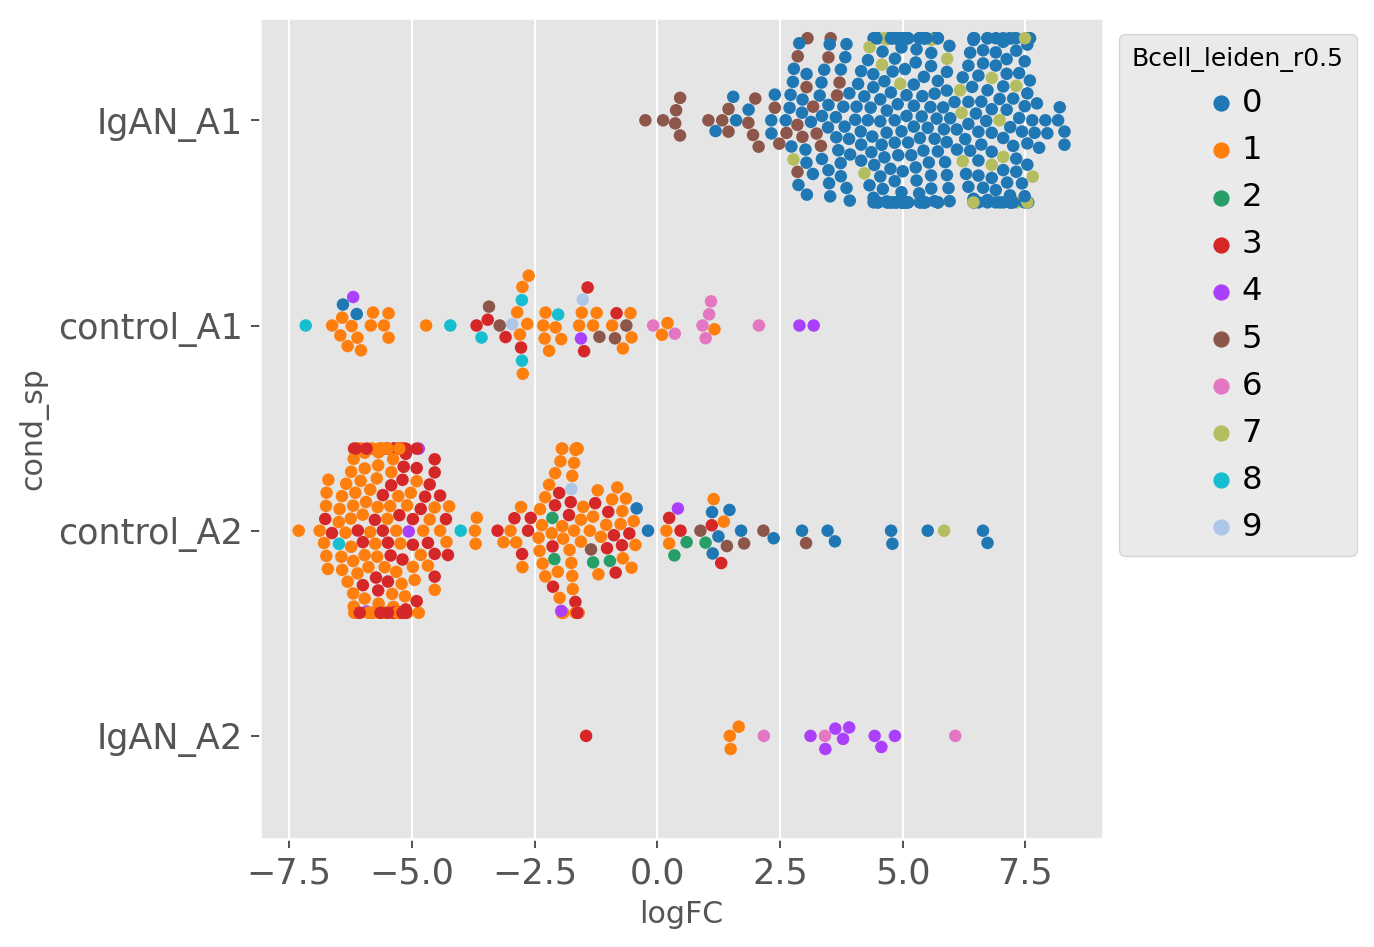

In [203]:
# ax = sb.swarmplot(data=milo_results, x="logFC", y="Bcell_leiden_r0.5",hue='cond_sp')
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.figure()
color = sc.pl.palettes.default_20[:10]
# color = list(sb.color_palette().as_hex())
ax = sb.swarmplot(data=milo_results, x="logFC", y="cond_sp",hue='Bcell_leiden_r0.5',palette=color)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# plt.figure()
# ax = sb.swarmplot(data=milo_results, x="logFC", y="sample",hue='cond_sp')
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [146]:
# milopy.utils.build_nhood_graph(b_iga_adata_milo)
# milopy.plot.plot_nhood_graph(b_iga_adata_milo, alpha=0.2, min_size=5)

# Analyze B cell separately
## 1. Normalize and batch correction

In [32]:
b_adata = gex_adata[gex_adata.obs.query('cell_type == "B cell"').index,:].copy()
b_adata.X = b_adata.raw.X.copy()

In [ ]:
# get IG variable gene names
rm_genes = [g for g in b_adata.var.index if g[:4] in ['IGLV','IGLJ']] +  \
           [g for g in b_adata.var.index if g[:4] in ['IGKV','IGKJ']] + \
           [g for g in b_adata.var.index if g[:4] in ['IGHV','IGHJ','IGHD']]
rm_genes.remove('IGHD') # IGHD is the constant reion, so don't remove this gene
sub_genes =[g for g in b_adata.var.index if g not in rm_genes]
b_adata = b_adata[:,sub_genes].copy()
b_adata.raw = b_adata
# # subset b_adata using genes expressed in at least 20 cells
sc.pp.filter_genes(b_adata, min_cells=20)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
b_adata.obs.groupby(['sample','condition']).size().unstack().plot(kind='bar',stacked=True, ax=axes[0])
b_adata.obs.groupby(['sample','condition']).size().unstack().apply(lambda x: x/sum(x), axis=1).plot(kind='bar',stacked=True, ax=axes[1])

The figure shows the 

In [ ]:
b_adata.obs.groupby(['sample','condition']).size().unstack().apply(lambda x: x/sum(x), axis=1).round(2)

In [ ]:
sc.pp.highly_variable_genes(b_adata, flavor='seurat', n_bins=50)
# pca
n_pc=20
sc.tl.pca(b_adata, n_comps=n_pc, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(b_adata, n_pcs=n_pc)
# batch correct
sce.pp.harmony_integrate(b_adata, 'sample', max_iter_harmony=15)

## 2. UMAP and clustering

In [ ]:
# Calculate the UMAP using harmany
sc.pp.neighbors(b_adata, use_rep = 'X_pca_harmony',key_added='hmny')
sc.tl.umap(b_adata, neighbors_key='hmny')
sc.pl.umap(b_adata, color='n_counts')

In [ ]:
# recluster the cells
bcell_cluster_key = 'Bcell_leiden_r0.5'
sc.tl.leiden(b_adata, key_added=bcell_cluster_key, resolution=0.5, neighbors_key='hmny')

In [ ]:
sc.pl.umap(b_adata, color=[bcell_cluster_key, 'leiden_r0.5'], palette=sc.pl.palettes.default_102, legend_loc='on data',alpha=0.5)

In [ ]:
# overlay initial cell type annotation (before BCR correction) to the new B cell clusters
sc.pl.umap(b_adata, color=['init_cell_type'], palette=sc.pl.palettes.default_102)

In [ ]:
bcell_rank_key = 'rank_genes_r0.5'
sc.tl.rank_genes_groups(b_adata, groupby=bcell_cluster_key, key_added=bcell_rank_key, method='wilcoxon')

In [ ]:
# sc.set_figure_params(dpi=150)
sc.pl.rank_genes_groups_dotplot(b_adata, n_genes=5, key='rank_genes_r0.5')
# sc.set_figure_params(dpi=90)
# plt.style.use('ggplot')

## 3. B cell annotation 

In [ ]:
b_init_cell_anno = sctool.scsa_cell_anno(b_adata, rank_key=bcell_rank_key, clust_col=bcell_cluster_key, species='Human',tissue='Blood', tmp_dir=work_dir)

In [ ]:
# extract marker gene
de_df = sctool.get_cluster_markers(b_adata, key='rank_genes_r0.5')
# output to file
marker_path = f'{work_dir}/cluster_marker'
os.makedirs(marker_path, exist_ok=True)
b_de_fn = f'{marker_path}/Bcell_cluster_markers_rm_Ig_vari.tsv'
de_df.to_csv(b_de_fn, sep='\t', index=False)

In [ ]:
sc.pl.umap(b_adata, color=['condition','IgA','sample'], palette=sc.pl.palettes.default_20)

In [ ]:
sc.pl.umap(b_adata, color=['phase'], palette=sc.pl.palettes.default_20)

In [ ]:
# save b cell scanpy object to a file
os.makedirs(f'{work_dir}/inter_h5ad', exist_ok=True)
b_adata.write(f'{work_dir}/inter_h5ad/b_adata.h5ad')

In [ ]:
b_adata.write(f'{work_dir}/inter_h5ad/b_adata_rm_Ig_vari.h5ad')

In [ ]:
b_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/b_adata_rm_Ig_vari.h5ad')

In [ ]:
sc.pl.umap(b_adata, color=['IGHD','CD27','CD38'])

### 3.1 decoupler methods
This is to annotated cell types

In [ ]:
import decoupler as dc
expr_bdata = b_adata.copy()

In [ ]:
# markers = dc.get_resource('PanglaoDB')
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]
# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]

dc.run_ora(mat=expr_bdata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True)
acts = dc.get_acts(expr_bdata, obsm_key='ora_estimate')
mean_enr = dc.summarize_acts(acts, groupby='Bcell_leiden_r0.5', min_std=1)

### 3.2 Top marker genes pathway enrichment analysis

In [ ]:
# go term enrichment
subB_marker_df = sctool.get_cluster_markers(b_adata, bcell_rank_key)
nclusts = int(subB_marker_df.shape[1] / 5)

In [ ]:
marker_genes = {}
for c in range(nclusts):
    genes = subB_marker_df.query(f'`{c}_logfoldchanges` > 0.58 and `{c}_pvals_adj` < 0.05 and `{c}_names` in @expr_10genes')[f'{c}_names'].tolist()[:100]
    marker_genes[str(c)] = genes
# get numbers
marker_n = {}
for k,v in marker_genes.items():
    marker_n[k] = len(v)

In [ ]:
# marker_genes_df = pd.DataFrame(dict([(f'clust{k}_marker_genes',pd.Series(v)) for k,v in marker_genes.items()]))
# marker_genes_df.to_csv(f'{work_dir}/cluster_marker/Bcell_subcluster_marker_genes_for_enrichment_analysis_lfc.tsv', index=False, sep='\t')

In [ ]:
ax = pd.DataFrame.from_dict(marker_n, orient='index').plot(kind='bar', legend=False, figsize=(8,6))
ax.set_title('Number of top marker genes')
ax.set_xlabel('cluster')
ax.set_ylabel('gene number')
# ax.set_ylim(0,100)

In [ ]:
# this is customized code to split the raw plot
x = []; y=[]
for k,v in marker_n.items():
    x.append(k)
    y.append(v)
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True, figsize=(8,6))
ax2.bar(x, y)
ax2.set_ylim(0, 100)
ax2.set_xlabel('cluster')

ax1.bar(x, y)
ax1.set_ylim(450, 2300)
ax1.xaxis.set_ticks_position('none')
plt.subplots_adjust(hspace=0.07)
ax1.set_title('Number of significant marker genes for each cluster')

In [ ]:
rows = [f'{c}' for c in marker_genes.keys()]
cols = [f'{c}' for c in marker_genes.keys()]
clusts_genes_df = pd.DataFrame(index=rows, columns=cols)

In [ ]:
dtype = 'raw'
for i in range(len(rows)):
    row_genes = marker_genes[rows[i]]
    for j in range(len(cols)):
        col_genes = marker_genes[cols[j]]
        inter = len(set(row_genes).intersection(col_genes))
        
        if i != j:
            val = round(inter / len(row_genes), 2)
        # elif i < j:
        #     val = round(inter / len(col_genes), 2)
        #     print(val, inter, len(row_genes))
        elif i == j:
            val = 1
        if dtype == 'percent':
            clusts_genes_df.loc[rows[i],cols[j]] = val
        elif dtype == 'raw':
            clusts_genes_df.loc[rows[i],cols[j]] = inter
clusts_genes_df = clusts_genes_df.astype(float)

In [ ]:
# number of marker genes overlapped between each pair of clusters
fig, ax = plt.subplots(figsize=(10,8))
sb.heatmap(clusts_genes_df,annot=True,cmap='Blues',fmt='g')

In [ ]:
# this part runs 
go_dict = {}
for i in range(nclusts):
    enr = gp.enrichr(gene_list=marker_genes[str(i)], # or "./tests/data/gene_list.txt",
                     gene_sets= 'GO_Biological_Process_2021',  # ['GO_Biological_Process_2021'], # GO_Cellular_Component_2021, GO_Biological_Process_2021, 'MSigDB_Hallmark_2020'
                     organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                     outdir=None) # don't write to disk)
    go_dict[str(i)] = enr

In [ ]:
for i in range(nclusts):
    try:
        gp.dotplot(go_dict[str(i)].res2d, title=f'cluster{i} GO Biological Process',cmap='viridis_r', size=10, figsize=(3,5), cutoff=0.1)
    except:
        pass

In [ ]:
# # show the enrichment GO term 
# for i in range(15):
#     try:
#         dotplot(go_dict[str(i)].res2d, title=f'cluster{i}',cmap='viridis_r', size=10, figsize=(3,5), cutoff=0.1)
#     except:
#         pass

### 3.3 Remove cluster 11 and 14 and redo the marker gene detection

In [ ]:
rm_clust = ['11','14']
subB_adata = b_adata[b_adata.obs.query('`Bcell_leiden_r0.5` not in @rm_clust').index,:].copy()  # subB_adata  remove cluster 11 and 14
subB_adata.raw = subB_adata

In [ ]:
sc.tl.rank_genes_groups(subB_adata, groupby='Bcell_leiden_r0.5', key_added='rank_genes_r0.5')

In [ ]:
subB_marker_df = sctool.get_cluster_markers(subB_adata, 'rank_genes_r0.5')

In [ ]:
marker_genes = {}
for c in list(range(11)) + [12,13]:
    genes = subB_marker_df.query(f'`{c}_logfoldchanges` > 0.3 and `{c}_pvals_adj` < 0.05 and `{c}_names` in @expr_10genes')[f'{c}_names'].tolist()[:100]
    marker_genes[str(c)] = genes
# get numbers
marker_n = {}
for k,v in marker_genes.items():
    marker_n[k] = len(v)

In [ ]:
subB_marker_df = pd.DataFrame(dict([(f'clust{k}_marker_genes',pd.Series(v)) for k,v in marker_genes.items()]))
subB_marker_df.to_csv(f'{work_dir}/cluster_marker/Bcell_subcluster_marker_genes_for_enrichment_analysis_lfc_without_cluster_11_and_14_lfc_0.3.tsv', index=False, sep='\t')

In [ ]:
sc.tl.dendrogram(subB_adata, groupby=['Bcell_leiden_r0.5'])

In [ ]:
# plot marker genes for those IgA positive
# plot heatmap include only expressed genes
bmarker = sctool.get_cluster_markers(subB_adata, 'rank_genes_r0.5')
bmarker_dict = {}
for i in subB_adata.uns['rank_genes_r0.5']['names'].dtype.fields:
    sub = bmarker.query(f'`{i}_logfoldchanges` > 0.58 and `{i}_pvals_adj` < 0.05')[f'{i}_names'].tolist()
    bmarker_dict[i] = [g for g in sub if g in expr_10genes]

groups = [str(i) for i in bmarker_dict]
# groups = ['0', '1', '2', '3','4', '5', '6', '7', '8', '9', '10', '12', '13']
group_dict = {k:bmarker_dict[k][:6] for k in groups}

sc.pl.rank_genes_groups_matrixplot(subB_adata, key='rank_genes_r0.5', groups=groups,
                                   cmap='bwr', values_to_plot="logfoldchanges", var_names=group_dict, vmin=-5, vmax=5)

In [ ]:
subB_adata.obs['Bcell_leiden_r0.5'].value_counts()

## 3. Analyze IgA+ B cells
1. extract IgA+ B cells

In [178]:
b_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/b_adata_rm_Ig_vari.h5ad')
# b_adata.uns['log1p']["base"] = None
b_adata.obs['cond_sp'] = b_adata.obs.apply(lambda x: x['condition'] + '_' + x['sample'].split('_')[0] ,axis=1)
b_iga_adata = b_adata[b_adata.obs.query('IgA == "IgA+"').index,:].copy()

In [ ]:
bcell_cluster_key = 'Bcell_leiden_r0.5'
sc.pl.umap(b_iga_adata, color=bcell_cluster_key, palette=sc.pl.palettes.default_102, legend_loc='on data',alpha=0.6)

In [180]:
b_iga_adata.obs.groupby(['sample','condition']).size().unstack().apply(lambda x: x/sum(x), axis=1).round(2)

condition  IgAN  control
sample                  
A1_a       0.83     0.17
A1_b       0.84     0.16
A2_a       0.10     0.90
A2_b       0.12     0.88

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
b_iga_adata.obs.groupby(['sample','condition']).size().unstack().plot(kind='bar',stacked=True, ax=axes[0])
b_iga_adata.obs.groupby(['sample','condition']).size().unstack().apply(lambda x: x/sum(x), axis=1).plot(kind='bar',stacked=True, ax=axes[1])

The above figure shows that most IgAN cells are from A1 IgAN patients, and most control cells are from A2 control samples. This unbalance will need to be solved in the experimental stage in the future.

In [ ]:
sc.pl.umap(b_iga_adata, color=['condition'], palette=sc.pl.palettes.default_20)
sc.pl.umap(b_iga_adata, color=[bcell_cluster_key], palette=sc.pl.palettes.default_102, legend_loc='on data')

In [ ]:
# ax = b_iga_adata.obs.groupby(['Bcell_leiden_r0.5','condition']).size().unstack().plot(kind='bar',stacked=True, figsize=(8,6))
ax = b_iga_adata.obs.groupby([bcell_cluster_key,'sample']).size().unstack().apply(lambda x: x/sum(x),axis=1).plot(kind='bar',stacked=True, figsize=(8,6))
ax.set_xlabel('B cell cluster')
ax.set_ylabel('number of cells')
ax.set_title('cell distribution across cluster & condition')

In [ ]:
b_iga_adata.obs.groupby(['Bcell_leiden_r0.5','condition']).size().unstack().plot(kind='bar',figsize=(8,6))
b_iga_adata.obs.groupby(['Bcell_leiden_r0.5','condition']).size().unstack().plot(kind='bar',stacked=True, figsize=(8,6))
b_iga_adata.obs.groupby(['Bcell_leiden_r0.5','condition']).size().unstack().apply(lambda x: x/sum(x) , axis=1).plot(kind='bar', stacked=True, figsize=(8,6))

The above figure shows that each cluster has similar portion of cells from each run.

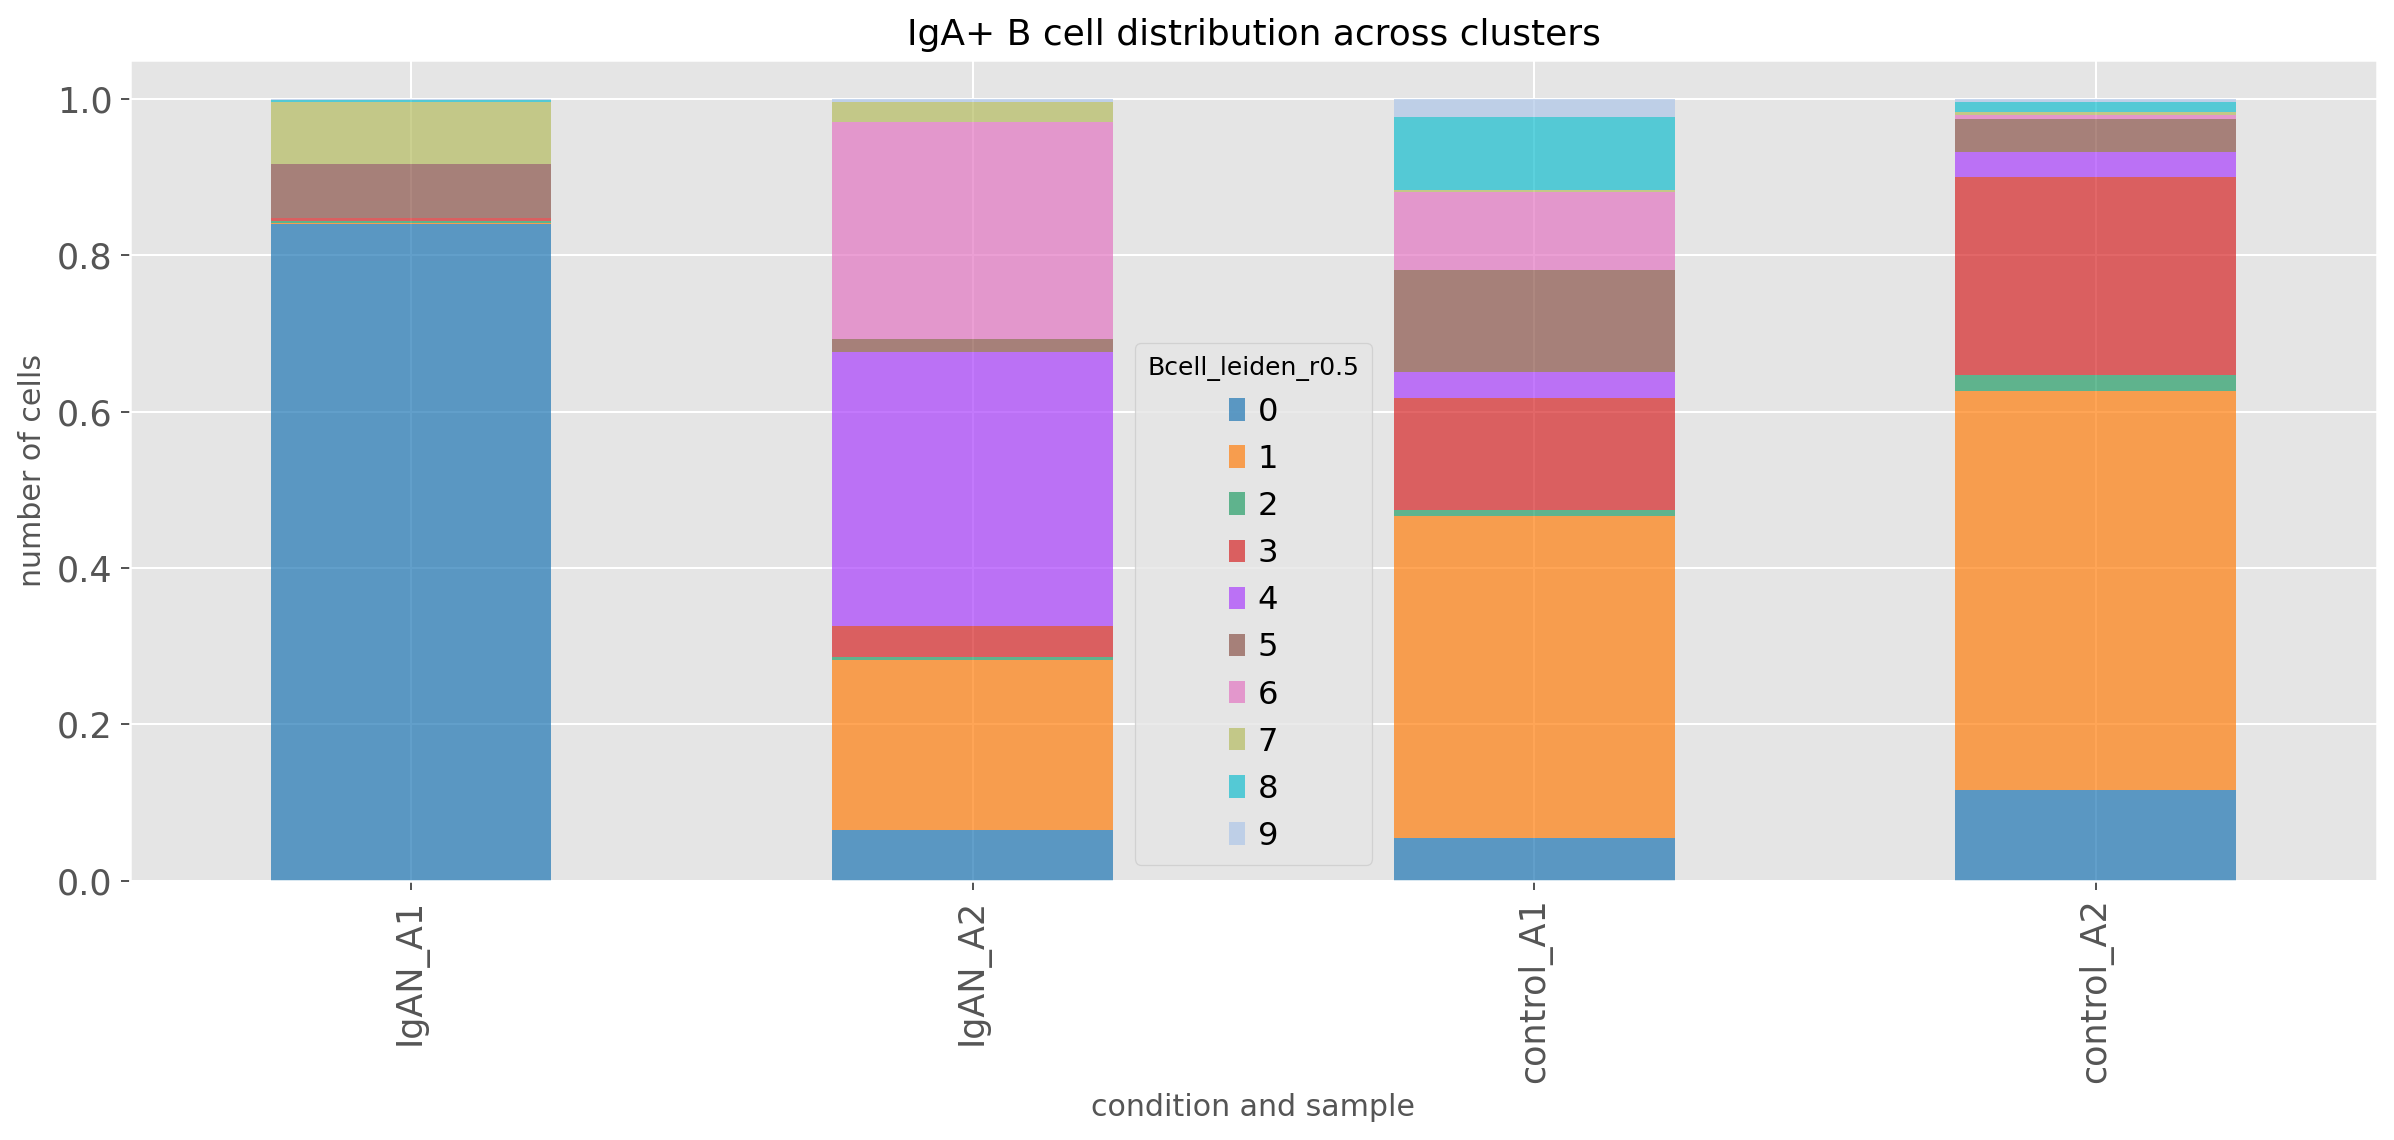

In [205]:
portion_df = b_iga_adata.obs.groupby(['cond_sp', 'Bcell_leiden_r0.5']).size().unstack().apply(lambda x: x/sum(x),axis=1)
color = color = sc.pl.palettes.default_20[:10] # sb.color_palette("tab20")  
ax = portion_df.plot(kind='bar',stacked=True, figsize=(16,6), color=color, alpha=0.7)
ax.set_xlabel('condition and sample')
ax.set_ylabel('number of cells')
ax.set_title('IgA+ B cell distribution across clusters')
portion_df = portion_df.T

The above figure shows the ditribution of cluster cell numbers in each sample. It shows that cluster 12 is mainly enriched in IgAN patient sample in A2. We run t-test on the cell portions between IgAN and control. The sample number is small, so no significant difference were found in any cluster.

In [ ]:
def ig_type(row):
    call1 = row['IR_VDJ_1_c_call']
    call2 = row['IR_VDJ_2_c_call']
    if isinstance(call1, str) and isinstance(call2, str) and (call1[:4] != call2[:4]):
        return 'ambiguous'
    call1 = str(call1)
    call2 = str(call2)
    if 'IGHA' in call1 or 'IGHA' in call2:
        return 'IgA'
    if 'IGHD' in call1 or 'IGHD' in call2:
        return 'IgD'
    if 'IGHG' in call1 or 'IGHG' in call2:
        return 'IgG'
    if 'IGHM' in call1 or 'IGHM' in call2:
        return 'IgM'
    
b_adata.obs['Ig_type'] = b_adata.obs.apply(lambda row: ig_type(row), axis=1)

In [ ]:
# ig type plot distribution
ax = b_adata.obs.groupby([bcell_cluster_key,'Ig_type']).size().unstack().plot(kind='bar', stacked=True, figsize=(10,6))
ax.set_title('Ig protein distribution in each cluster')
ax.set_xlabel('cluster id')
ax.set_ylabel('cell portion')

# ig type plot distribution
ax = b_adata.obs.groupby([bcell_cluster_key,'Ig_type']).size().unstack().apply(lambda x: x/sum(x),axis=1).plot(kind='bar', stacked=True, figsize=(10,6))
ax.set_title('Ig protein distribution in each cluster')
ax.set_xlabel('cluster id')
ax.set_ylabel('cell portion')

In [ ]:
# portion difference
import scipy
def t_test(row):
    score = scipy.stats.ttest_ind([row['IgAN_A1'],row['IgAN_A2']],[row['control_A1'],row['control_A2']])
    return score[1]

portion_df['ttest_pval'] = portion_df.apply(lambda row: t_test(row), axis=1)
portion_df = portion_df.round(2)

In [ ]:
# plot heatmap include only expressed genes,  mean expression
bmarker = sctool.get_cluster_markers(b_adata, bcell_rank_key)
bmarker_dict = {}
for i in b_adata.uns[bcell_rank_key]['names'].dtype.fields:
    sub = bmarker.query(f'`{i}_logfoldchanges` > 0.58 and `{i}_pvals_adj` < 0.05')[f'{i}_names'].tolist()
    bmarker_dict[i] = [g for g in sub if g in expr_10genes]
# groups = ['0','1','5','12']
groups = [str(i) for i in bmarker_dict]
group_dict = {k:bmarker_dict[k][:6] for k in groups}
sc.pl.rank_genes_groups_matrixplot(b_adata, key=bcell_rank_key,cmap='Greens',groups=groups, var_names=group_dict)

In [ ]:
# heatmap only consider 4 clusters
sc.pl.rank_genes_groups_matrixplot(b_iga_adata, n_genes=10, key='rank_genes_r0.5',cmap='Greens',groups=['0','1','5','12'])

In [ ]:
# heatmap column normalize
sc.pl.rank_genes_groups_matrixplot(b_iga_adata, n_genes=10, key='rank_genes_r0.5',standard_scale='var',cmap='Greens',groups=['0','1','5','12'],colorbar_title='column scaled\nexpression')

In [ ]:
# biga_marker_fn = f'{work_dir}/cluster_marker/Bcell_cluster_markers.tsv'
# biga_marker_df = pd.read_csv(biga_marker_fn, sep='\t', header=0)

In [ ]:
# plot heatmap include only expressed genes
bmarker = sctool.get_cluster_markers(b_iga_adata, bcell_rank_key)
bmarker_dict = {}
for i in b_iga_adata.uns[bcell_rank_key]['names'].dtype.fields:
    sub = bmarker.query(f'`{i}_logfoldchanges` > 0.58 and `{i}_pvals_adj` < 0.05')[f'{i}_names'].tolist()
    bmarker_dict[i] = [g for g in sub if g in expr_10genes]

groups = [str(i) for i in bmarker_dict]
# groups = ['0', '1', '2', '3','4', '5', '6', '7', '8', '9', '10', '12', '13']
group_dict = {k:bmarker_dict[k][:6] for k in groups}
sc.pl.rank_genes_groups_matrixplot(b_iga_adata, key=bcell_rank_key, groups=groups,
                                   cmap='bwr', values_to_plot="logfoldchanges", var_names=group_dict, vmin=-5, vmax=5, dendrogram=True)

In [ ]:
# B cell linearge genes
genes = ['IL7R','CD19','CD45','CD43','RAG1','RAG2','PAX5','SOX4','LEF1','CD34','CD38','CD24','TdT','CD179B','CD79A','EIF4EBP1','MS4A1','TNFRSF13C']
genes = list(set(genes).intersection(b_iga_adata.var.index))
sc.pl.heatmap(b_iga_adata, genes, groupby='Bcell_leiden_r0.5',swap_axes=True)

Compare cluster cells using different genes 

In [ ]:
sc.pl.umap(b_adata_10pct_genes, color='Bcell_leiden_r0.5')

In [ ]:
# compare clusters from B cell cluster using all genes Vs cluster using 10 pct genes
b_adata_all_genes = sc.read_h5ad(f'{work_dir}/inter_h5ad/b_adata.h5ad')
b_adata_10pct_genes = sc.read_h5ad(f'{work_dir}/inter_h5ad/b_adata_rm_Ig_vari.h5ad')

df1 = b_adata_all_genes.obs
df2 = b_adata_10pct_genes.obs
df = pd.merge(df1[['sample','Bcell_leiden_r0.5']],df2[['sample','Bcell_leiden_r0.5']], left_index=True, right_index=True)

In [ ]:
stat = df[['Bcell_leiden_r0.5_x','Bcell_leiden_r0.5_y']].value_counts().to_frame().reset_index()
stat.columns = ['old_cluster','new_cluster','cell_number']
stat = stat.pivot(index='new_cluster', columns='old_cluster', values='cell_number')
stat = stat.fillna(0)

In [ ]:
color = sc.pl.palettes.default_102[:15] #sb.color_palette("tab20")  
ax = stat.plot(kind='bar',stacked=True, figsize=(8,6), alpha=0.7, color=color)
ax.set_title('Cell number')
ax = stat.apply(lambda row: row/sum(row),axis=1).plot(kind='bar',stacked=True, figsize=(8,6), alpha=0.7, color=color)
ax.set_title('Cell portion')

### Trajectory analysis 
#### Using slingshot

In [ ]:
%%R -i adata_ent

#Plot 1
colour_map = c(brewer.pal(12,'Set3'), brewer.pal(3,'Set1'))
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(adata_ent)$PCA[,1], reducedDims(adata_ent)$PCA[,2], col=colour_map[colData(adata_ent)$Bcell_leiden_r0.5], bty='L', xlab='PC1', ylab='PC2')
legend(x=12, y=12, legend=unique(colData(adata_ent)$Bcell_leiden_r0.5), fill=colour_map[as.integer(unique(colData(adata_ent)$Bcell_leiden_r0.5))])
print("1:")
adata_ent_start <- slingshot(adata_ent, clusterLabels = 'Bcell_leiden_r0.5', reducedDim = 'PCA', start.clus='11')
print(SlingshotDataSet(adata_ent_start))

#### Using monocol2

In [ ]:
#Preprocessing for monocle
adata_ent = b_iga_adata.copy()
data_mat_mon = adata_ent.layers['counts'].T
var_mon=adata_ent.var.copy()
obs_mon=adata_ent.obs.copy()

In [ ]:
%%R -i data_mat_mon -i obs_mon -i var_mon

#Set up the CellDataSet data structure
pd <- AnnotatedDataFrame(data = obs_mon)
fd <- AnnotatedDataFrame(data = var_mon)
colnames(data_mat_mon) <- rownames(pd)
rownames(data_mat_mon) <- rownames(fd)
ie_regions_cds <- newCellDataSet(cellData=data_mat_mon, phenoData=pd, featureData=fd, expressionFamily=negbinomial.size())

#Normalize the count data
ie_regions_cds <- estimateSizeFactors(ie_regions_cds)

#Calculate dispersions to filter for highly variable genes
ie_regions_cds <- estimateDispersions(ie_regions_cds)


#Filter for Stem, EP, TA, and Enterocytes
cell_types = as.character(pData(ie_regions_cds)$Bcell_leiden_r0.5)
cell_mask = rep(FALSE, length(cell_types))
cells_to_keep = cell_types # c("Stem", "EP", "TA", "Enterocyte")
for (item in cells_to_keep) {cell_mask = cell_mask | startsWith(cell_types, item)}
print("Number of cells after filtering:")
print(sum(cell_mask))
print("")

#Filter highly variable genes from our analysis
hvg_mask = fData(ie_regions_cds)$highly_variable
ie_regions_cds <- ie_regions_cds[hvg_mask, cell_mask]

#Do dimensionality reduction
ie_regions_cds <- reduceDimension(ie_regions_cds, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)

#Run for the first time to get the ordering
ie_regions_cds <- orderCells(ie_regions_cds)

#Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$Bcell_leiden_r0.5)
id = which(colnames(tab1) == '5')
root_name = names(which.max(tab1[,id]))

#Run a second time to get the correct root state that overlaps with Stem cells
ie_regions_cds <- orderCells(ie_regions_cds, root_state=root_name)

In [ ]:
%%R -w 1000 -h 800

#Get a nice colour map
custom_colour_map = c(brewer.pal(12,'Set3'), brewer.pal(3,'Set1')) # brewer.pal(length(unique(pData(ie_regions_cds)$Bcell_leiden_r0.5)),'Paired')

#Find the correct root state that coresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$Bcell_leiden_r0.5)
id = which(colnames(tab1) == '5')
root_name = names(which.max(tab1[,id]))

# Visualize with our cluster labels
options(repr.plot.width=5, repr.plot.height=4)
plot_complex_cell_trajectory(ie_regions_cds, color_by = 'Bcell_leiden_r0.5', show_branch_points = T, 
                             cell_size = 2, cell_link_size = 1, root_states = c(root_name)) +
scale_size(range = c(0.2, 0.2)) +
theme(legend.position="left", legend.title=element_blank(), legend.text=element_text(size=rel(1.5))) +
guides(colour = guide_legend(override.aes = list(size=6))) + 
scale_color_manual(values = custom_colour_map)

### 3.1 DE analysis scRNA-Seq
#### 3.1.1 using wilcoxn test for each cluster
Here we use genes that are expressed in at least 10 percent of all the original cells

In [ ]:
concat_df, merge_df = sctool.clust_de_wilcoxon(b_iga_adata, 'Bcell_leiden_r0.5', 'condition', 'control', 'wilcoxn_IgA+_Bcell_igan_vs_ctrl')

In [ ]:
# merge data using the cluster 0 gene ranking
merge_df.index.name = 'Gene'
bde_res_path = f'{work_dir}/DE/Cluster_B_cells'
os.makedirs(bde_res_path, exist_ok=True)
merge_de_fn = f'{bde_res_path}/IgA+_Bcell_clusts_igan_vs_ctrl.tsv'
merge_df.to_csv(merge_de_fn, sep='\t')
# concat data keep the origin order
concat_de_fn = f'{bde_res_path}/IgA+_Bcell_clusts_igan_vs_ctrl_keep_origin_rank.tsv'
concat_df.to_csv(concat_de_fn, sep='\t', index=False)

Plot some statistics of DE results of wilcoxon methods

In [ ]:
log2fc = 1
pval = 0.05
up_n = []; dn_n = []
up_dict = {}; dn_dict = {}; other_dict = {}
for i in [str(i) for i in range(15)]:
    up = merge_df.query(f'clust{i}_logfoldchanges > {log2fc} and clust{i}_pvals_adj < {pval}')
    dn = merge_df.query(f'clust{i}_logfoldchanges < -{log2fc} and clust{i}_pvals_adj < {pval}')
    up_n.append(up.shape[0])
    dn_n.append(dn.shape[0])
    up_dict[i] = up.index
    dn_dict[i] = dn.index
    other_dict[i] = list(set(merge_df.index) - set(up.index) - set(dn.index))
df = pd.DataFrame({'up':up_n, 'down':dn_n})
ax = df.plot(kind='bar', figsize=(8,6))
ax.set_title('DE genes between IgAN and control for IgA+ B cells')
ax.set_xlabel('cluster')
ax.set_ylabel('number of DE genes')

Scatter plot of genes between conditions

In [ ]:
# get gene expression in IgAN and control
clust = b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories
rows = [c + '_igan' for c in clust] + [c + '_ctrl' for c in clust]

res = pd.DataFrame(columns=b_iga_adata.var_names, index=rows)
# get mean gene expression for each cluster
for cl in b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    ctrl = b_iga_adata[b_iga_adata.obs.query('`Bcell_leiden_r0.5` == @cl and condition == "control"').index,:]
    res.loc[f'{cl}_ctrl'] = ctrl.X.mean(0)
    igan = b_iga_adata[b_iga_adata.obs.query('`Bcell_leiden_r0.5` == @cl and condition == "IgAN"').index,:]
    res.loc[f'{cl}_igan'] = igan.X.mean(0)

In [ ]:
# scatter plot of gene expression in IgAN and control
row = 3
col = 5
fig, axes = plt.subplots(row,col, figsize=(20,12),sharex=False, sharey=False)

for cl in b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    x = f'{cl}_ctrl'
    y = f'{cl}_igan'
    
    n = int(cl)
    j = n % col
    i = n // col
    res.loc[[x,y],other_dict[cl]].T.plot(kind='scatter', x=x,y=y, color='grey', ax=axes[i,j], alpha=0.5)
    res.loc[[x,y],up_dict[cl]].T.plot(kind='scatter', x=x,y=y, color='r', ax=axes[i,j])
    res.loc[[x,y],dn_dict[cl]].T.plot(kind='scatter', x=x,y=y, color='b', ax=axes[i,j])
    axes[i,j].set_ylim(0,6)
    axes[i,j].set_xlim(0,6)
    axes[i,j].set_xlabel('')
    axes[i,j].set_ylabel('')
    axes[i,j].set_title(f'cluster_{cl}')
    axes[i,j].plot([0, 6], [0, 6], transform=axes[i,j].transAxes, ls='--', color='black')

MA plot

In [ ]:
# get mean expression of genes
clust = b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories
rows = [f'clust{c}_mean' for c in clust]

ma_df = pd.DataFrame(columns=b_iga_adata.var_names, index=rows)

# get mean gene expression for each cluster
for cl in b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    clst = b_iga_adata[b_iga_adata.obs.query('`Bcell_leiden_r0.5` == @cl').index,:]
    ma_df.loc[f'clust{cl}_mean',:] = clst.X.mean(0)
ma_df = ma_df.T
ma_df = pd.merge(merge_df, ma_df, how='left', left_index=True, right_index=True)

for cl in b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    ma_df[f'clust{cl}_pvals_adj'] = -np.log10(ma_df[f'clust{cl}_pvals_adj'])

In [ ]:
# MA plot,  logfoldchange  vs  mean expression
row = 3
col = 5
fig, axes = plt.subplots(row,col, figsize=(20,12),sharex=False, sharey=False)

for cl in b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    x = f'clust{cl}_mean'
    y = f'clust{cl}_logfoldchanges'
    
    n = int(cl)
    j = n % col
    i = n // col
    ma_df.loc[other_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='grey', ax=axes[i,j], alpha=0.5)
    ma_df.loc[up_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='r', ax=axes[i,j])
    ma_df.loc[dn_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='b', ax=axes[i,j])
    # axes[i,j].set_ylim(0,6)
    # axes[i,j].set_xlim(0,6)
    axes[i,j].set_xlabel('')
    axes[i,j].set_ylabel('')
    axes[i,j].set_title(f'cluster_{cl}')
    # axes[i,j].plot([0, 6], [0, 6], transform=axes[i,j].transAxes, ls='--', color='black')

Gene expressed in percent of cells

In [ ]:
# MA plot,  logfoldchange  vs  mean expression
row = 3
col = 5
fig, axes = plt.subplots(row, col, figsize=(20,12),sharex=False, sharey=False)

for cl in b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    x = f'clust{cl}_control_pts'
    y = f'clust{cl}_IgAN_pts'
    
    n = int(cl)
    j = n % col
    i = n // col
    ma_df.loc[other_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='grey', ax=axes[i,j], alpha=0.5)
    ma_df.loc[up_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='r', ax=axes[i,j])
    ma_df.loc[dn_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='b', ax=axes[i,j])
    # axes[i,j].set_ylim(0,6)
    # axes[i,j].set_xlim(0,6)
    axes[i,j].set_xlabel('')
    axes[i,j].set_ylabel('')
    axes[i,j].set_title(f'cluster_{cl}')
    # axes[i,j].plot([0, 6], [0, 6], transform=axes[i,j].transAxes, ls='--', color='black')

#### 3.1.2 using MAST for each cluster

In [153]:
def prep_anndata(adata_):
    def fix_dtypes(adata_):
        df = pd.DataFrame(adata_.X.A, index=adata_.obs_names, columns=adata_.var_names)
        df = df.join(adata_.obs)
        return sc.AnnData(df[adata_.var_names], obs=df.drop(columns=adata_.var_names))

    adata_ = fix_dtypes(adata_)
    sc.pp.filter_genes(adata_, min_cells=3)
    return adata_

In [167]:
%%R
find_de_MAST_RE <- function(adata_, test){
    # create a MAST object
    sca <- SceToSingleCellAssay(adata_, class = "SingleCellAssay")
    print("Dimensions before subsetting:")
    print(dim(sca))
    print("")
    # keep genes that are expressed in more than 10% of all cells
    sca <- sca[freq(sca)>0.1,]
    print("Dimensions after subsetting:")
    print(dim(sca))
    print("")
    # add a column to the data which contains scaled number of genes that are expressed in each cell
    cdr2 <- colSums(assay(sca)>0)
    colData(sca)$ngeneson <- scale(cdr2)
    # store the columns that we are interested in as factors
    label <- factor(colData(sca)$condition)
    # set the reference level
    label <- relevel(label, "control")
    colData(sca)$label <- label
    cluster <- factor(colData(sca)$Bcell_leiden_r0.5)
    colData(sca)$cluster <- cluster
    # same for donors (which we need to model random effects)
    replicate <- factor(colData(sca)$sample)
    colData(sca)$replicate <- replicate
    # create a group per condition-celltype combination
    colData(sca)$group <- paste0(colData(adata_)$condition, ".", colData(adata_)$Bcell_leiden_r0.5)
    colData(sca)$group <- factor(colData(sca)$group)
    # define and fit the model
    zlmCond <- zlm(formula = ~ngeneson + group + (1 | replicate), 
                   sca=sca, 
                   method='glmer', 
                   ebayes=F, 
                   strictConvergence=F,
                   fitArgsD=list(nAGQ = 0)) # to speed up calculations
    
    # perform likelihood-ratio test for the condition that we are interested in    
    summaryCond <- summary(zlmCond, doLRT=test)
    # get the table with log-fold changes and p-values
    summaryDt <- summaryCond$datatable
    result <- merge(summaryDt[contrast==test & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
                     summaryDt[contrast==test & component=='logFC', .(primerid, coef)],
                     by='primerid') # logFC coefficients
    # MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR
    result[,coef:=result[,coef]/log(2)]
    # do multiple testing correction
    result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    # result = result[result$FDR<0.01,, drop=F]

    result <- stats::na.omit(as.data.frame(result))
    return(result)
}

In [173]:
#Create new Anndata object for use in MAST with non-batch corrected data as before
adata_test = b_iga_adata.copy()
adata_test.X = adata_test.layers['counts'].copy()
sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.log1p(adata_test)
adata_test = prep_anndata(adata_test)

normalizing counts per cell
    finished (0:00:00)
filtered out 2 genes that are detected in less than 3 cells


In [ ]:
%%time
%%R -i adata_test -o mast_des
mast_des = list()
clusts = levels(colData(adata_test)$Bcell_leiden_r0.5)
for (i in clusts) {
    print(i)
    cl = adata_test[,colData(adata_test)$Bcell_leiden_r0.5 == i]
    test = paste0('groupIgAN.',i)
    res <- find_de_MAST_RE(cl, test)
    mast_des[[i]] = res
}

In [ ]:
for k,de in mast_des.items():
    mast_des[k].columns = [f'clust{k}_' + c for c in ['names','pvals','logfoldchanges','pvals_adj']]
mast_des = [mast_des[k] for k in mast_des]
mast_concat_df = pd.concat(mast_des, axis=1)
for de in mast_des:
    de.index = de.iloc[:,0]
    del de[de.columns[0]]

In [ ]:
# merge data using the cluster 0 gene ranking
mast_merge_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), mast_des)
mast_merge_df = mast_merge_df.sort_values('clust0_pvals_adj')
mast_merge_df.index.name = 'Gene'
bde_res_path = f'{work_dir}/DE/Cluster_B_cells'
os.makedirs(bde_res_path, exist_ok=True)
merge_de_fn = f'{bde_res_path}/MAST_IgA+_Bcell_clusts_igan_vs_ctrl.tsv'
mast_merge_df.to_csv(merge_de_fn, sep='\t')

In [ ]:
mast_concat_fn = f'{bde_res_path}/MAST_IgA+_Bcell_clusts_igan_vs_ctrl_keep_orign_rank.tsv'
mast_concat_df.to_csv(mast_concat_fn, sep='\t', index=False)

In [ ]:
ax, (up_dict, dn_dict, non_de_dict) = sctool.plot_rank_gene_de_num(mast_merge_df, ncol_clust=3, 
                                                title='MAST DE genes between IgAN and control for IgA+ B cells', lfc=0.58, padj=0.05)

MA plot

In [ ]:
# get mean expression of genes
clust = b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories
rows = [f'clust{c}_mean' for c in clust]

ma_df = pd.DataFrame(columns=b_iga_adata.var_names, index=rows)

# get mean gene expression for each cluster
for cl in b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    clst = b_iga_adata[b_iga_adata.obs.query('`Bcell_leiden_r0.5` == @cl').index,:]
    ma_df.loc[f'clust{cl}_mean',:] = clst.X.mean(0)
ma_df = ma_df.T
ma_df = pd.merge(mast_merge_df, ma_df, how='left', left_index=True, right_index=True)

for cl in b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    ma_df[f'clust{cl}_pvals_adj'] = -np.log10(ma_df[f'clust{cl}_pvals_adj'])

In [ ]:
# MA plot,  logfoldchange  vs  mean expression
row = 3
col = 5
fig, axes = plt.subplots(row,col, figsize=(20,12),sharex=False, sharey=False)

for cl in b_iga_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    x = f'clust{cl}_mean'
    y = f'clust{cl}_logfoldchanges'
    
    n = int(cl)
    j = n % col
    i = n // col
    ma_df.loc[non_de_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='grey', ax=axes[i,j], alpha=0.5)
    ma_df.loc[up_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='r', ax=axes[i,j])
    ma_df.loc[dn_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='b', ax=axes[i,j])
    axes[i,j].set_ylim(-2,2)
    axes[i,j].set_xlim(0,4)
    axes[i,j].set_xlabel('')
    axes[i,j].set_ylabel('')
    axes[i,j].set_title(f'cluster_{cl}')
    # axes[i,j].plot([0, 6], [0, 6], transform=axes[i,j].transAxes, ls='--', color='black')

Check DE gene overlap between clusters

In [ ]:
def de_gene_heatmap(dict2plot, dtype='raw'):
    '''plot heatmap for gene overlap between clusters of DE results'''
    rows = [f'{c}' for c in dict2plot.keys()]
    cols = [f'{c}' for c in dict2plot.keys()]
    de_clusts_genes_df = pd.DataFrame(index=rows, columns=cols)
    for i in range(len(rows)):
        row_genes = dict2plot[rows[i]]
        for j in range(len(cols)):
            col_genes = dict2plot[cols[j]]
            inter = len(set(row_genes).intersection(col_genes))

            if i != j:
                val = round(inter / len(row_genes), 2)
            # elif i < j:
            #     val = round(inter / len(col_genes), 2)
            #     print(val, inter, len(row_genes))
            elif i == j:
                val = 1
            if dtype == 'percent':
                de_clusts_genes_df.loc[rows[i],cols[j]] = val
            elif dtype == 'raw':
                de_clusts_genes_df.loc[rows[i],cols[j]] = inter
    de_clusts_genes_df = de_clusts_genes_df.astype(float)
    return de_clusts_genes_df

In [ ]:
pval = 0.05
lfc = 0.58
up_genes_dict = {}
dn_genes_dict = {}
de_genes_dict = {}
for i in range(15):
    cols = [c for c in mast_merge_df.columns if f'clust{i}' in c]
    clust_df = mast_merge_df[cols]
    up_genes = clust_df.query(f'clust{i}_pvals_adj < {pval} and clust{i}_logfoldchanges > {lfc}').index.tolist()
    dn_genes = clust_df.query(f'clust{i}_pvals_adj < {pval} and clust{i}_logfoldchanges < -{lfc}').index.tolist()
    up_genes_dict[f'{i}'] = up_genes
    dn_genes_dict[f'{i}'] = dn_genes
    de_genes_dict[f'{i}'] = up_genes + dn_genes

In [ ]:
dtype = 'raw'
up_clusts_genes_df = de_gene_heatmap(up_genes_dict, dtype)
dn_clusts_genes_df = de_gene_heatmap(dn_genes_dict, dtype)
de_clusts_genes_df = de_gene_heatmap(de_genes_dict, dtype)

In [ ]:
# up genes
plt.figure(figsize=(10,8))
ax = sb.heatmap(up_clusts_genes_df, annot=True,cmap='Blues',fmt='g',vmin=0,vmax=125)
ax.set(title='up genes in IgAN vs control')
# dn genes
plt.figure(figsize=(10,8))
ax = sb.heatmap(dn_clusts_genes_df, annot=True,cmap='Blues',fmt='g',vmin=0,vmax=125)
ax.set(title='dn genes in IgAN vs control')
# de genes
plt.figure(figsize=(10,8))
ax = sb.heatmap(de_clusts_genes_df, annot=True,cmap='Blues',fmt='g',vmin=0,vmax=125)
ax.set(title='de genes in IgAN vs control')

GSEA analysis for MAST DE analysis for each cluster

In [ ]:
def run_enrichr(genes, gene_sets=['GO_Biological_Process_2021'], organism='human', outdir=None):
    enr = gp.enrichr(gene_list=genes, # or "./tests/data/gene_list.txt",
                     gene_sets=gene_sets, # GO_Cellular_Component_2021, GO_Biological_Process_2021
                     organism=organism, # don't forget to set organism to the one you desired! e.g. Yeast
                     outdir=outdir) # don't write to disk)
    return enr

In [ ]:
pval = 0.05
lfc = 0.58
up_go_dict = {}
dn_go_dict = {}
for i in range(15):
    cols = [c for c in mast_merge_df.columns if f'clust{i}' in c]
    clust_df = mast_merge_df[cols]
    up_genes = clust_df.query(f'clust{i}_pvals_adj < {pval} and clust{i}_logfoldchanges > {lfc}').index.tolist()
    dn_genes = clust_df.query(f'clust{i}_pvals_adj < {pval} and clust{i}_logfoldchanges < -{lfc}').index.tolist()
    # up go term
    up_go_dict[str(i)] = run_enrichr(up_genes)
    dn_go_dict[str(i)] = run_enrichr(dn_genes)

In [ ]:
# up go term
for i in range(15):
    try:
        gp.dotplot(up_go_dict[str(i)].res2d, title=f'cluster{i}_up',cmap='viridis_r', size=10, figsize=(3,5), cutoff=0.1)
    except:
        pass

In [ ]:
# dn go term
for i in range(15):
    try:
        gp.dotplot(dn_go_dict[str(i)].res2d, title=f'cluster{i}_down',cmap='viridis_r', size=10, figsize=(3,5), cutoff=0.05)
    except:
        pass

#### 3.1.3 MAST DE analysis for combined IgAN and control

In [ ]:
%%R
run_mast <- function(adata_, test){
    # create a MAST object
    sca <- SceToSingleCellAssay(adata_, class = "SingleCellAssay")
    print("Dimensions before subsetting:")
    print(dim(sca))
    print("")
    # keep genes that are expressed in more than 10% of all cells
    sca <- sca[freq(sca)>0.1,]
    print("Dimensions after subsetting:")
    print(dim(sca))
    print("")
    # add a column to the data which contains scaled number of genes that are expressed in each cell
    cdr2 <- colSums(assay(sca)>0)
    colData(sca)$ngeneson <- scale(cdr2)
    # store the columns that we are interested in as factors
    label <- factor(colData(sca)$condition)
    # set the reference level
    label <- relevel(label, "control")
    colData(sca)$label <- label
    cluster <- factor(colData(sca)$Bcell_leiden_r0.5)
    colData(sca)$cluster <- cluster
    # same for donors (which we need to model random effects)
    replicate <- factor(colData(sca)$sample)
    colData(sca)$replicate <- replicate
    # create a group per condition-celltype combination
    colData(sca)$group <- paste0(colData(adata_)$condition)
    colData(sca)$group <- factor(colData(sca)$group)
    # define and fit the model
    zlmCond <- zlm(formula = ~ngeneson + group + (1 | replicate), 
                   sca=sca, 
                   method='glmer', 
                   ebayes=F, 
                   strictConvergence=F,
                   fitArgsD=list(nAGQ = 0)) # to speed up calculations
    
    # perform likelihood-ratio test for the condition that we are interested in    
    summaryCond <- summary(zlmCond, doLRT=test)
    # get the table with log-fold changes and p-values
    summaryDt <- summaryCond$datatable
    result <- merge(summaryDt[contrast==test & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
                     summaryDt[contrast==test & component=='logFC', .(primerid, coef)],
                     by='primerid') # logFC coefficients
    # MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR
    result[,coef:=result[,coef]/log(2)]
    # do multiple testing correction
    result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    # result = result[result$FDR<0.01,, drop=F]

    result <- stats::na.omit(as.data.frame(result))
    return(result)
}

In [154]:
#Create new Anndata object for use in MAST with non-batch corrected data as before
adata_test = b_iga_adata.copy()
adata_test.X = adata_test.layers['counts'].copy()
sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.log1p(adata_test)
rm_clusts = ['5', '8','9']
adata_test = adata_test[adata_test.obs.query('`Bcell_leiden_r0.5` not in @rm_clusts').index,:]
adata_test = prep_anndata(adata_test)

normalizing counts per cell
    finished (0:00:00)
filtered out 37017 genes that are detected in less than 3 cells


In [155]:
adata_test.obs['Bcell_leiden_r0.5'].value_counts()

0     1998
1     1357
2      951
4      808
11     536
6      495
7      411
12     368
10     346
13     301
14     145
3       85
Name: Bcell_leiden_r0.5, dtype: int64

In [ ]:
%%time
%%R -i adata_test -o mast_de
mast_de <- run_mast(adata_test, 'groupIgAN')

In [ ]:
mast_de.columns = ['names','pvals','logfoldchanges','pvals_adj']
mast_de = mast_de.sort_values('pvals_adj')
mast_de.to_csv(f'{work_dir}/DE/Cluster_B_cells/MAST_all_cells_IgA+_Bcell_clusts_igan_vs_ctrl_rm_Ig_vari.tsv', sep='\t', index=False)

In [ ]:
name = 'names'
logfc='logfoldchanges'
q_val = 'pvals_adj'
title = 'IgAN vs Control (scRNA-Seq)'

sctool.volcano(mast_de, name, logfc, q_val, 0.58, 0.05, work_dir, title, topN=0)

MA plot

In [156]:
pval = 0.05
log2fc = 0.58
ma_df = pd.DataFrame(columns=adata_test.var_names, index=['mean'])
# get mean expression of genes
ma_df.loc['mean',:] = adata_test.X.mean(0)
ma_df = ma_df.T
ma_df = pd.merge(mast_de, ma_df, how='left', left_on='names', right_index=True)
ma_df.index = ma_df['names']
# up, dn and non_de_gene
up = ma_df.query(f'pvals < {pval} and logfoldchanges > {log2fc}')['names'].tolist()
dn = ma_df.query(f'pvals < {pval} and logfoldchanges < -{log2fc}')['names'].tolist()
non_de = list(set(ma_df['names'].tolist()) - set(up) - set(dn))

In [ ]:
# plot
x = 'mean'
y = 'logfoldchanges'

fig, ax = plt.subplots()
ma_df.loc[non_de, [x,y]].plot(kind='scatter', x=x,y=y, color='grey', alpha=0.5, ax=ax)
ma_df.loc[up, [x,y]].plot(kind='scatter', x=x,y=y, color='r',ax=ax)
ma_df.loc[dn, [x,y]].plot(kind='scatter', x=x,y=y, color='b',ax=ax)
# axes[i,j].set_ylim(-2,2)
# axes[i,j].set_xlim(0,4)
ax.set_xlabel('mean expression')
ax.set_ylabel('log2foldchange')
ax.set_title(f'IgAN vs Control')

GO term analysis

In [158]:
pval = 0.05
log2fc = 0.58
mast_de_up_genes = mast_de.query(f'pvals < {pval} and logfoldchanges > {log2fc}')['names'].tolist()
mast_up_enr = gp.enrichr(gene_list=mast_de_up_genes, organism='Human', gene_sets='GO_Biological_Process_2021', cutoff = 0.5)

<Axes: title={'center': 'UP genes of IgAN vs Control (GO_Biological_Process_2021)'}, xlabel='Combined Score'>

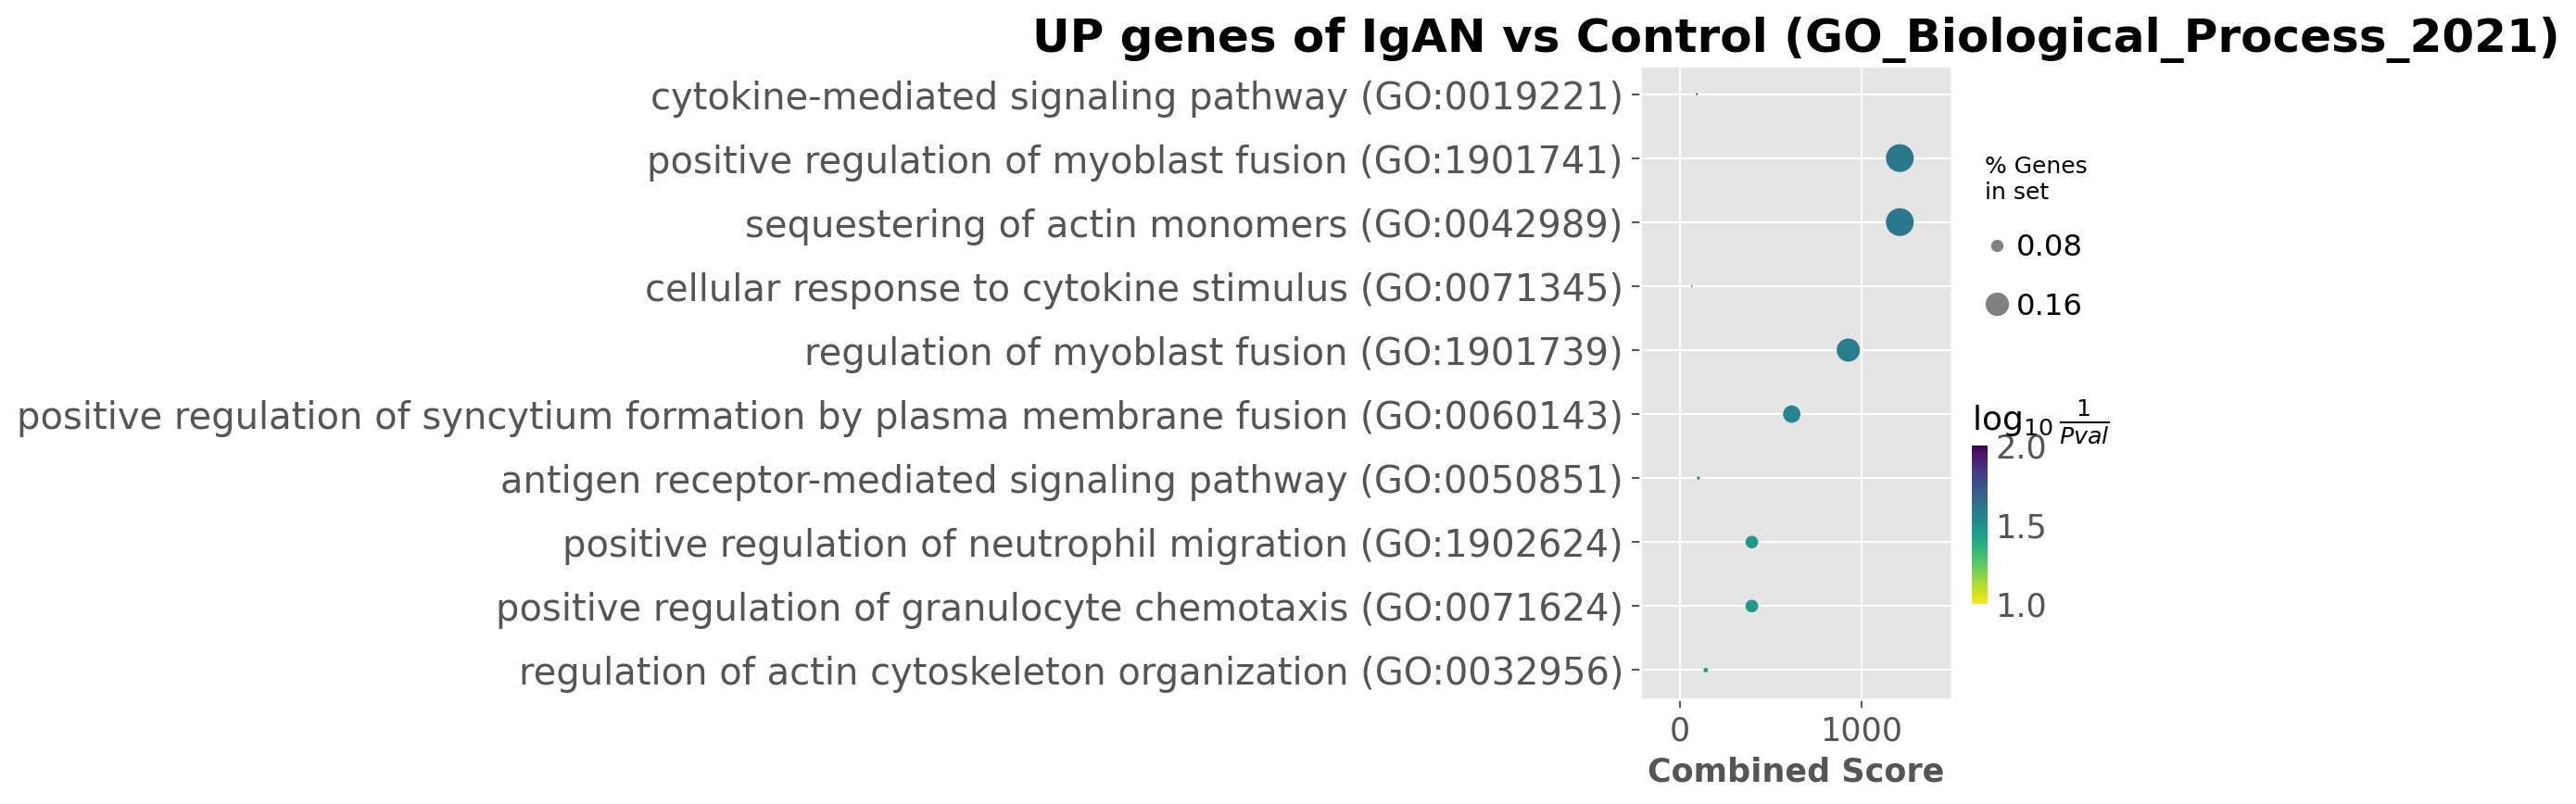

In [159]:
gp.dotplot(mast_up_enr.res2d, title=f'UP genes of IgAN vs Control (GO_Biological_Process_2021)',cmap='viridis_r', size=10, figsize=(3,5), cutoff=0.05)

In [ ]:
gp.barplot(mast_up_enr.res2d,title='GO_Biological_Process_2021')

GSEA analysis for MAST DE between merged IgAN and control

In [162]:
mast4gsea_df = mast_de.sort_values('logfoldchanges', ascending=False)
res = gp.prerank(mast4gsea_df[['names','logfoldchanges']], 
               gene_sets= 'MSigDB_Hallmark_2020',
               outdir=None,
              permutation_num=1000,
              threads=6)
sig_mast_gsea = res.res2d.query('`FDR q-val` < 0.05')

<Axes: title={'center': 'GSEA IgAN vs Control (MsigDB_hallmark)'}, xlabel='NES'>

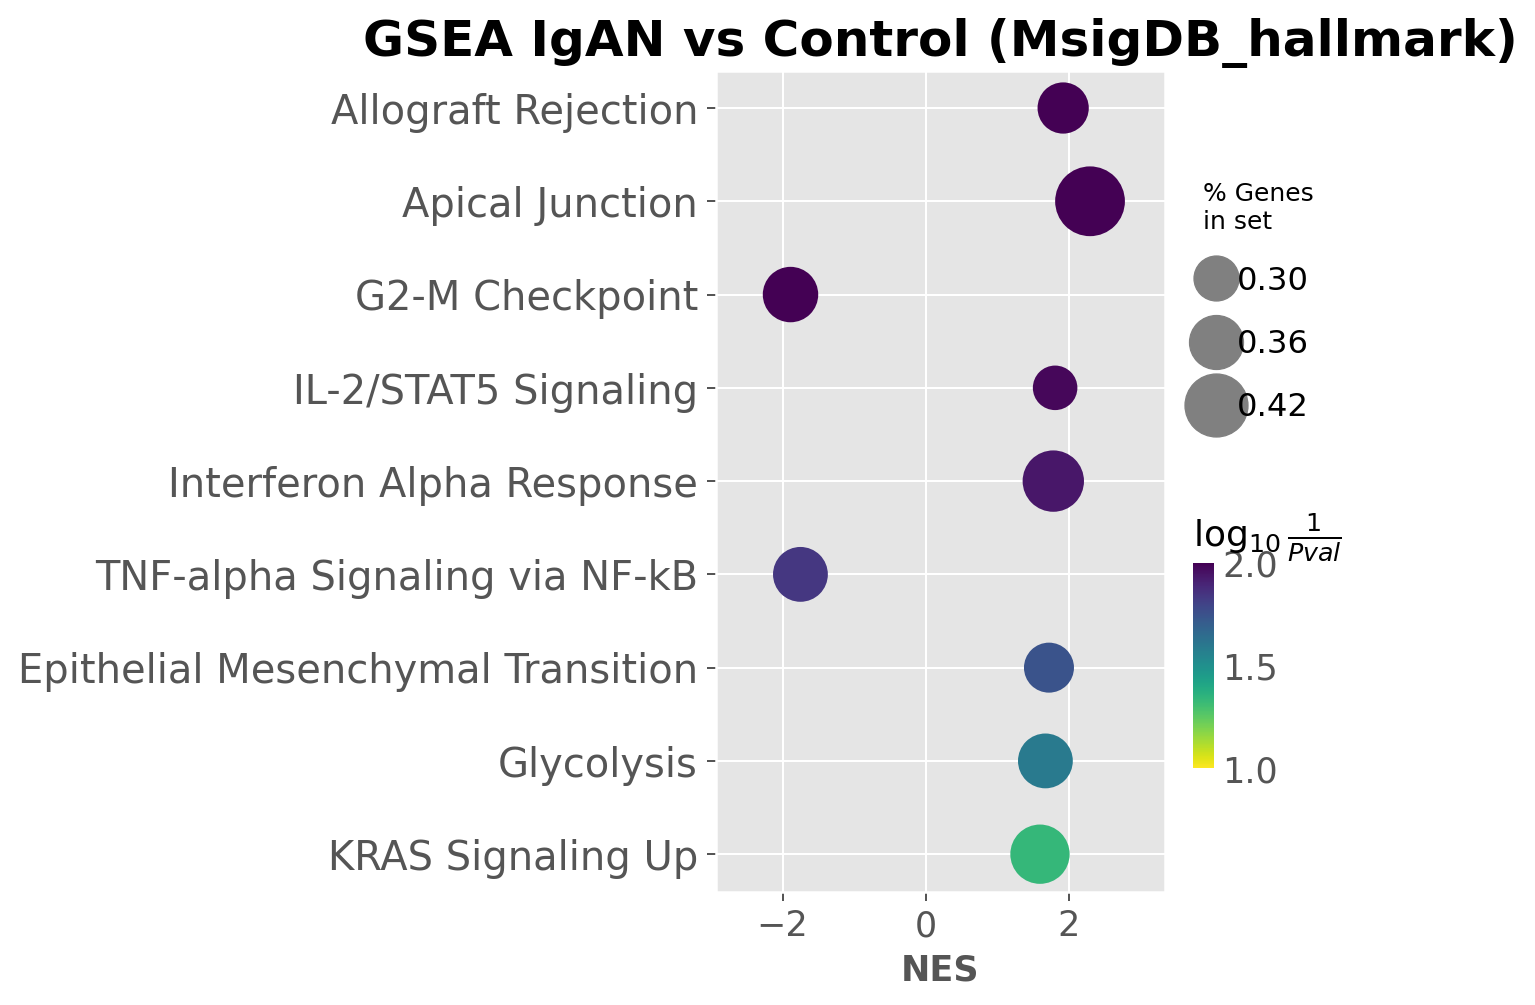

In [163]:
# dotplot 
gp.dotplot(res.res2d, title=f'GSEA IgAN vs Control (MsigDB_hallmark)',cmap='viridis_r', size=10,  cutoff=0.05,column='FDR q-val')

In [ ]:
mast4gsea_df = mast_de.sort_values('logfoldchanges', ascending=False)
res_glyco = gp.prerank(mast4gsea_df[['names','logfoldchanges']], 
               gene_sets= glyco_dict,
               outdir=None,
              permutation_num=1000,
              threads=6)
# sig_mast_gsea = res.res2d.query('`FDR q-val` < 0.05')

In [ ]:
# dotplot
gp.dotplot(res_glyco.res2d, title=f'GSEA IgAN vs Control (Glycosylation pathways)',cmap='viridis_r', size=10,  cutoff=0.2,column='FDR q-val')

In [ ]:
# gsea plot
term = 'Glycosylhydrolase'
gp.gseaplot(res_glyco.ranking, term=term, **res_glyco.results[term])

In [ ]:
de_fn = f'{bde_res_path}/MAST_IgA+_Bcell_clusts_igan_vs_ctrl.tsv'
mast_de.to_csv(de_fn, sep='\t')

In [ ]:
mast_de = pd.read_csv(f'{work_dir}/DE/Cluster_B_cells/MAST_all_cells_IgA+_Bcell_clusts_igan_vs_ctrl.tsv', sep='\t')
mast_de.columns = ['names','pvals','logfoldchanges','pvals_adj']

#### 3.1.3 GO term analysis

In [ ]:
key = 'IgA+_Bcell_clust12_igan_vs_ctrl'
up_glist = sc.get.rank_genes_groups_df(b_iga_adata, group='IgAN', key=key,pval_cutoff=0.05, log2fc_min=1)['names'].squeeze().str.strip().tolist()
dn_glist = sc.get.rank_genes_groups_df(b_iga_adata, group='IgAN', key=key,pval_cutoff=0.05, log2fc_max=-1)['names'].squeeze().str.strip().tolist()

In [ ]:
up_enr = gseapy.enrichr(gene_list=up_glist, organism='Human', gene_sets='GO_Biological_Process_2021', cutoff = 0.5)
dn_enr = gseapy.enrichr(gene_list=dn_glist, organism='Human', gene_sets='GO_Biological_Process_2021', cutoff = 0.5)

In [ ]:
print('up genes:', len(up_glist))
gseapy.barplot(up_enr.res2d,title='GO_Biological_Process_2021')
print('down genes:', len(dn_glist))
gseapy.barplot(dn_enr.res2d,title='GO_Biological_Process_2021')

### 3.2 DE analysis CITE-Seq
#### 3.2.1 using wilcoxon

In [ ]:
# rank genes group
ab_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/ab_adata.h5ad')
ab_adata.obs = pd.merge(ab_adata.obs, b_iga_adata.obs[['Bcell_leiden_r0.5']], how='left', left_index=True, right_index=True)
iga_ab_adata = ab_adata[~ab_adata.obs['Bcell_leiden_r0.5'].isna(),:]
sc.tl.rank_genes_groups(iga_ab_adata, 'Bcell_leiden_r0.5', method='wilcoxon')

In [ ]:
# ran DE analysis using wilcoxon analysis
ab_concat_df, ab_merge_df = sctool.clust_de_wilcoxon(iga_ab_adata, 'Bcell_leiden_r0.5', 'condition', 'control', 'Iga+_Bcite_igan_vs_ctrl')

In [ ]:
# output merged DE results to file
ab_merge_df.index.name = 'Gene'
bde_res_path = f'{work_dir}/DE/Cluster_B_cells'
os.makedirs(bde_res_path, exist_ok=True)
ab_merge_de_fn = f'{bde_res_path}/IgA+_Bcite_igan_vs_ctrl.tsv'
ab_merge_df.to_csv(ab_merge_de_fn, sep='\t')

In [ ]:
# plot of DE gene number for each condition
ax, de_dicts = sctool.plot_rank_gene_de_num(ab_merge_df, title='DE genes between IgAN and control for IgA+ B cells', ncol_clust=6, lfc=0.58, padj=0.05)
up_dict, dn_dict, non_de_dict = de_dicts

Scatter plot of gene expression between conditions

In [ ]:
# get IgAN and control * gene expression 
clust = iga_ab_adata.obs['Bcell_leiden_r0.5'].cat.categories
rows = [c + '_igan' for c in clust] + [c + '_ctrl' for c in clust]

res = pd.DataFrame(columns=iga_ab_adata.var_names, index=rows)
# get mean gene expression for each cluster
for cl in iga_ab_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    ctrl = iga_ab_adata[iga_ab_adata.obs.query('`Bcell_leiden_r0.5` == @cl and condition == "control"').index,:]
    res.loc[f'{cl}_ctrl'] = ctrl.X.mean(0)
    igan = iga_ab_adata[iga_ab_adata.obs.query('`Bcell_leiden_r0.5` == @cl and condition == "IgAN"').index,:]
    res.loc[f'{cl}_igan'] = igan.X.mean(0)

In [ ]:
# scatter plot of gene expression in IgAN and control
row = 3
col = 5
fig, axes = plt.subplots(row,col, figsize=(20,12),sharex=False, sharey=False)

for cl in iga_ab_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    x = f'{cl}_ctrl'
    y = f'{cl}_igan'
    
    n = int(cl)
    j = n % col
    i = n // col
    res.loc[[x,y],non_de_dict[cl]].T.plot(kind='scatter', x=x,y=y, color='grey', ax=axes[i,j], alpha=0.5)
    res.loc[[x,y],up_dict[cl]].T.plot(kind='scatter', x=x,y=y, color='r', ax=axes[i,j])
    res.loc[[x,y],dn_dict[cl]].T.plot(kind='scatter', x=x,y=y, color='b', ax=axes[i,j])
    axes[i,j].set_ylim(0,2.5)
    axes[i,j].set_xlim(0,2.5)
    axes[i,j].set_xlabel('')
    axes[i,j].set_ylabel('')
    axes[i,j].set_title(f'cluster_{cl}')
    axes[i,j].plot([0, 2.5], [0, 2.5], transform=axes[i,j].transAxes, ls='--', color='black')

MA plot

In [ ]:
# get mean expression of genes
clust = iga_ab_adata.obs['Bcell_leiden_r0.5'].cat.categories
rows = [f'clust{c}_mean' for c in clust]

ma_df = pd.DataFrame(columns=iga_ab_adata.var_names, index=rows)

# get mean gene expression for each cluster
for cl in iga_ab_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    clst = iga_ab_adata[iga_ab_adata.obs.query('`Bcell_leiden_r0.5` == @cl').index,:]
    ma_df.loc[f'clust{cl}_mean',:] = clst.X.mean(0)
ma_df = ma_df.T
ma_df = pd.merge(ab_merge_df, ma_df, how='left', left_index=True, right_index=True)

for cl in iga_ab_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    ma_df[f'clust{cl}_pvals_adj'] = -np.log10(ma_df[f'clust{cl}_pvals_adj'])

In [ ]:
# MA plot,  logfoldchange  vs  mean expression
row = 3
col = 5
fig, axes = plt.subplots(row,col, figsize=(20,12),sharex=False, sharey=False)

for cl in iga_ab_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    x = f'clust{cl}_mean'
    y = f'clust{cl}_logfoldchanges'
    
    n = int(cl)
    j = n % col
    i = n // col
    ma_df.loc[non_de_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='grey', ax=axes[i,j], alpha=0.5)
    ma_df.loc[up_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='r', ax=axes[i,j])
    ma_df.loc[dn_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='b', ax=axes[i,j])
    # axes[i,j].set_ylim(0,6)
    # axes[i,j].set_xlim(0,6)
    axes[i,j].set_xlabel('')
    axes[i,j].set_ylabel('')
    axes[i,j].set_title(f'cluster_{cl}')
    # axes[i,j].plot([0, 6], [0, 6], transform=axes[i,j].transAxes, ls='--', color='black')

#### 3.2.2 Marker proteins plot

In [ ]:
# plot heatmap include only expressed genes
bmarker = sctool.get_cluster_markers(iga_ab_adata, 'rank_genes_groups')
bmarker_dict = {}
for i in iga_ab_adata.uns['rank_genes_groups']['names'].dtype.fields:
    bmarker_dict[i] = [g for g in bmarker[f'{i}_names'].tolist() if g in expr_10genes]
    
groups = ['0','1','5','12']
group_dict = {k:bmarker_dict[k][:10] for k in groups}
# sc.pl.rank_genes_groups_matrixplot(test, key='rank_genes_r0.5',cmap='Greens',groups=groups, var_names=group_dict)

In [ ]:
# protein expression at each cluster
groups = [str(i) for i in range(15)]
sc.pl.rank_genes_groups_matrixplot(iga_ab_adata, n_genes=10, min_logfoldchange=0.58, key='rank_genes_groups',groups=groups, cmap='Greens')

In [ ]:
# protein expression at each cluster
sc.pl.rank_genes_groups_matrixplot(iga_ab_adata, n_genes=10, min_logfoldchange=0, key='rank_genes_groups',groups=['0','1','5','12'], cmap='Greens', standard_scale='var', colorbar_title='column scaled\nexpression')

In [ ]:
sc.pl.rank_genes_groups_matrixplot(iga_ab_adata, n_genes=10, min_logfoldchange=0.58, key='rank_genes_groups', 
                                   cmap='bwr', values_to_plot="logfoldchanges")

In [ ]:
# MA plot,  logfoldchange  vs  mean expression
row = 3
col = 5
fig, axes = plt.subplots(row, col, figsize=(20,12),sharex=False, sharey=False)

for cl in iga_ab_adata.obs['Bcell_leiden_r0.5'].cat.categories:
    x = f'clust{cl}_control_pts'
    y = f'clust{cl}_IgAN_pts'
    
    n = int(cl)
    j = n % col
    i = n // col
    ma_df.loc[non_de_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='grey', ax=axes[i,j], alpha=0.5)
    ma_df.loc[up_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='r', ax=axes[i,j])
    ma_df.loc[dn_dict[cl], [x,y]].plot(kind='scatter', x=x,y=y, color='b', ax=axes[i,j])
    # axes[i,j].set_ylim(0,6)
    # axes[i,j].set_xlim(0,6)
    axes[i,j].set_xlabel('')
    axes[i,j].set_ylabel('')
    axes[i,j].set_title(f'cluster_{cl}')
    # axes[i,j].plot([0, 6], [0, 6], transform=axes[i,j].transAxes, ls='--', color='black')

#### 3.2.3 DE for combined IgA and control excluding cluster 11 and 14


In [ ]:
clusts = ['11','14']
iga_ab_adata4de = iga_ab_adata[iga_ab_adata.obs.query('`Bcell_leiden_r0.5` not in @clusts').index,:].copy()
key = "all_IgAN_vs_Ctrl_wilcoxon"
sc.tl.rank_genes_groups(iga_ab_adata4de, 'condition', reference='control', method='wilcoxon', pts=True, key_added = key)

In [ ]:
ab_def = sctool.get_cluster_markers(iga_ab_adata4de, key)

In [ ]:
from bioinfokit import analys, visuz
logfc='IgAN_logfoldchanges'
q_val = 'IgAN_pvals_adj'
title = 'IgAN vs Control (CITE-Seq)'

sctool.volcano(ab_def, 'IgAN_names', 'IgAN_logfoldchanges', 'IgAN_pvals_adj', 0.58, 0.05, outdir)

### Analyze genes in Glycosylation pathways
#### 1. Glycosylation genes expression in IgAN and Control

In [ ]:
# b_adata = sc.read_h5ad(f'{work_dir}/b_adata.h5ad')
# b_adata.obs['cond_sp'] = b_adata.obs.apply(lambda x: x['condition'] + '_' + x['sample'].split('_')[0] ,axis=1)
# b_iga_adata = b_adata[b_adata.obs.query('IgA == "IgA+"').index,:].copy()
b_iga_adata.obs['cond_clust'] = b_iga_adata.obs.apply(lambda x: x['condition'] + '_' + x['Bcell_leiden_r0.5'],axis=1)
b_iga_adata.obs['clust_cond'] = b_iga_adata.obs.apply(lambda x: x['Bcell_leiden_r0.5'] + '_' + x['condition'],axis=1)

In [ ]:
glyco_gene_fn = f'{work_dir}/glyco/glyco_genes.tsv'
glyco_df = pd.read_csv(glyco_gene_fn, sep='\t', header=0)
glyco_dict = {k:list(v) for k,v in glyco_df.groupby('Category')['Gene']}

In [ ]:
# pathway = 'N-glycan processing and branching'
# glyco_genes = glyco_dict[pathway]
# glyco_genes = list(set(glyco_genes).intersection(b_iga_adata.var.index))
# sc.pl.matrixplot(b_iga_adata, glyco_genes, 'Bcell_leiden_r0.5', cmap='Greens', standard_scale='var', colorbar_title='column scaled\nexpression')
# sc.pl.dotplot(b_iga_adata, glyco_genes, 'Bcell_leiden_r0.5', cmap='Greens',standard_scale='var', colorbar_title='column scaled\nexpression')

In [ ]:
pathway = 'Biosynthesis of C-mannose'
glyco_genes = glyco_dict[pathway]
glyco_genes = list(set(glyco_genes).intersection(b_iga_adata.var.index))
sc.pl.matrixplot(b_iga_adata, glyco_genes, 'cond_clust', cmap='Greens', standard_scale='var', colorbar_title='column scaled\nexpression')
sc.pl.dotplot(b_iga_adata, glyco_genes, 'cond_clust', cmap='Greens',standard_scale='var', colorbar_title='column scaled\nexpression')

#### 2. GSEA

In [ ]:
glyco_gene_fn = f'{work_dir}/glyco/glyco_genes.tsv'
glyco_df = pd.read_csv(glyco_gene_fn, sep='\t', header=0)
glyco_dict = {k:list(v) for k,v in glyco_df.groupby('Category')['Gene']}

##### 2.1 GSEA: DE of scRNASeq value
gsea to test if glyco genes are enriched in DE genes between IgAN and control in each cluster using glyco pathways as database
Log2 value calculated direct

In [ ]:
# gsea_de_clust = {}
# for i in range(15):
#     cl = b_iga_adata[b_iga_adata.obs.query(f'`Bcell_leiden_r0.5`=="{i}"').index,:].copy()
#     cl.obs['condition'] = pd.Categorical(cl.obs['condition'], categories=['IgAN','control'], ordered=True)
#     indices = cl.obs.sort_values('condition').index
#     cl = cl[indices,:]
#     res = gp.gsea(data=cl.to_df().T, # row -> genes, column-> samples
#         gene_sets=glyco_dict,
#         cls=cl.obs.condition,
#         permutation_num=1000,
#         permutation_type='phenotype',
#         outdir=None,
#         method='log2_ratio_of_classes', # signal_to_noise
#         threads= 6)
#     print(f'clust{i}')
#     print(res.res2d.query('`FDR q-val` < 0.05'))
#     gsea_de_clust[str(i)] = res.res2d

In [ ]:
gp.get_library_name(organism='Human')

##### 2.2 MAST DE prerank, MisgDB
gsea to test if glyco genes are enriched in DE genes between IgAN and control in each cluster using glyco pathways as database

gsea to test if glyco genes are enriched in each cluster using glyco pathways as database

In [ ]:
# gsea for all of the de results
mast_de_fn = f'{work_dir}/DE/Cluster_B_cells/MAST_IgA+_Bcell_clusts_igan_vs_ctrl_keep_orign_rank.tsv'
mast_de_df = pd.read_csv(mast_de_fn, sep='\t', header=0)

mast_gsea_clust = {}
mast_gsea_res = {}
sig_gsea_res = {}
for i in range(15):
    df = mast_de_df[[f'clust{i}_names',f'clust{i}_logfoldchanges']] # f'{i}_pvals', f'{i}_pvals_adj'
    df = df.sort_values(f'clust{i}_logfoldchanges', ascending=False)
    res = gp.prerank(df, 
               gene_sets= 'MSigDB_Hallmark_2020',
               outdir=None,
              permutation_num=1000,
              threads=6)
    mast_gsea_clust[str(i)] = res.res2d
    mast_gsea_res[str(i)] = res
    sig_gsea_res[str(i)] = res.res2d.query('`FDR q-val` < 0.05')

In [ ]:
for i in range(15):
    try:
        gp.dotplot(mast_gsea_res[str(i)].res2d, title=f'cluster{i}_MsigDB_hallmark',cmap='viridis_r', size=10, figsize=(3,5), cutoff=0.05,column='FDR q-val')
    except:
        pass

##### 2.3 MAST DE prerank, Glycosylation genes
gsea to test if glyco genes are enriched in DE genes between IgAN and control in each cluster using glyco pathways as database

In [ ]:
# gsea for all of the de results
mast_de_fn = f'{work_dir}/DE/Cluster_B_cells/MAST_IgA+_Bcell_clusts_igan_vs_ctrl_keep_orign_rank.tsv'
mast_de_df = pd.read_csv(mast_de_fn, sep='\t', header=0)

mast_gsea_clust = {}
mast_gsea_res = {}
sig_gsea_res = {}
for i in range(15):
    df = mast_de_df[[f'clust{i}_names',f'clust{i}_logfoldchanges']] # f'{i}_pvals', f'{i}_pvals_adj'
    df = df.sort_values(f'clust{i}_logfoldchanges', ascending=False)
    res = gp.prerank(df, 
               gene_sets= glyco_dict,
               outdir=None,
              permutation_num=1000,
              threads=6)
    mast_gsea_clust[str(i)] = res.res2d
    mast_gsea_res[str(i)] = res
    sig_gsea_res[str(i)] = res.res2d.query('`FDR q-val` < 0.05')

In [ ]:
for i in range(15):
    try:
        gp.dotplot(mast_gsea_res[str(i)].res2d, title=f'cluster{i}',cmap='viridis_r', size=10, figsize=(3,5), cutoff=0.05,column='FDR q-val')
    except:
        pass

In [ ]:
term = 'N-glycan processing and branching'
clust = '14'
gp.gseaplot(mast_gsea_res[clust].ranking, term=term, **mast_gsea_res[clust].results[term])

##### Cluster marker gene gsea
GSEA for rank genes for each cluster

In [ ]:
gsea_clust = {}
for i in range(1):
    df = marker_df[[f'clust{i}_names',f'clust{i}_logfoldchanges']] # f'{i}_pvals', f'{i}_pvals_adj'
    df = df.sort_values(f'clust{i}_logfoldchanges')
    res = gp.prerank(df, 
               gene_sets=glyco_dict,
               outdir=None,
              permutation_num=1000,
              threads=6)
    gsea_clust[str(i)] = res.res2d

In [ ]:
genes = ['C1GALT1','C1GALT1C1','B4GALT1', 'B4GALT2', 'B4GALT3', 'B4GALT4']
mast_df.loc[genes,:]

##### glycosylation genes expression

In [ ]:
# expression in each cluster
genes = ['C1GALT1','C1GALT1C1','B4GALT1', 'B4GALT2', 'B4GALT3', 'B4GALT4', 'ST6GALNAC2']
nrow = 3
ncol = 5
fig, axes = plt.subplots(nrow, ncol, figsize=(20,15), sharex=True, sharey=True)
for i in range(15):
    cl = b_iga_adata[b_iga_adata.obs.query(f'`Bcell_leiden_r0.5`=="{i}"').index,:]
    row = i // ncol
    col = i % ncol
    key = f'wilcoxn_IgA+_Bcell_igan_vs_ctrl_clust{i}'
    ax = sc.pl.rank_genes_groups_violin(cl, gene_names=genes, key=key,ax = axes[row,col], show=False)
    # ax[0].set_xlabel('')
    ax[0].set_title(f'cluster {i}')
    ax[0].set_ylabel('')
    axes[row, col] = ax

In [ ]:
sc.tl.rank_genes_groups(b_iga_adata, groupby='condition', ref='control',groups=['control','IgAN'], key_added='wilcoxn_all_IgAN_vs_control')

In [ ]:
genes = ['C1GALT1','C1GALT1C1','B4GALT1', 'B4GALT2', 'B4GALT3', 'B4GALT4', 'ST6GALNAC2']
fig, ax = plt.subplots(figsize=(6,6))
_ = sc.pl.rank_genes_groups_violin(b_iga_adata, gene_names=genes, key='wilcoxn_all_IgAN_vs_control', show=False, ax=ax)
ax.set_title('IgAN vs Control')

In [ ]:
genes = ['C1GALT1','C1GALT1C1','B4GALT1', 'B4GALT2', 'B4GALT3', 'B4GALT4', 'ST6GALNAC2']
test = b_iga_adata.copy()
rm_clusts = ['11', '14']
test = test[test.obs.query('`Bcell_leiden_r0.5` not in @rm_clusts').index,:]

fig, ax = plt.subplots(figsize=(6,6))
_ = sc.pl.rank_genes_groups_violin(test, gene_names=genes, key='wilcoxn_all_IgAN_vs_control', show=False, ax=ax, use_raw=False)
ax.set_title('IgAN vs Control')

In [ ]:
b_iga_adata.obs['condition'].value_counts()

# 4 Analyze B cells with no IgA+

In [231]:
b_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/b_adata_rm_Ig_vari.h5ad')
b_adata.uns['log1p']["base"] = None
b_adata.obs['cond_sp'] = b_adata.obs.apply(lambda x: x['condition'] + '_' + x['sample'].split('_')[0] ,axis=1)
b_no_iga_adata = b_adata[b_adata.obs.query('init_cell_type == "B cell" and receptor_type != "BCR"').index,:].copy()

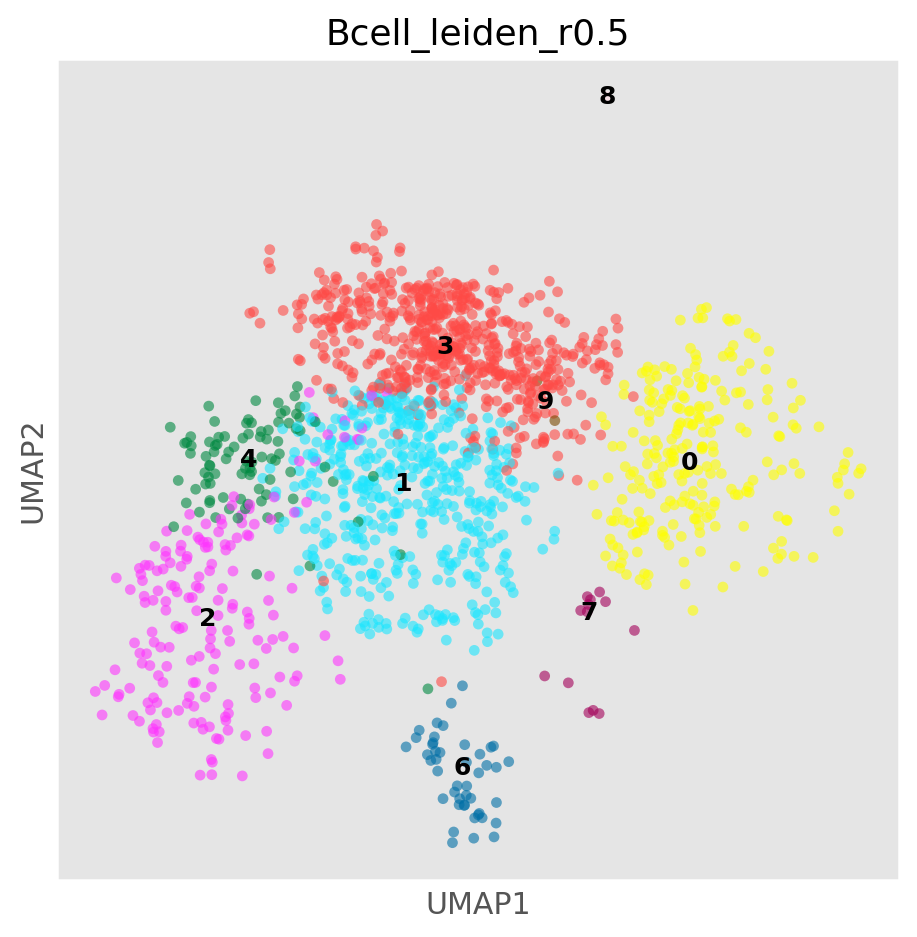

In [234]:
bcell_cluster_key = 'Bcell_leiden_r0.5'
sc.pl.umap(b_no_iga_adata, color=bcell_cluster_key, palette=sc.pl.palettes.default_102, legend_loc='on data',alpha=0.6)

In [235]:
b_no_iga_adata.obs.groupby(['sample','condition']).size().unstack().apply(lambda x: x/sum(x), axis=1).round(2)

condition  IgAN  control
sample                  
A1_a       0.44     0.56
A1_b       0.56     0.44
A2_a       0.05     0.95
A2_b       0.08     0.92

<Axes: xlabel='sample'>

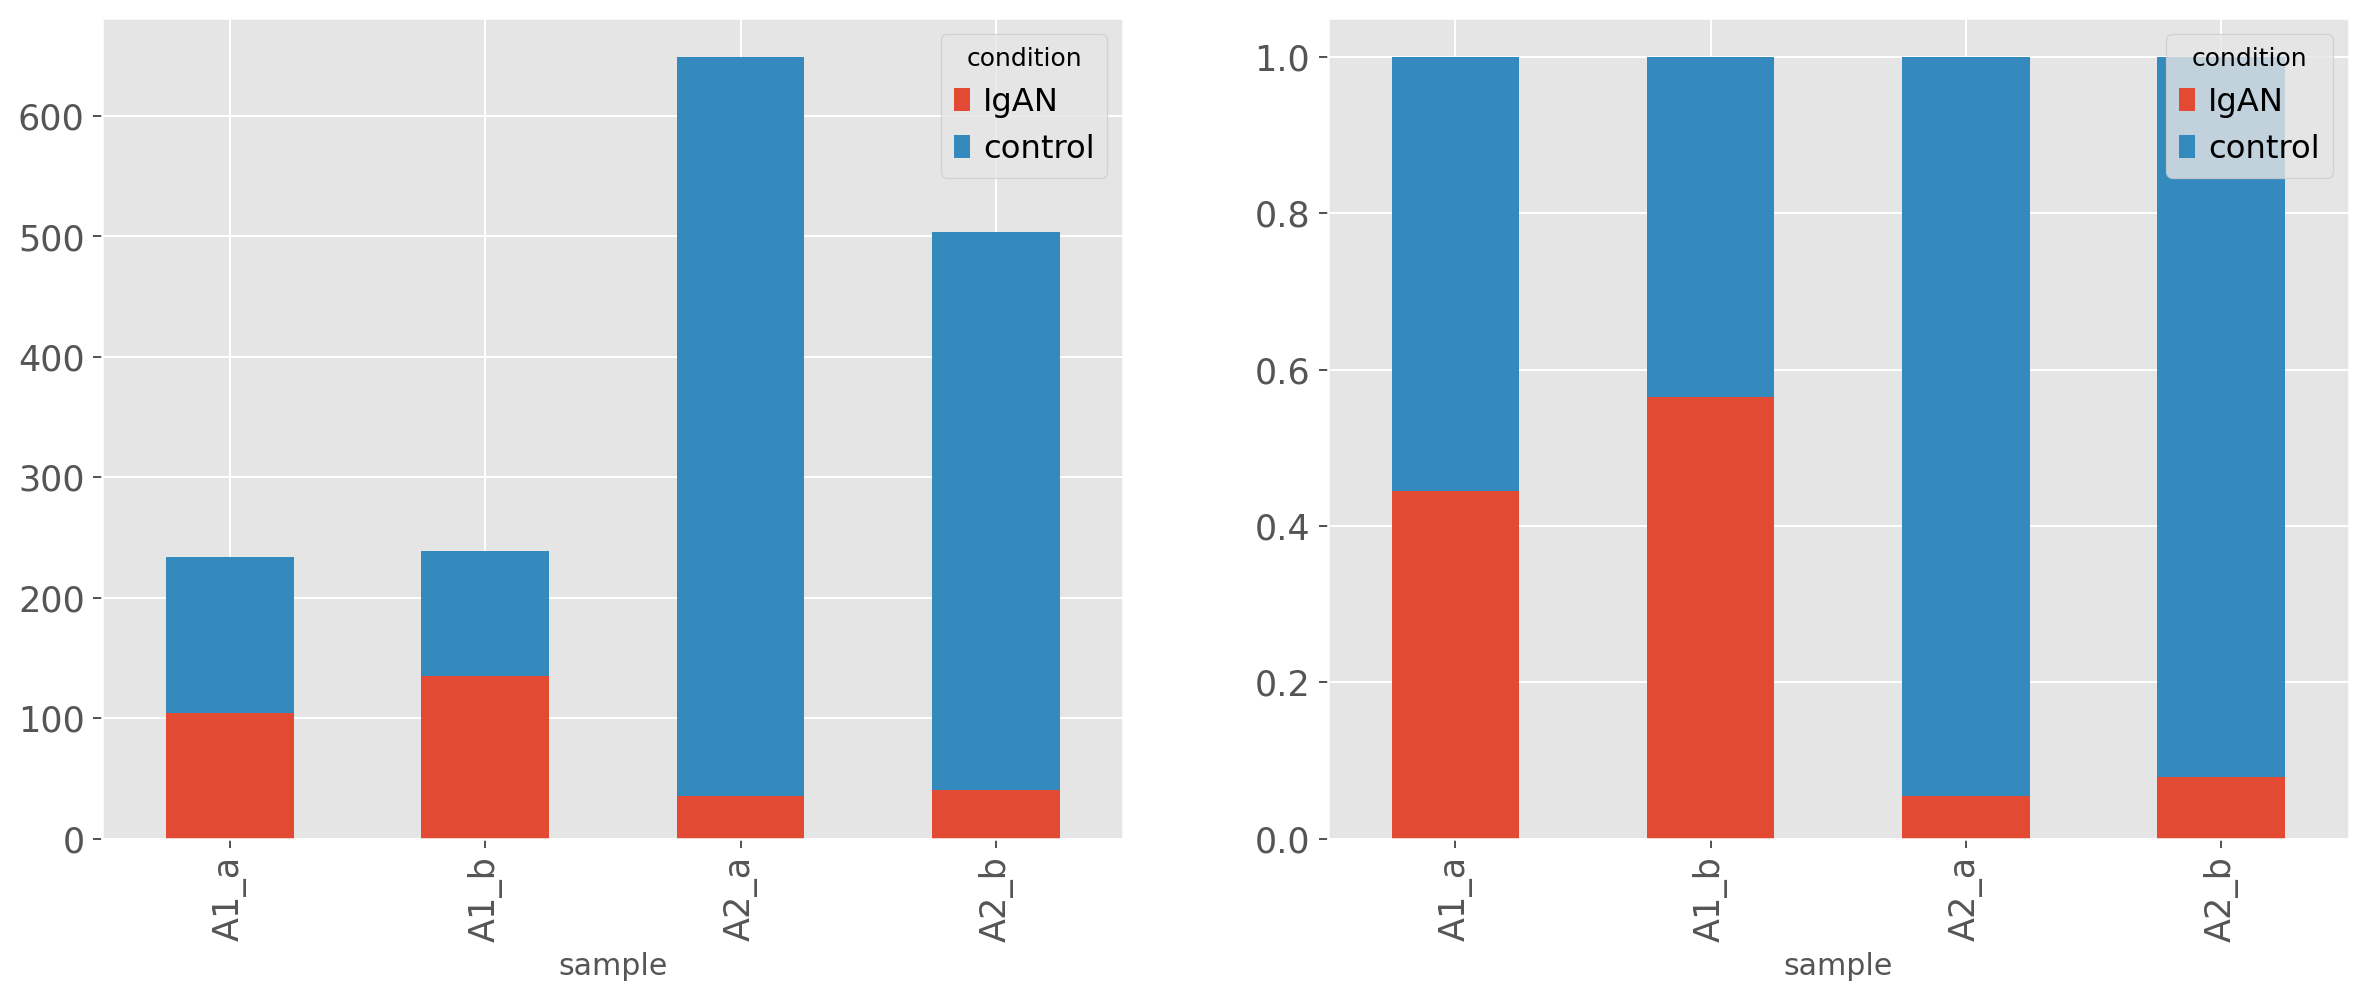

In [236]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
b_no_iga_adata.obs.groupby(['sample','condition']).size().unstack().plot(kind='bar',stacked=True, ax=axes[0])
b_no_iga_adata.obs.groupby(['sample','condition']).size().unstack().apply(lambda x: x/sum(x), axis=1).plot(kind='bar',stacked=True, ax=axes[1])

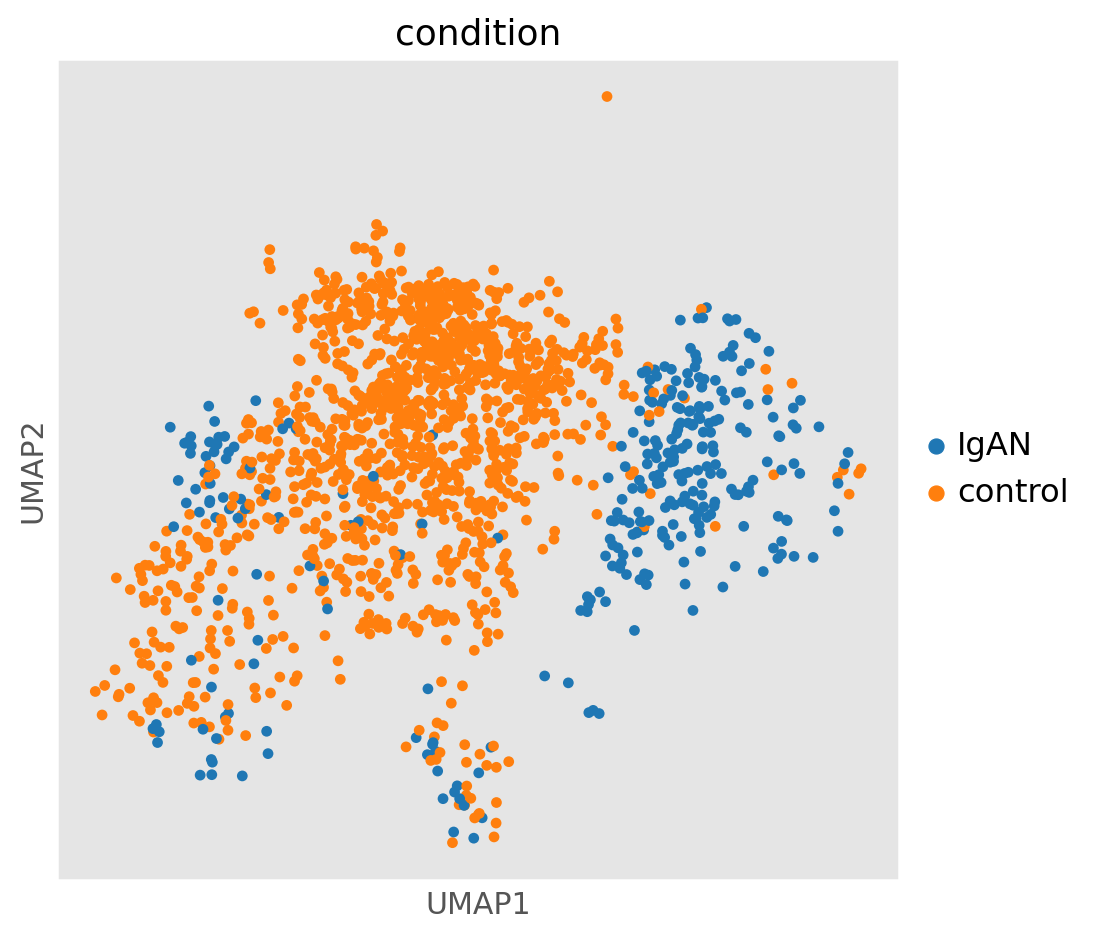

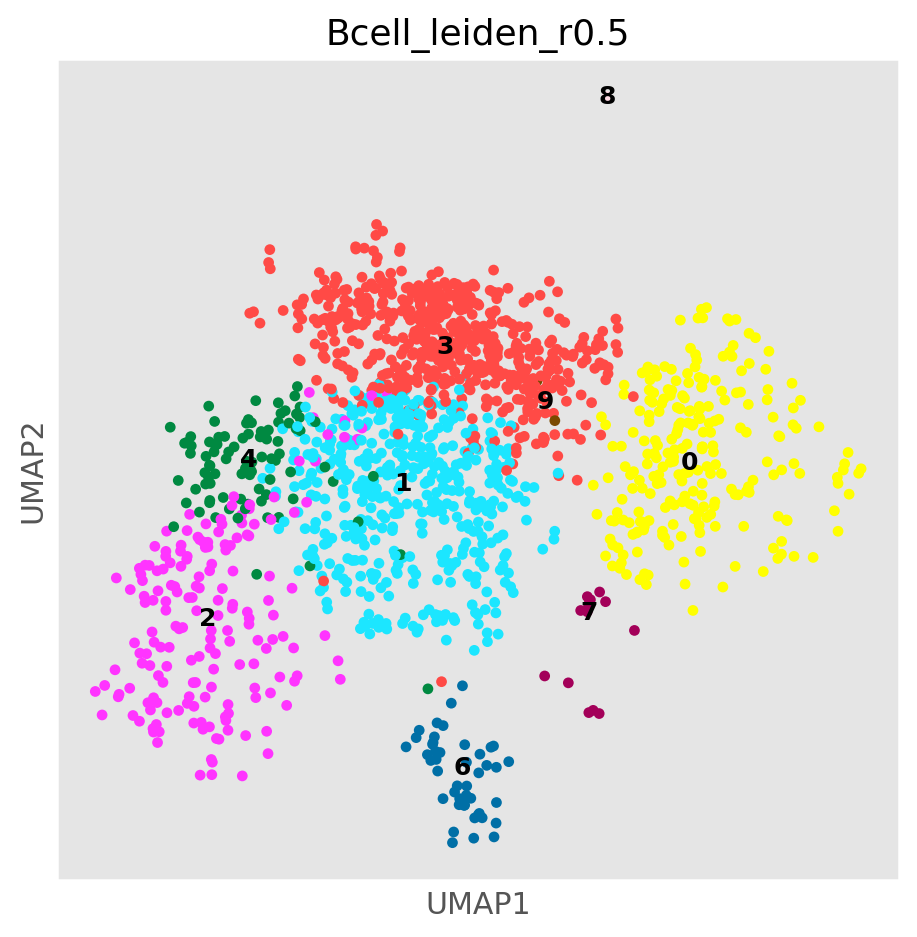

In [237]:
sc.pl.umap(b_no_iga_adata, color=['condition'], palette=sc.pl.palettes.default_20)
sc.pl.umap(b_no_iga_adata, color=[bcell_cluster_key], palette=sc.pl.palettes.default_102, legend_loc='on data')

Text(0.5, 1.0, 'cell distribution across cluster & condition')

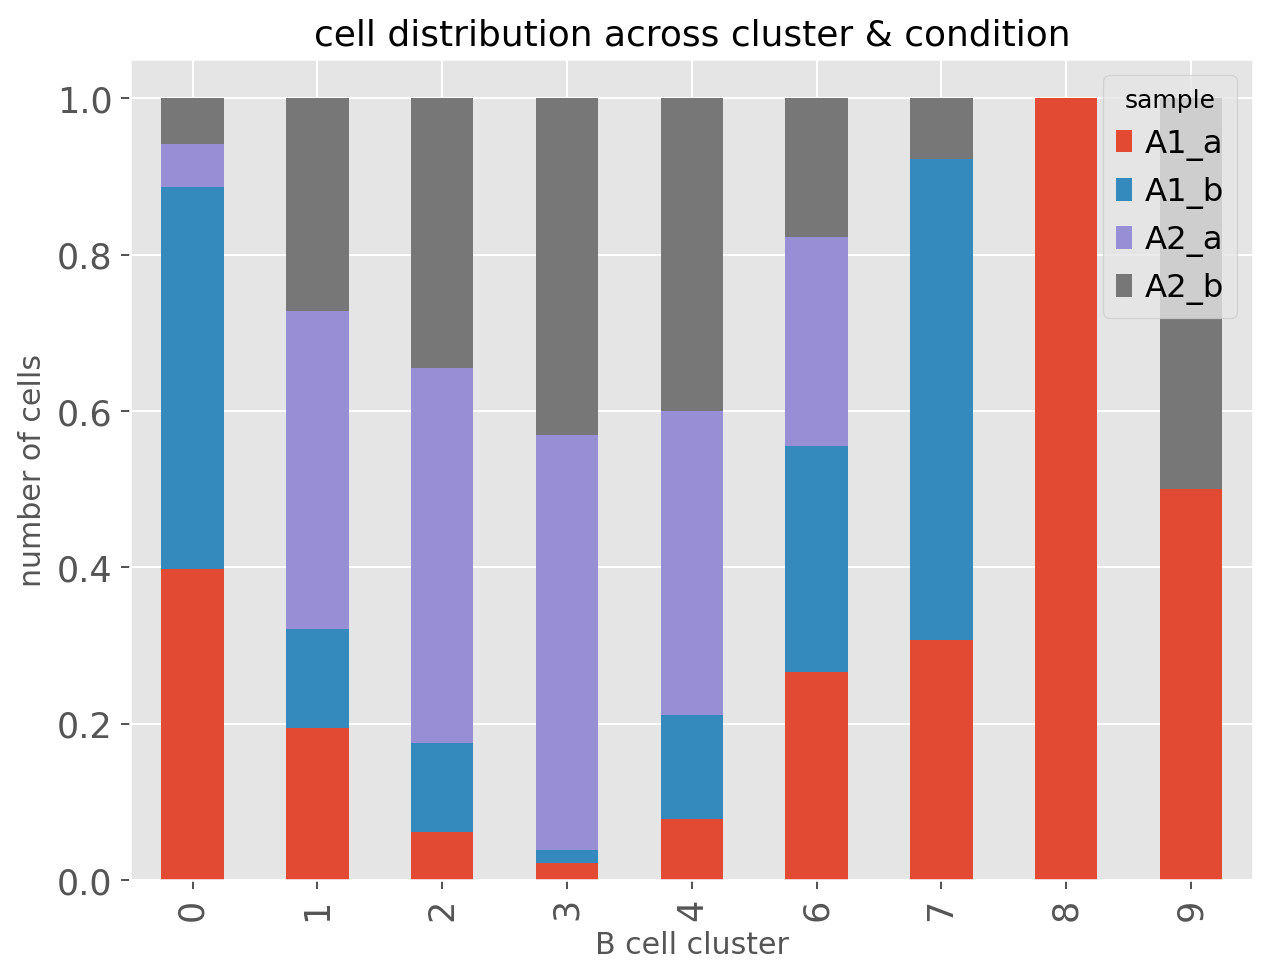

In [238]:
# ax = b_iga_adata.obs.groupby(['Bcell_leiden_r0.5','condition']).size().unstack().plot(kind='bar',stacked=True, figsize=(8,6))
ax = b_no_iga_adata.obs.groupby([bcell_cluster_key,'sample']).size().unstack().apply(lambda x: x/sum(x),axis=1).plot(kind='bar',stacked=True, figsize=(8,6))
ax.set_xlabel('B cell cluster')
ax.set_ylabel('number of cells')
ax.set_title('cell distribution across cluster & condition')

<Axes: xlabel='Bcell_leiden_r0.5'>

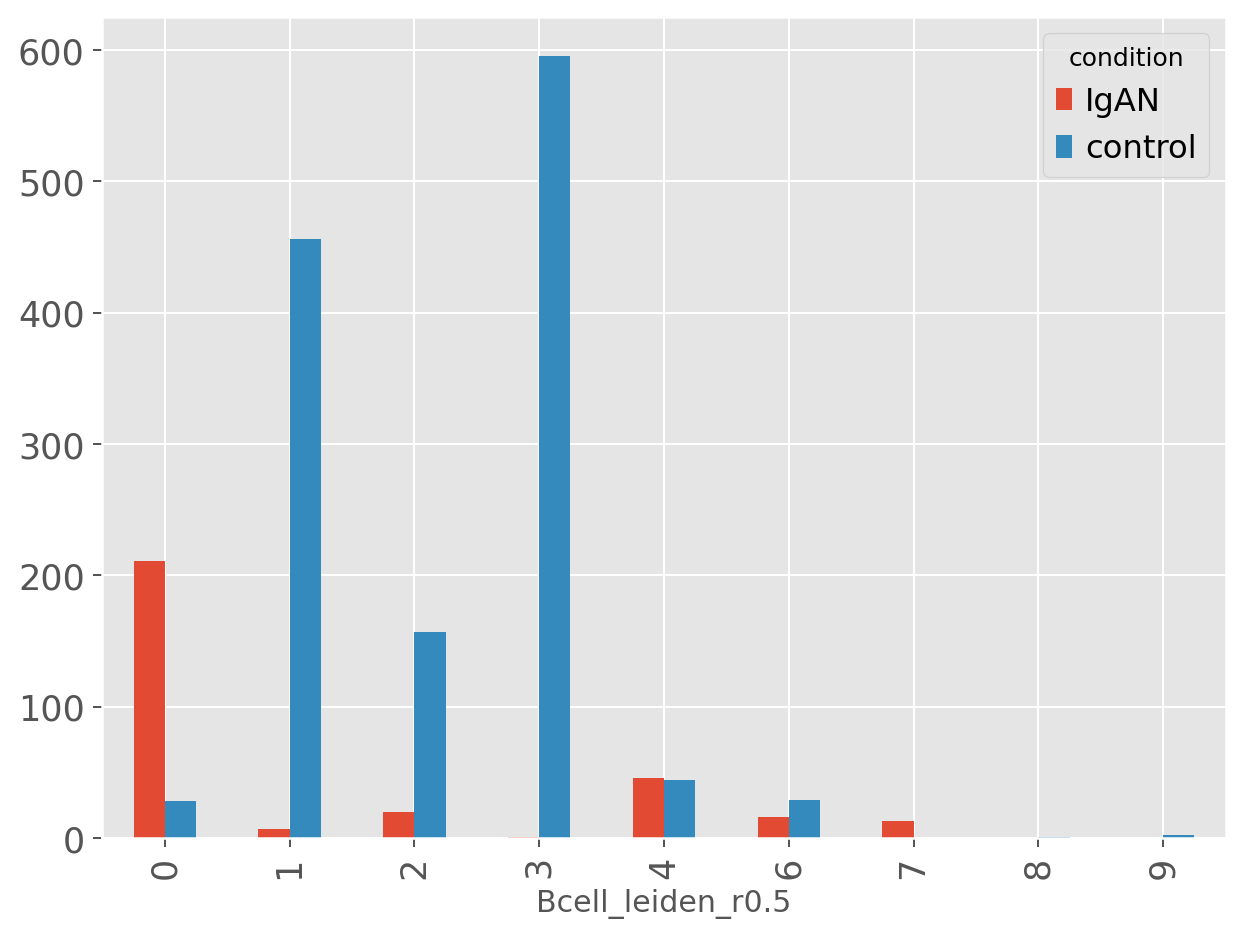

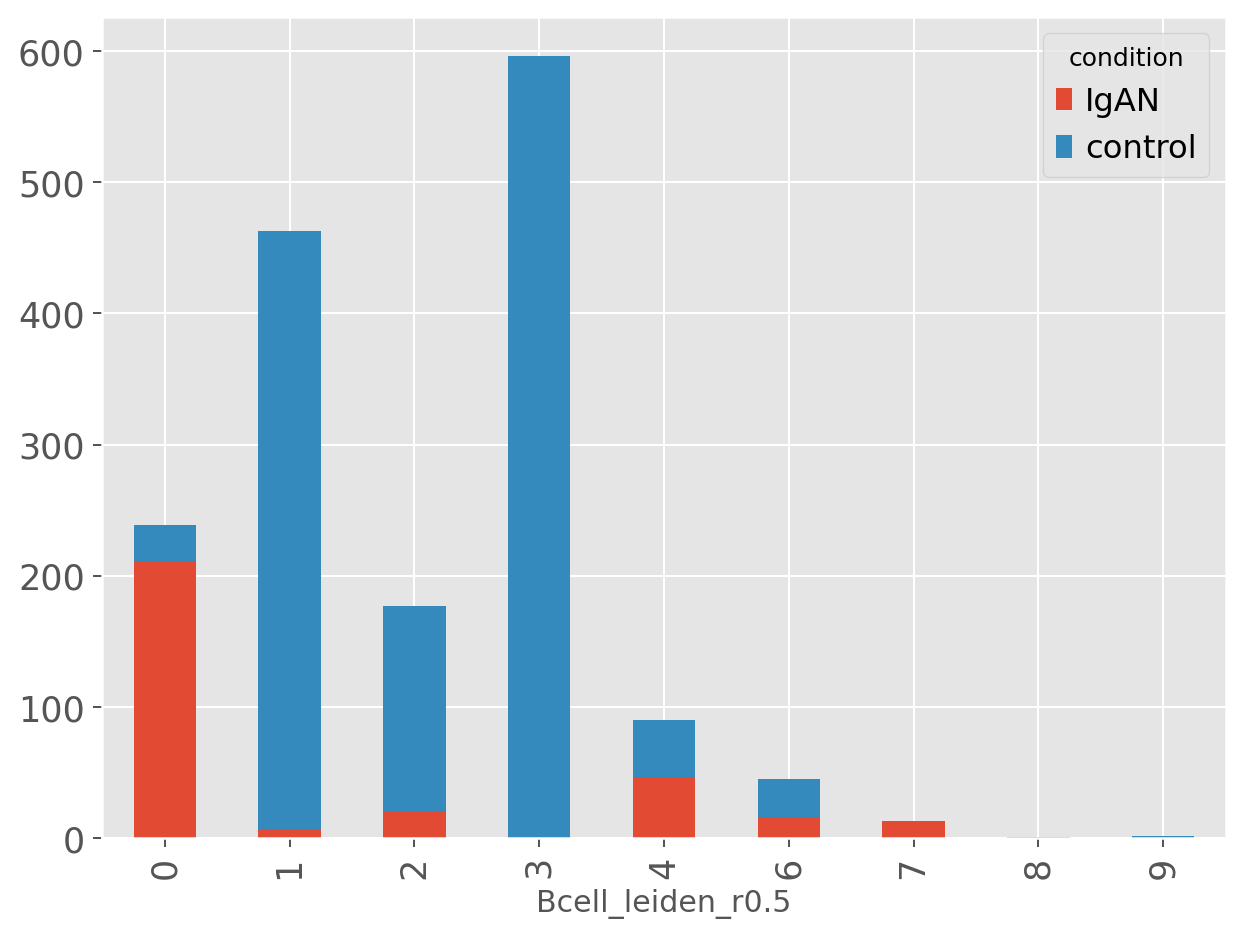

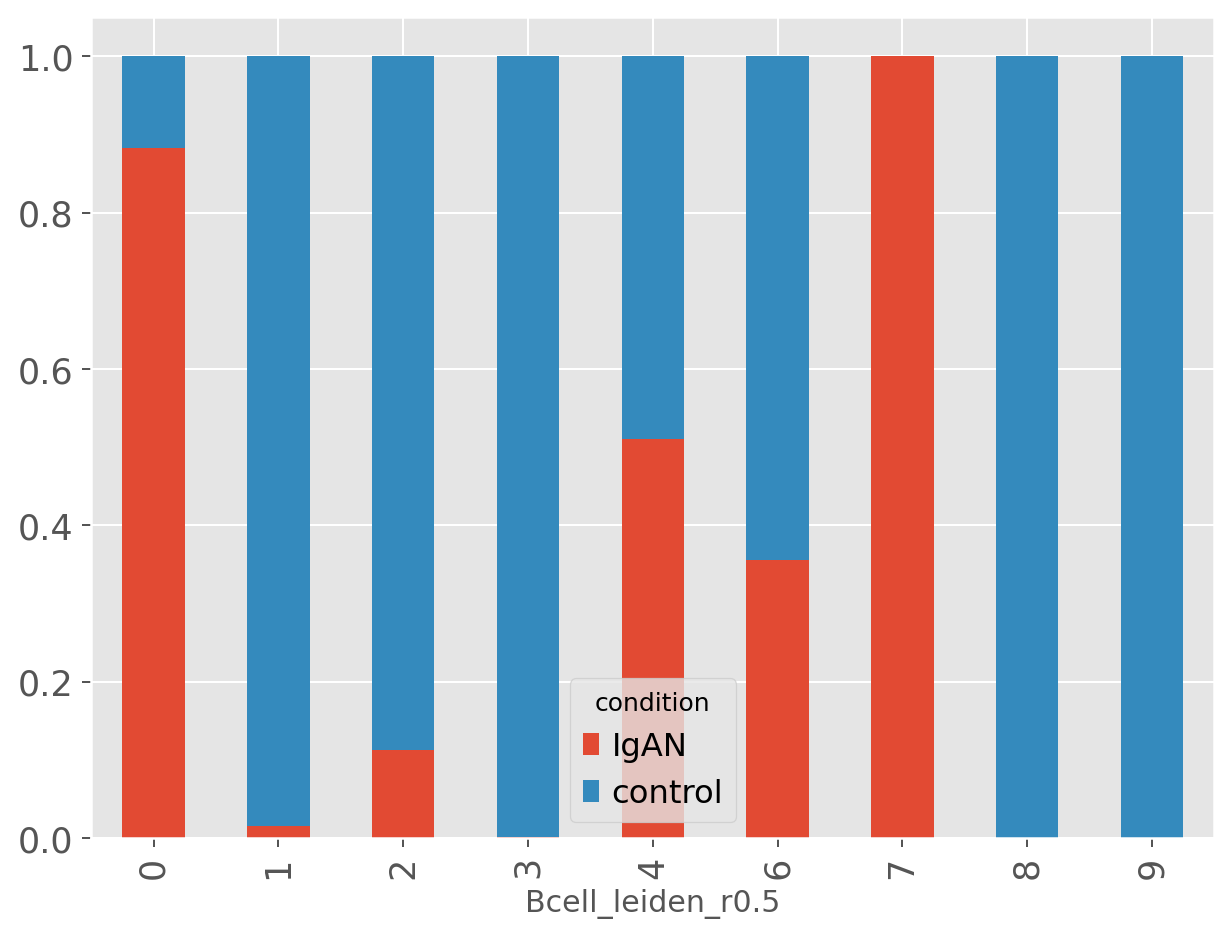

In [239]:
b_no_iga_adata.obs.groupby(['Bcell_leiden_r0.5','condition']).size().unstack().plot(kind='bar',figsize=(8,6))
b_no_iga_adata.obs.groupby(['Bcell_leiden_r0.5','condition']).size().unstack().plot(kind='bar',stacked=True, figsize=(8,6))
b_no_iga_adata.obs.groupby(['Bcell_leiden_r0.5','condition']).size().unstack().apply(lambda x: x/sum(x) , axis=1).plot(kind='bar', stacked=True, figsize=(8,6))

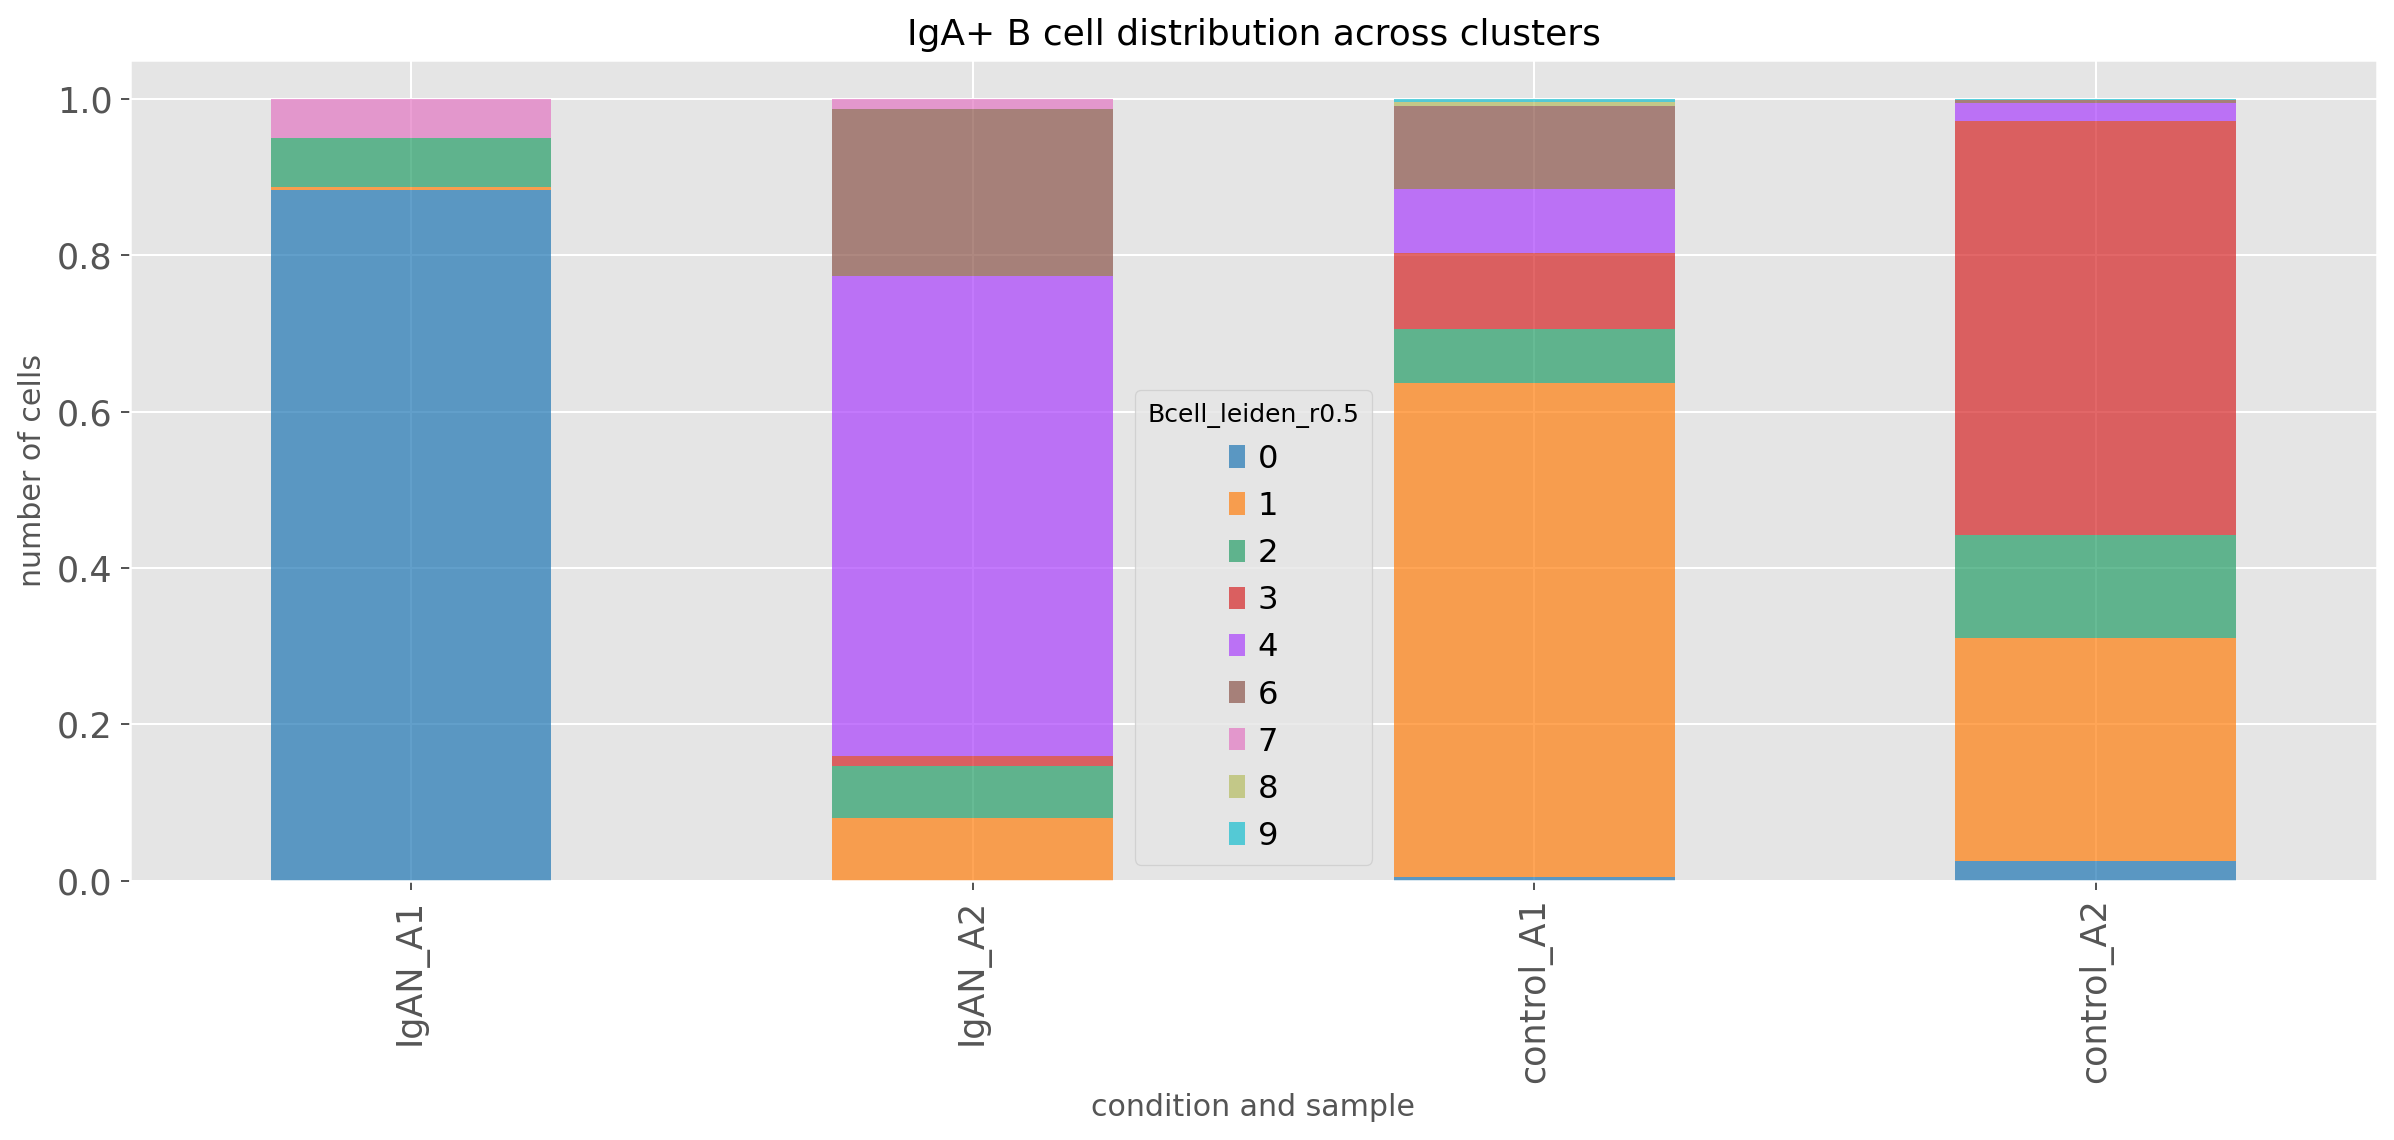

In [240]:
portion_df = b_no_iga_adata.obs.groupby(['cond_sp', 'Bcell_leiden_r0.5']).size().unstack().apply(lambda x: x/sum(x),axis=1)
color = sc.pl.palettes.default_20[:10] # sb.color_palette("tab20")  
ax = portion_df.plot(kind='bar',stacked=True, figsize=(16,6), color=color, alpha=0.7)
ax.set_xlabel('condition and sample')
ax.set_ylabel('number of cells')
ax.set_title('IgA+ B cell distribution across clusters')
portion_df = portion_df.T

### miloR

In [241]:
import milopy
import milopy.core as milo
b_adata = sc.read_h5ad(f'{work_dir}/inter_h5ad/b_adata_rm_Ig_vari.h5ad')
b_adata.uns['log1p']["base"] = None
b_adata.obs['cond_sp'] = b_adata.obs.apply(lambda x: x['condition'] + '_' + x['sample'].split('_')[0] ,axis=1)
b_no_iga_adata_milo = b_adata[b_adata.obs.query('init_cell_type == "B cell" and receptor_type != "BCR"').index,:]
milor = b_adata.copy()

In [242]:
## Build KNN graph
sc.pp.neighbors(milor, n_neighbors=10, use_rep='X_pca_harmony')
## Assign cells to neighbourhoods
milo.make_nhoods(milor)
## Count cells from each sample in each nhood
milo.count_nhoods(milor, sample_col="cond_sp")
## Test for differential abundance between conditions
milo.DA_nhoods(milor, design="~ condition")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [244]:
milo_res = milor.uns["nhood_adata"].obs
milo_res['logFC'] = - milo_res['logFC']
milo_res = pd.merge(milo_res, b_no_iga_adata_milo.obs[['condition','sample','cond_sp','Bcell_leiden_r0.5']], how='inner', left_on='index_cell',right_index=True)

In [ ]:
ax = sb.swarmplot(data=milo_res, x="logFC", y="Bcell_leiden_r0.5",hue='cond_sp')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.figure()
color = sc.pl.palettes.default_20[:10]
# color = list(sb.color_palette().as_hex())
ax = sb.swarmplot(data=milo_res, x="logFC", y="cond_sp",hue='Bcell_leiden_r0.5',palette=color)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.figure()
ax = sb.swarmplot(data=milo_res, x="logFC", y="sample",hue='cond_sp')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))